In [1]:
!pip install statsbombpy
!pip install mplsoccer
!pip install highlight_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 1.2 MB/s eta 0:00:00


# Imports

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, chi2
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import networkx as nx
from sklearn.preprocessing import LabelEncoder
import ast
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import plotly.express as px
import plotly.graph_objects as go
from mplsoccer import Pitch

# Análisis de datos

Cluster	Silhouette_score


14 | 0.716682

9	 | 0.669541

0	 | 0.644231

4	 | 0.611741

18 | 0.551170

7	 | 0.524601

6	 | 0.518336

1  | 0.514110

13 | 0.510331




In [4]:
warnings.filterwarnings("ignore", category=UserWarning, module="statsbombpy.api_client")

In [5]:
from google.colab import drive
drive.mount('/content/drive')
EG_full = pd.read_csv('/content/drive/MyDrive/Hackathon FUT/Data/EG_full.csv')
EG_full.head()

Mounted at /content/drive


match_id            comp     season               home_team      away_team  \
0      7536  FIFA World Cup       2018                 Belgium         Panama   
1      7581  FIFA World Cup       2018                 Croatia        Denmark   
2    265894         La Liga  2015/2016                  Málaga      Barcelona   
3    266149         La Liga  2015/2016               Barcelona  Athletic Club   
4    266310         La Liga  2015/2016  RC Deportivo La Coruña      Barcelona   

  scoring_team          team_scored_on  minute  cluster  KO_short_possessions  \
0      Belgium                  Panama      46        1                     5   
1      Croatia                 Denmark       0        6                     9   
2    Barcelona                  Málaga       1        7                     2   
3    Barcelona           Athletic Club      46       16                     9   
4    Barcelona  RC Deportivo La Coruña      46       16                     9   

   ...   GD_diff  xGD_diff  xGdf_diff   GF_diff   GA_diff   xG_diff  xGA_diff  \
0  ...  2.926448  1.276300  -0.306917  0.200313 -2.726135  0.507230 -0.769070   
1  ... -0.371212  0.045425  -0.047969  0.352652  0.723864  0.400621  0.355196   
2  ...  2.090615  1.436278   0.734581  2.007752 -0.082863  1.273171 -0.163107   
3  ...  1.432129  0.973091   0.213794  1.119869 -0.312261  0.906075 -0.067016   
4  ...  2.600000  1.521999   0.454905  1.661538 -0.938462  1.206633 -0.315366   

  Possession_Percentage_diff     x_fav       fav  
0                   2.840712   med fav  high fav  
1                   3.588275   neutral   neutral  
2                  15.661709   med fav  high fav  
3                  15.924716   low fav   med fav  
4                  17.238028  high fav  high fav  

[5 rows x 28 columns]

In [6]:
for col in EG_full.columns:
  print(col)

match_id
comp
season
home_team
away_team
scoring_team
team_scored_on
minute
cluster
KO_short_possessions
KO_medium_possessions
KO_long_possessions
DS_short_possessions
DS_medium_possessions
DS_long_possessions
last_event
second_last_event
shot_data
GD_diff
xGD_diff
xGdf_diff
GF_diff
GA_diff
xG_diff
xGA_diff
Possession_Percentage_diff
x_fav
fav


## Distribuciones

In [ ]:
plt.figure(figsize=(10, 6))  # Ajusta la gráfica
sns.barplot(x=fav_counts.index, y=fav_counts.values)
plt.xlabel('Favorite Team')
plt.ylabel('Number of Rows')
plt.title('Number of Rows for Each Favorite Team')
plt.xticks(rotation=45, ha='right')  # Rota los nombres en el eje x
plt.tight_layout()
plt.show()

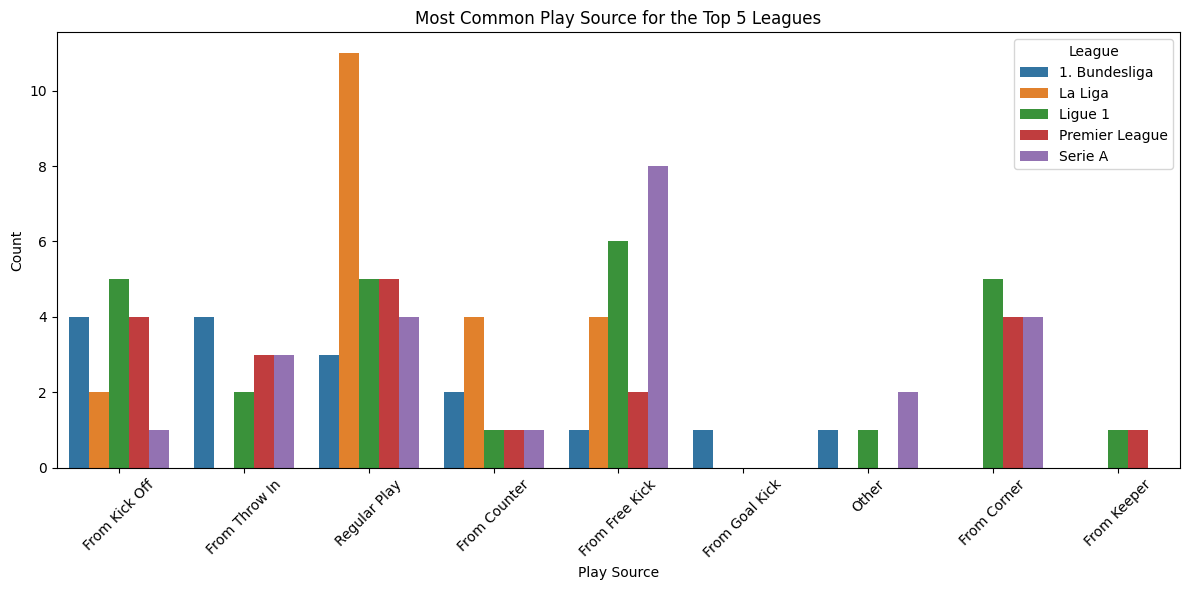

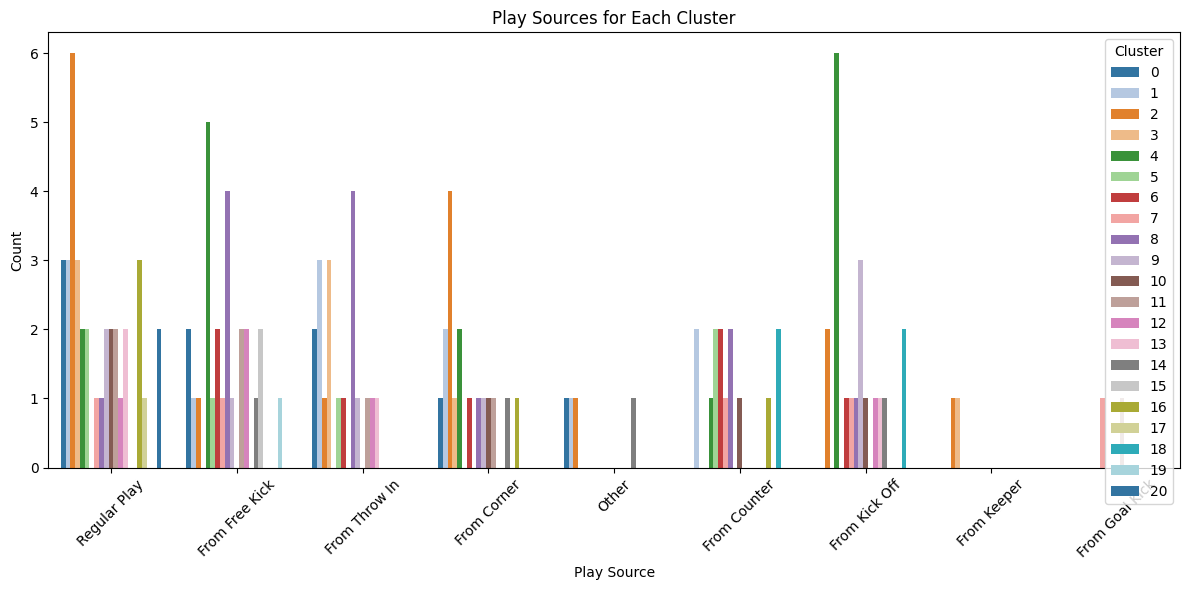

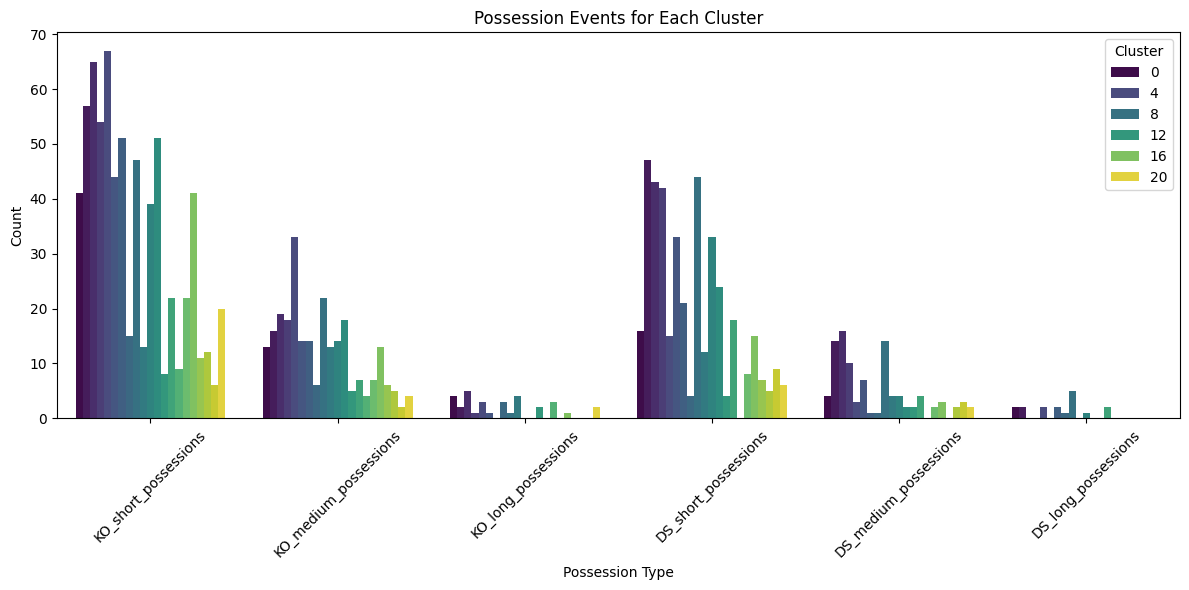

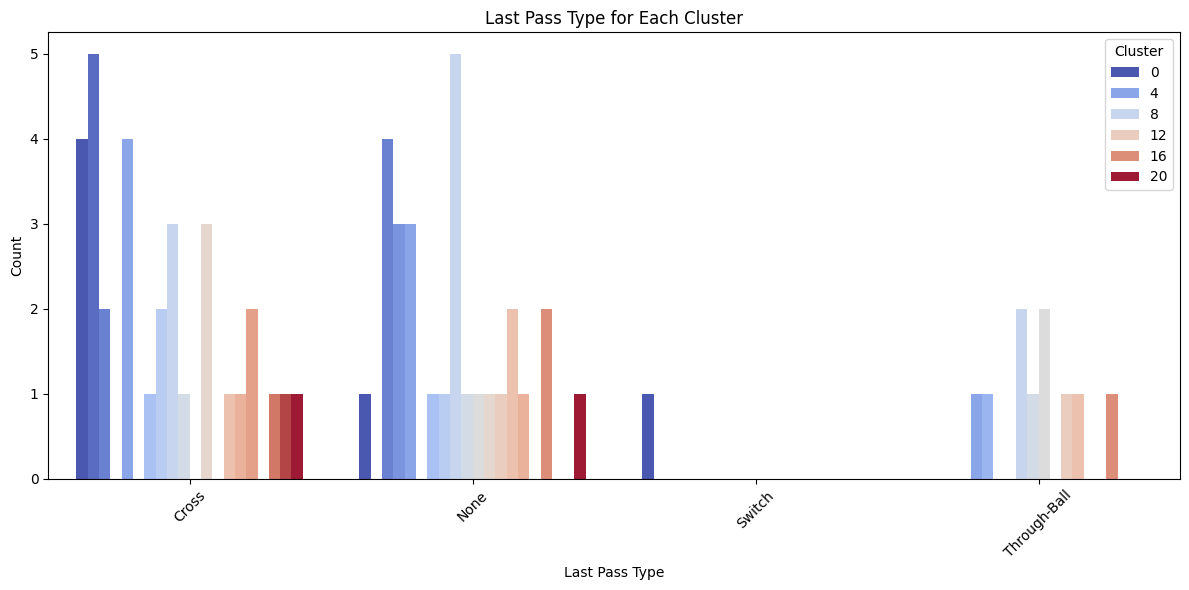

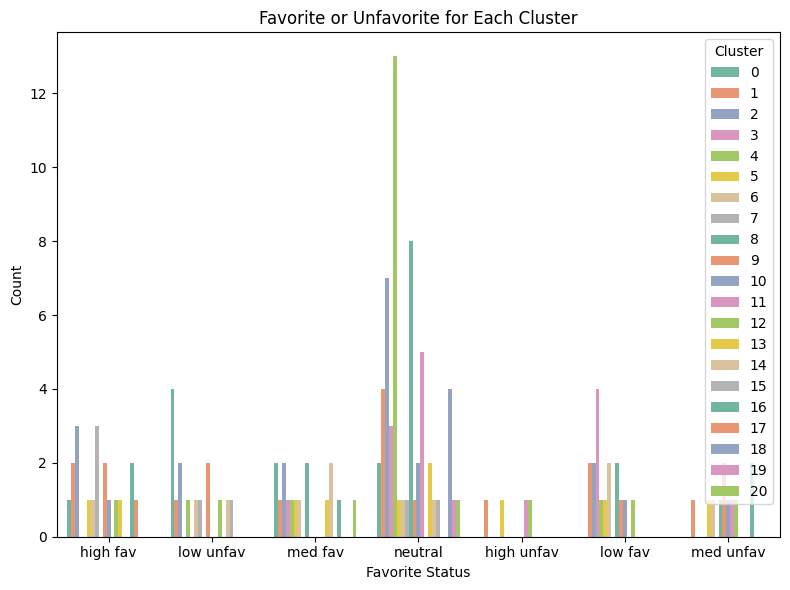

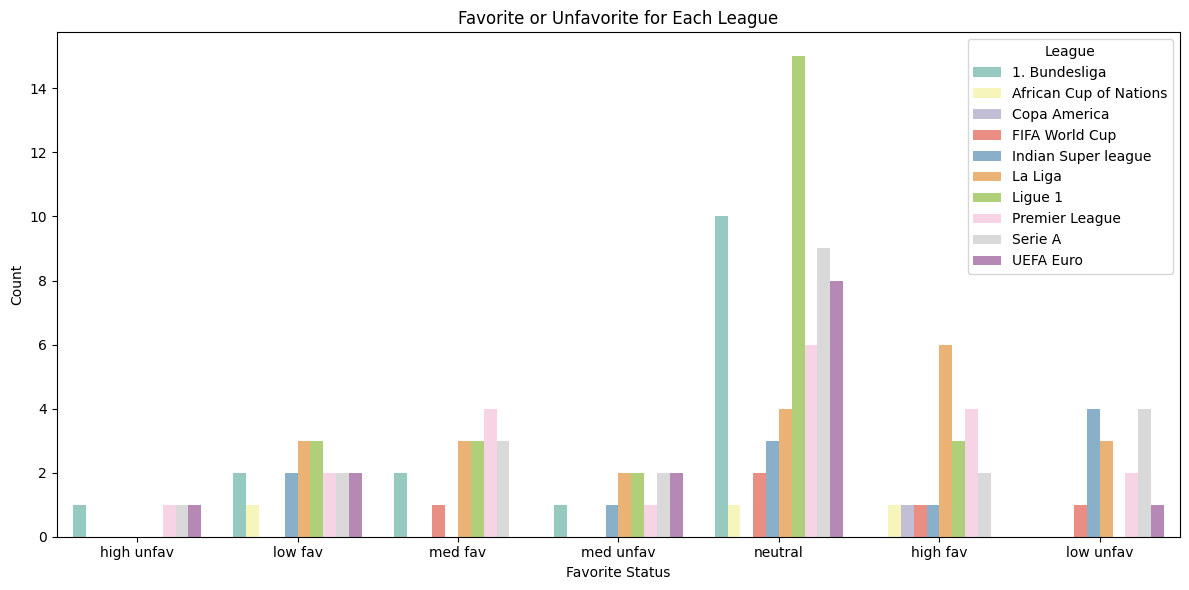

<ipython-input-9-8dcde723d53a>:179: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster', y='minute', palette='Accent')


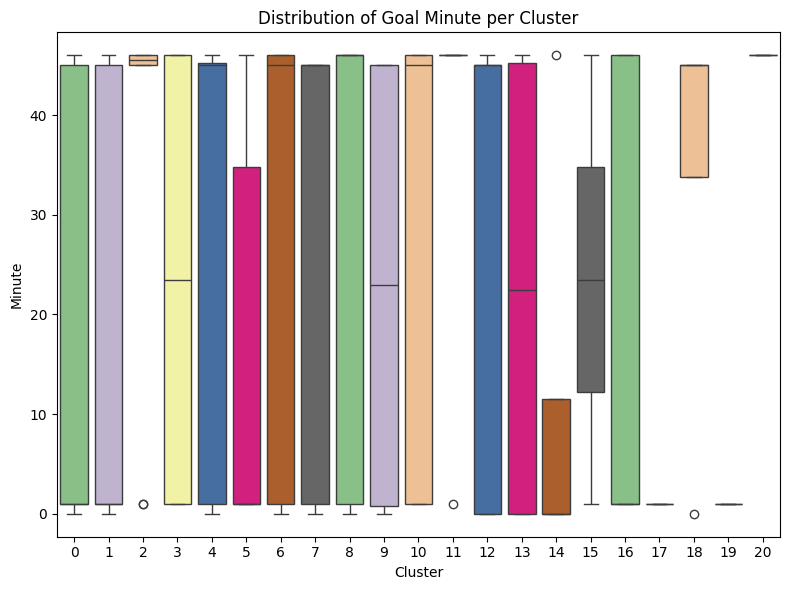

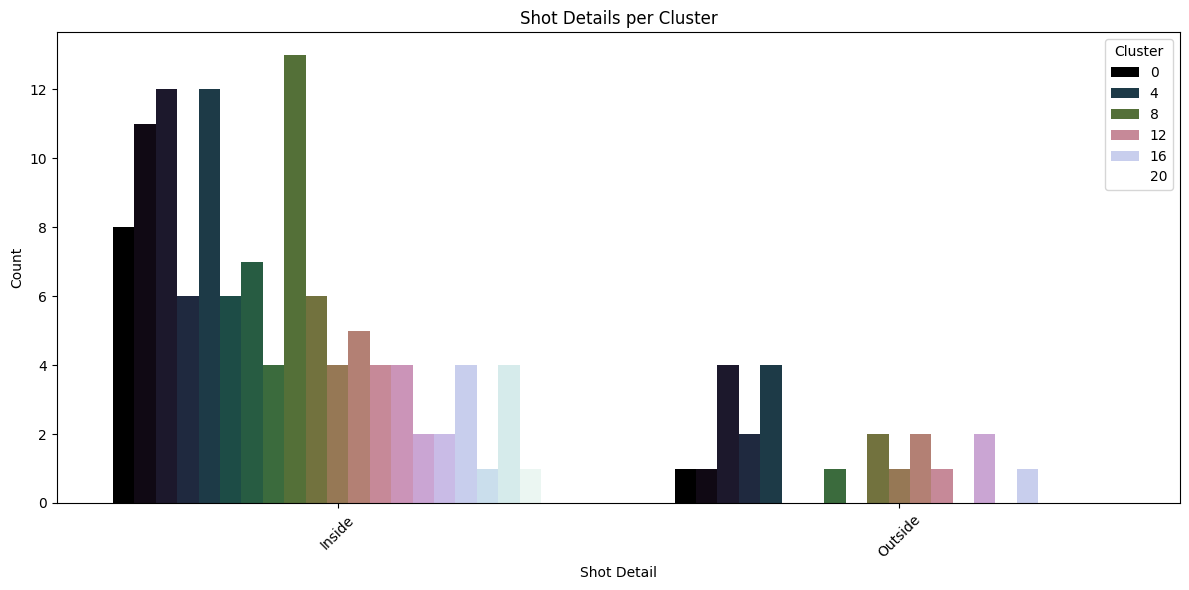

In [9]:
df = EG_full

#Convierte strings en diccionarios actuales
def safely_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return val

for col in ['shot_data', 'last_event', 'second_last_event']:
    df[col] = df[col].apply(lambda x: safely_eval(x) if isinstance(x, str) else x)

#Extrae play source' de 'shot_data'
df['play_source'] = df['shot_data'].apply(
    lambda x: x.get('event', {}).get('play_source') if isinstance(x, dict) else None
)


# 1. 'Play source' más común de las 5 principales ligas
top_leagues = df['comp'].value_counts().head(5).index.tolist()
df_top_leagues = df[df['comp'].isin(top_leagues)]

play_source_counts = (
    df_top_leagues.groupby('comp')['play_source']
    .value_counts()
    .rename('count')
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=play_source_counts,
    x='play_source',
    y='count',
    hue='comp',
    palette='tab10'
)
plt.title('Most Common Play Source for the Top 5 Leagues')
plt.xlabel('Play Source')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='League')
plt.tight_layout()
plt.show()

# 2. Fuentes de juego para cada cluster
play_source_cluster_counts = (
    df.groupby('cluster')['play_source']
    .value_counts()
    .rename('count')
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=play_source_cluster_counts,
    x='play_source',
    y='count',
    hue='cluster',
    palette='tab20'
)
plt.title('Play Sources for Each Cluster')
plt.xlabel('Play Source')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# 3. Eventos de possesion de cada cluster
possession_cols = [
    'KO_short_possessions', 'KO_medium_possessions', 'KO_long_possessions',
    'DS_short_possessions', 'DS_medium_possessions', 'DS_long_possessions'
]

cluster_possessions = df.groupby('cluster')[possession_cols].sum().reset_index()
cluster_possessions_melted = cluster_possessions.melt(
    id_vars='cluster',
    var_name='Possession Type',
    value_name='Count'
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=cluster_possessions_melted,
    x='Possession Type',
    y='Count',
    hue='cluster',
    palette='viridis'
)
plt.title('Possession Events for Each Cluster')
plt.xlabel('Possession Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

#4. Último tipo de pase para cada cluster si existe
def get_pass_type(event):
    if isinstance(event, dict) and event.get('type') == 'Pass':
        return event.get('pass_type')
    return None

df['last_pass_type'] = df['last_event'].apply(get_pass_type)

pass_type_counts = (
    df.dropna(subset=['last_pass_type'])
    .groupby('cluster')['last_pass_type']
    .value_counts()
    .rename('count')
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=pass_type_counts,
    x='last_pass_type',
    y='count',
    hue='cluster',
    palette='coolwarm'
)
plt.title('Last Pass Type for Each Cluster')
plt.xlabel('Last Pass Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# 5. Favorito o no favorito para cada cluster
fav_counts_cluster = (
    df.groupby(['cluster', 'fav'])
    .size()
    .rename('count')
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=fav_counts_cluster,
    x='fav',
    y='count',
    hue='cluster',
    palette='Set2'
)
plt.title('Favorite or Unfavorite for Each Cluster')
plt.xlabel('Favorite Status')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

#Favorito o no para cada liga
fav_counts_league = (
    df.groupby(['comp', 'fav'])
    .size()
    .rename('count')
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=fav_counts_league,
    x='fav',
    y='count',
    hue='comp',
    palette='Set3'
)
plt.title('Favorite or Unfavorite for Each League')
plt.xlabel('Favorite Status')
plt.ylabel('Count')
plt.legend(title='League')
plt.tight_layout()
plt.show()

#Ejemplo: Distribución de gol por minuto de cada cluster
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='cluster', y='minute', palette='Accent')
plt.title('Distribution of Goal Minute per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Minute')
plt.tight_layout()
plt.show()

#Ejemplo: Detalles del tiro por cluster
df['shot_detail'] = df['shot_data'].apply(
    lambda x: x.get('event', {}).get('shot_detail') if isinstance(x, dict) else None
)

shot_detail_counts = (
    df.dropna(subset=['shot_detail'])
    .groupby('cluster')['shot_detail']
    .value_counts()
    .rename('count')
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=shot_detail_counts,
    x='shot_detail',
    y='count',
    hue='cluster',
    palette='cubehelix'
)
plt.title('Shot Details per Cluster')
plt.xlabel('Shot Detail')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


<ipython-input-12-65c8eb1656d1>:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




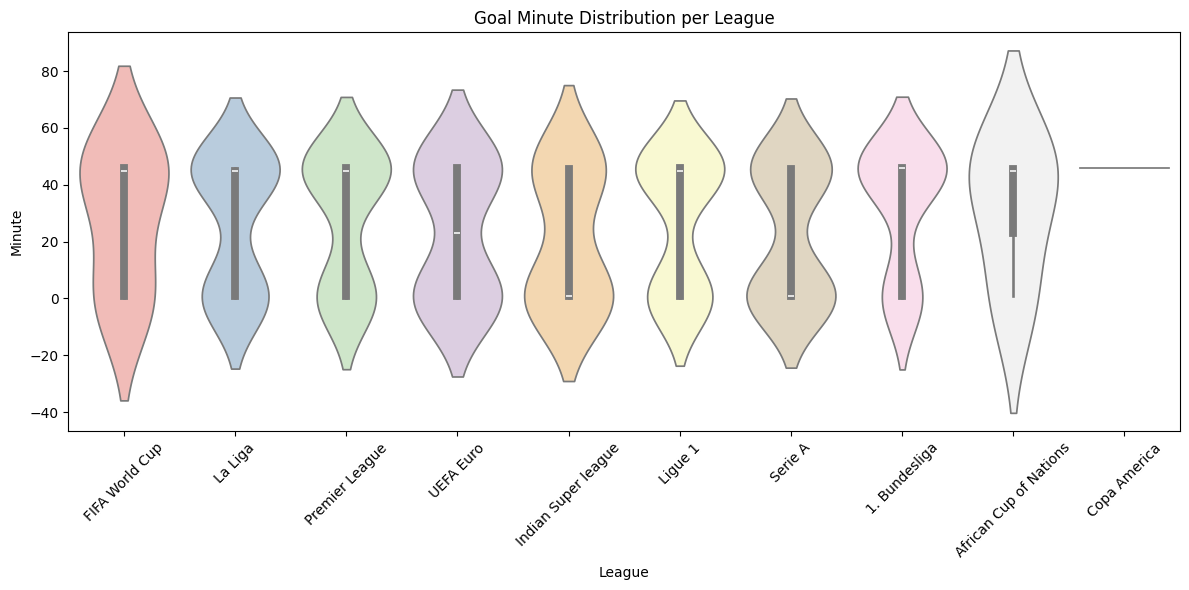

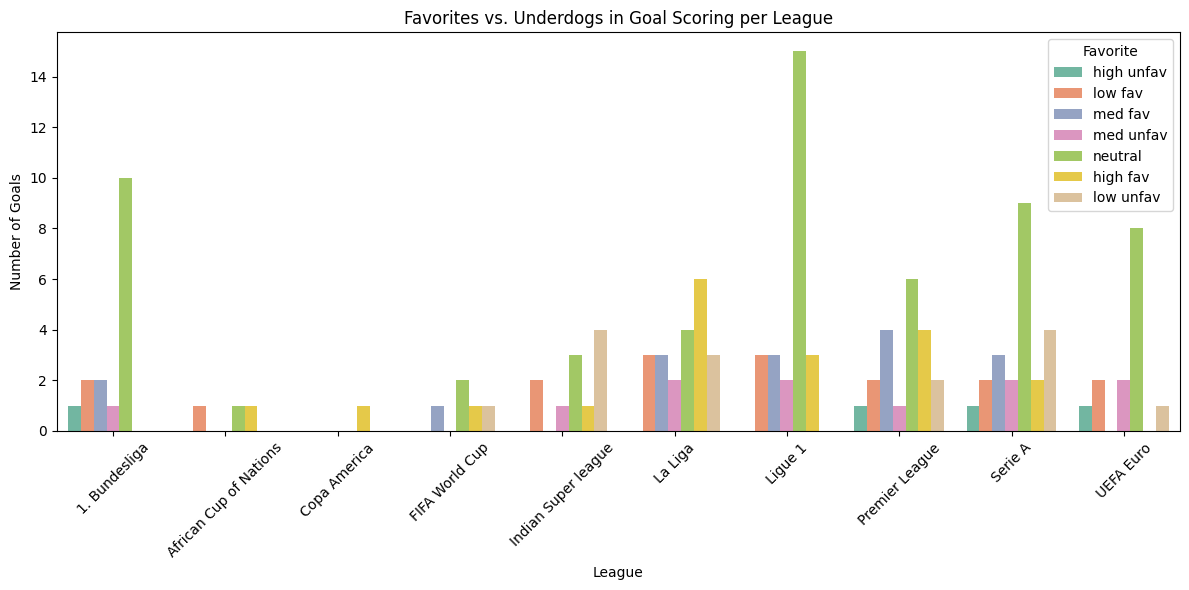

In [12]:
# Asumimos df está en el DataFrame y las columnas necesarias están listas para proceder

# 1. Mapa de calor de correlación de las diferencias numéricas
numerical_diff_cols = [
    'GD_diff', 'xGD_diff', 'xGdf_diff', 'GF_diff', 'GA_diff',
    'xG_diff', 'xGA_diff', 'Possession_Percentage_diff'
]


# 2. Diagrama de Sankey del flujo de eventos
# Preparar los datos para el diagrama de Sankey
def get_event_type(event):
    if isinstance(event, dict):
        return event.get('type')
    return 'Unknown'

df['last_event_type'] = df['last_event'].apply(get_event_type)
df['second_last_event_type'] = df['second_last_event'].apply(get_event_type)

sankey_data = df.groupby(['second_last_event_type', 'last_event_type']) \
    .size().reset_index(name='count')

#Crear el diagrama de Sankey usando plotly.graph_objects
# Cambia px.sankey a go.Sankey
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = list(set(sankey_data['second_last_event_type']).union(set(sankey_data['last_event_type'])))
    ),
    link = dict(
      source = sankey_data['second_last_event_type'].apply(lambda x: list(set(sankey_data['second_last_event_type'])).index(x)),
      target = sankey_data['last_event_type'].apply(lambda x: list(set(sankey_data['last_event_type'])).index(x)),
      value = sankey_data['count']
  ))])

fig.update_layout(title_text="Event Flow Leading to Goals", font_size=10)
fig.show()


# 4. Distribución de gol por minuto por Liga
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='comp', y='minute', palette='Pastel1')
plt.title('Goal Minute Distribution per League')
plt.xlabel('League')
plt.ylabel('Minute')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 5. Comaración de favoritos y no favoritos en la anotación de gol
# Suponiendo que la columna 'fav' indica si el equipo que anotó era el favorito ('Sí' o 'No')
fav_goal_counts = df.groupby(['comp', 'fav']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.barplot(data=fav_goal_counts, x='comp', y='count', hue='fav', palette='Set2')
plt.title('Favorites vs. Underdogs in Goal Scoring per League')
plt.xlabel('League')
plt.ylabel('Number of Goals')
plt.xticks(rotation=45)
plt.legend(title='Favorite')
plt.tight_layout()
plt.show()




5 principales ligas de anotación de goles por favoritos o no favoritos

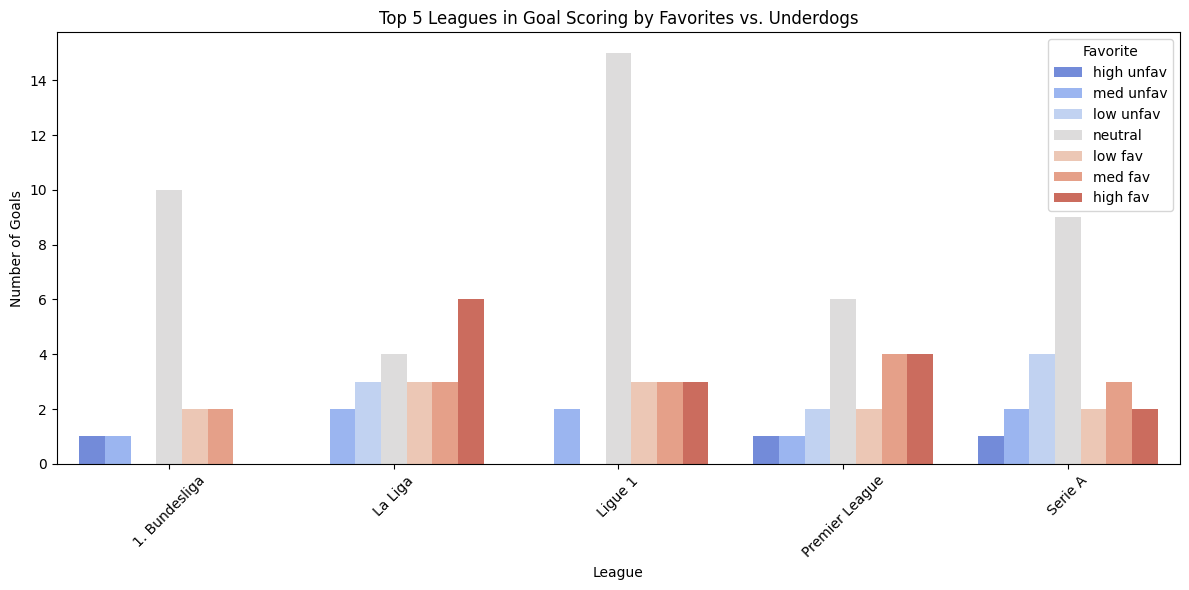

In [14]:
# Agrupar los datos por liga y favoritismo para contar los goles
fav_goal_counts = df.groupby(['comp', 'fav']).size().reset_index(name='count')

# Obtener el total de goles por liga y seleccionar las top 5 ligas
top_leagues = fav_goal_counts.groupby('comp')['count'].sum().nlargest(5).index
top_5_fav_goal_counts = fav_goal_counts[fav_goal_counts['comp'].isin(top_leagues)]

# Orden de categorías de menos favorito a más favorito
fav_order = ["high unfav", "med unfav", "low unfav", "neutral", "low fav", "med fav", "high fav"]

# Paleta de colores personalizada que sigue el orden de menos favorito a más favorito
palette = sns.color_palette("coolwarm", len(fav_order))

# Crear el gráfico de barras con los datos de las 5 ligas principales
plt.figure(figsize=(12, 6))
sns.barplot(data=top_5_fav_goal_counts, x='comp', y='count', hue='fav', palette=palette, hue_order=fav_order)
plt.title('Top 5 Leagues in Goal Scoring by Favorites vs. Underdogs')
plt.xlabel('League')
plt.ylabel('Number of Goals')
plt.xticks(rotation=45)
plt.legend(title='Favorite', loc='upper right')
plt.tight_layout()
plt.show()


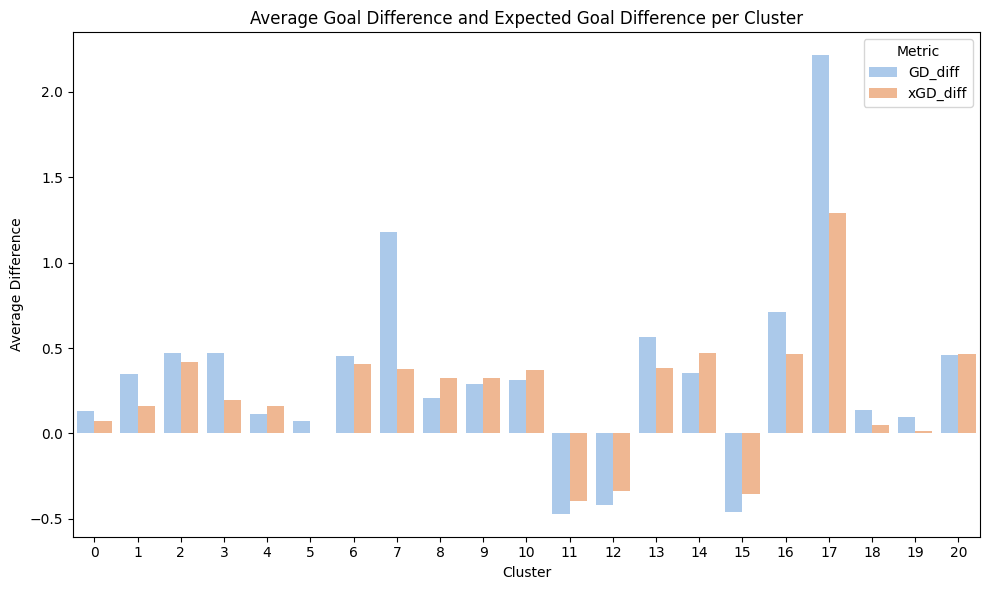

<ipython-input-15-ac81be790c5c>:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




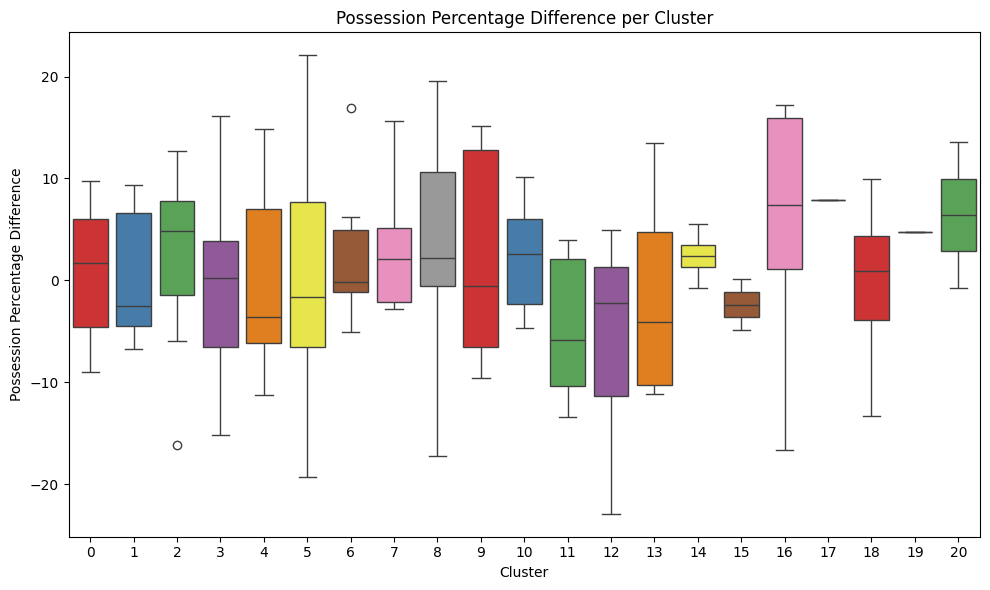

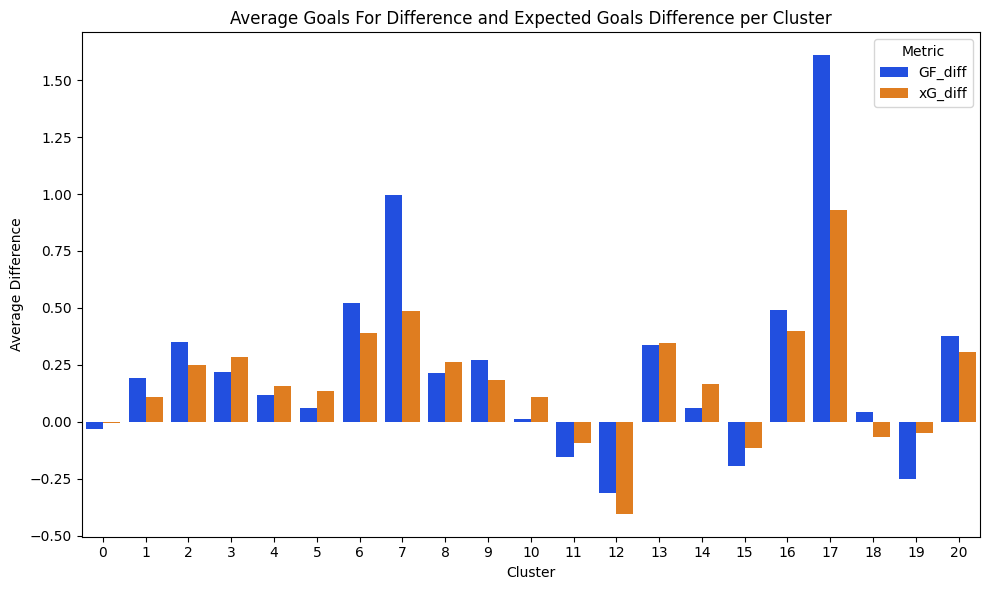

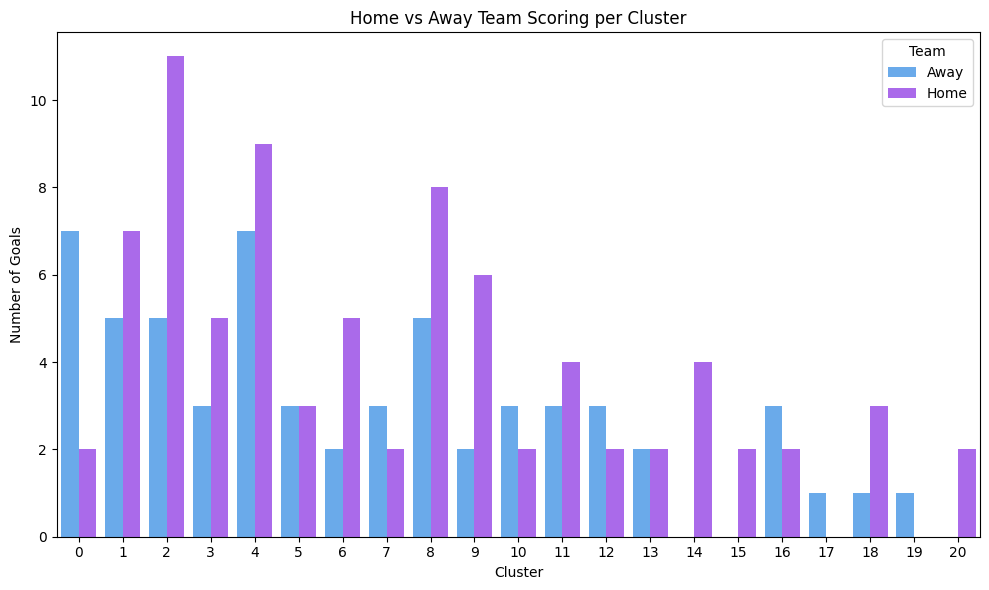

In [15]:
# Compara la actual diferencia de gol (GD_diff) y la diferencia de goles esperados (xGD_diff) con respecto a los Clusters

# Asegurarse que GD_diff y xGD_diff son numericos
df['GD_diff'] = pd.to_numeric(df['GD_diff'], errors='coerce')
df['xGD_diff'] = pd.to_numeric(df['xGD_diff'], errors='coerce')

# Crear un datadrame para GD_diff y xGD_diff por cluster
gd_stats = df.groupby('cluster')[['GD_diff', 'xGD_diff']].mean().reset_index()

# Transforma el dataframe para graficar
gd_stats_melted = gd_stats.melt(id_vars='cluster', value_vars=['GD_diff', 'xGD_diff'], var_name='Metric', value_name='Average Value')

# Grafica los datos
plt.figure(figsize=(10, 6))
sns.barplot(data=gd_stats_melted, x='cluster', y='Average Value', hue='Metric', palette='pastel')
plt.title('Average Goal Difference and Expected Goal Difference per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Difference')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# Analiza el porcentaje de la diferencia de posesión por cluster
# Asegurarse que el porcentaje de la diferencia de posesión es numérico
df['Possession_Percentage_diff'] = pd.to_numeric(df['Possession_Percentage_diff'], errors='coerce')

# Graficar la diferencia del porcentaje de posesión por cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cluster', y='Possession_Percentage_diff', palette='Set1')
plt.title('Possession Percentage Difference per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Possession Percentage Difference')
plt.tight_layout()
plt.show()

# Compara los goles actuales con los esperados por cluster
# Asegurarse que G_diff y xG_diff son numéricos
df['GF_diff'] = pd.to_numeric(df['GF_diff'], errors='coerce')
df['xG_diff'] = pd.to_numeric(df['xG_diff'], errors='coerce')

# Crear un dataframe para GF_diff y xG_diff por cluster
goal_stats = df.groupby('cluster')[['GF_diff', 'xG_diff']].mean().reset_index()

# Transformar el dataframe para graficar
goal_stats_melted = goal_stats.melt(id_vars='cluster', value_vars=['GF_diff', 'xG_diff'], var_name='Metric', value_name='Average Value')

# Graficar los datos
plt.figure(figsize=(10, 6))
sns.barplot(data=goal_stats_melted, x='cluster', y='Average Value', hue='Metric', palette='bright')
plt.title('Average Goals For Difference and Expected Goals Difference per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Difference')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# Analizar la puntuación del equipo local y visitante por cluster

#Creaa una columna que indica si el equipo es local o de visitante
df['scoring_team_home_away'] = df.apply(lambda row: 'Home' if row['scoring_team'] == row['home_team'] else 'Away', axis=1)

# Cuenta la puntuación del local y visitante por cluster
home_away_counts = df.groupby('cluster')['scoring_team_home_away'].value_counts().rename('count').reset_index()

# Graficar los datos
plt.figure(figsize=(10, 6))
sns.barplot(data=home_away_counts, x='cluster', y='count', hue='scoring_team_home_away', palette='cool')
plt.title('Home vs Away Team Scoring per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Goals')
plt.legend(title='Team')
plt.tight_layout()
plt.show()



In [16]:
def string_to_dict(input_string):
    try:
        # Intentar analizar la cadena como un diccionario
        return ast.literal_eval(input_string)
    except (ValueError, SyntaxError):
        # Si el análisis falla, devolver un diccionario vacío o manejar el error, según sea el caso
        return {}

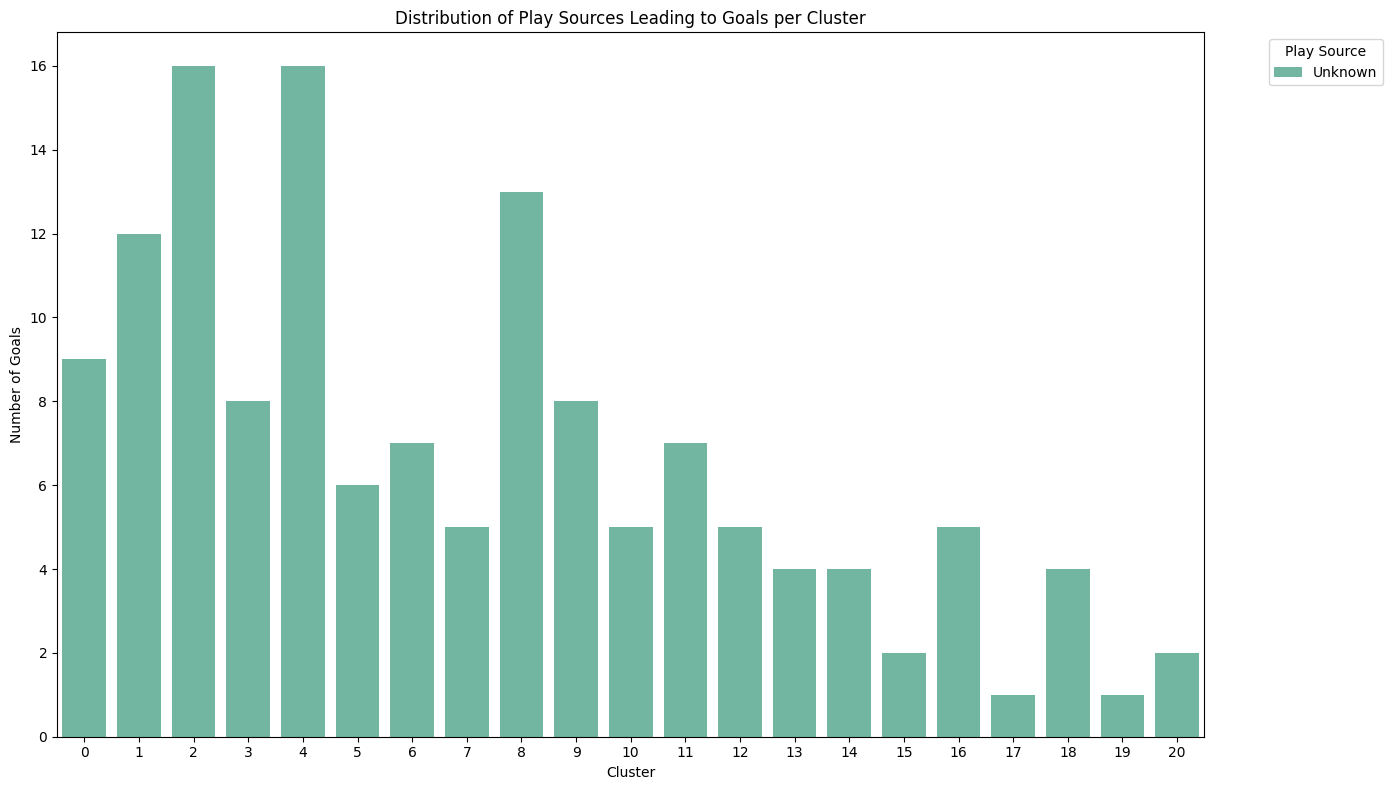

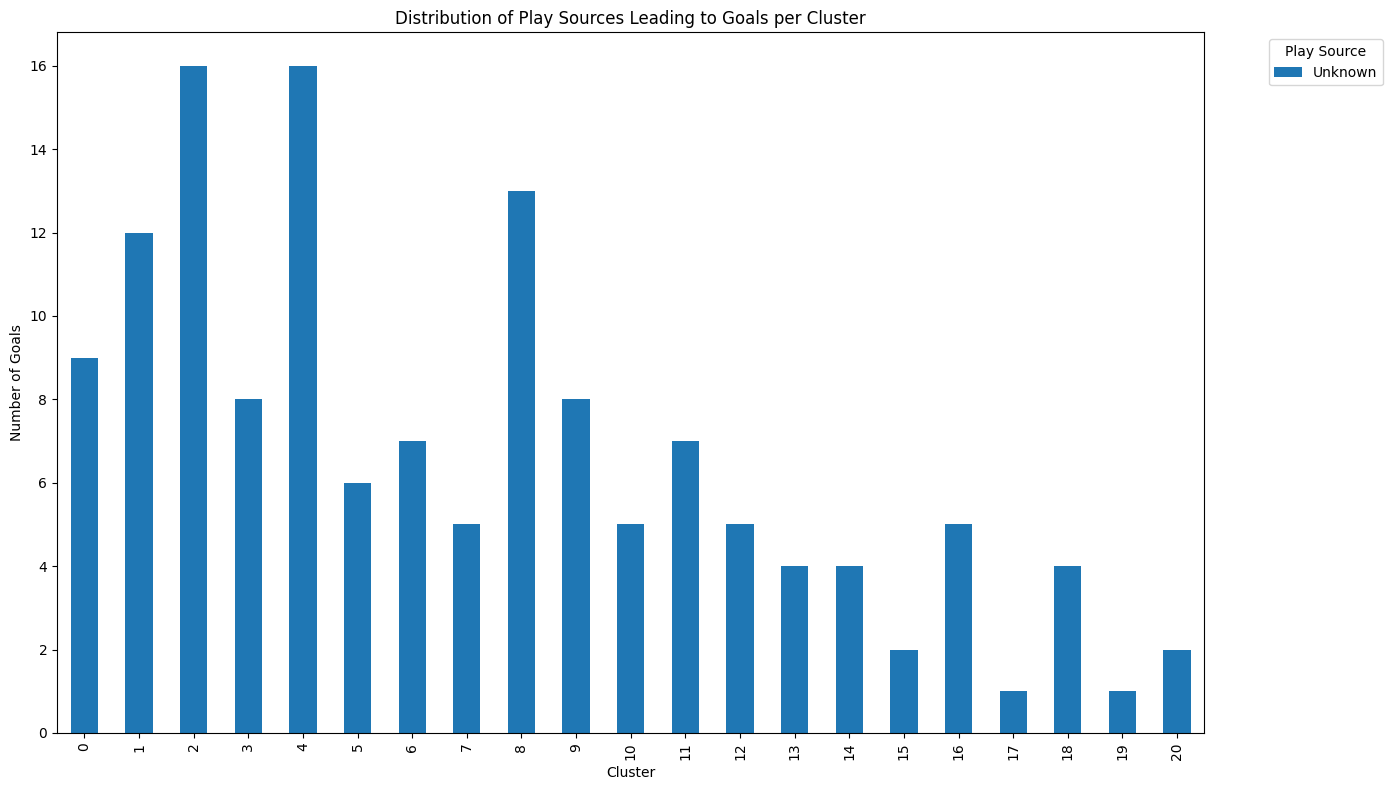

<ipython-input-19-46c6e494feb9>:50: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




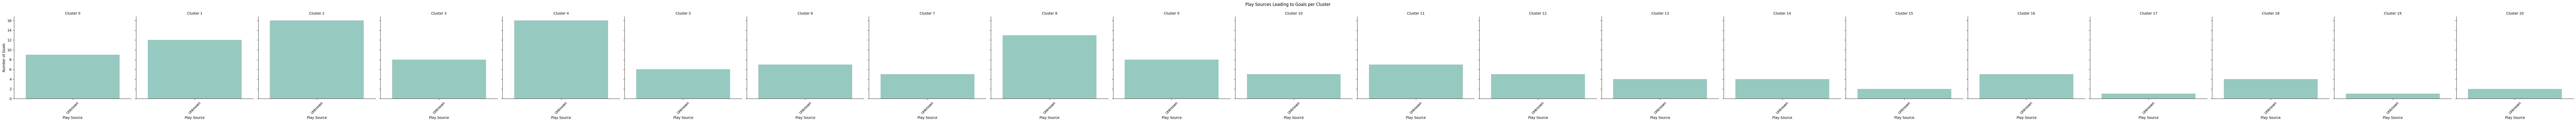

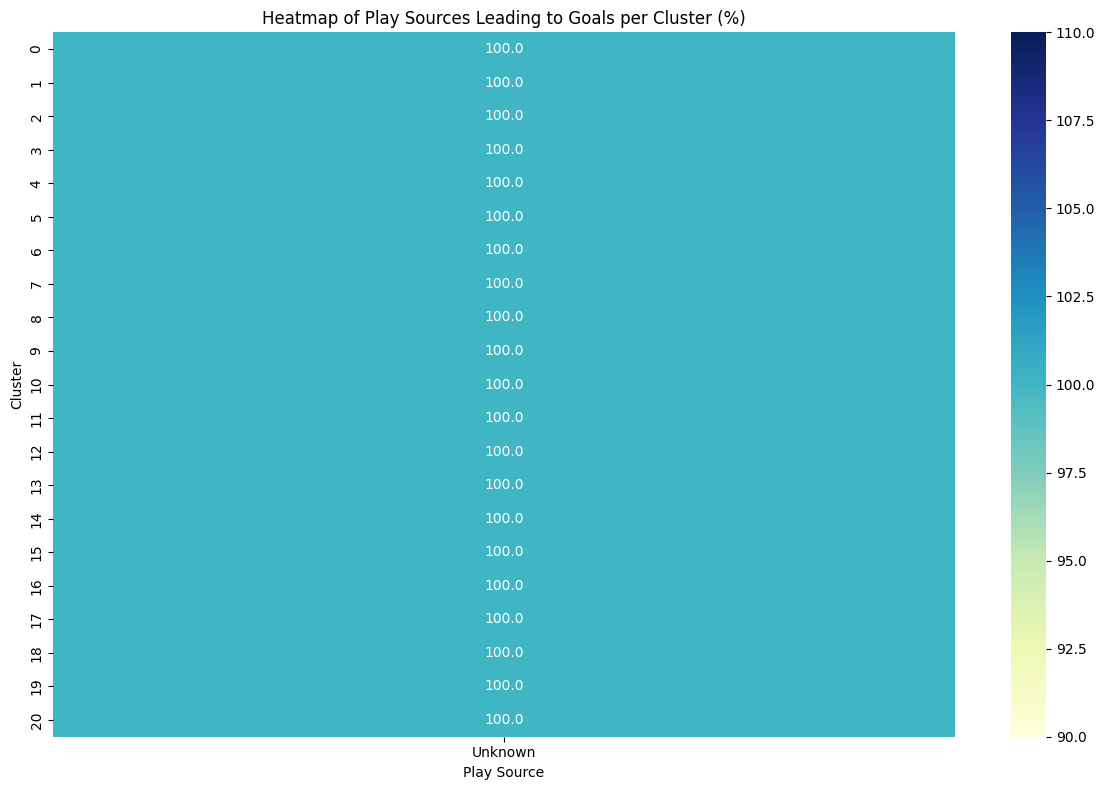

In [19]:
# Asumimos que el DataFrame tiene de nombre 'df'

# Paso 1: Extraer 'play_source' de 'shot_data'
def extract_play_source(shot_data):
    shot_data = string_to_dict(shot_data)
    if isinstance(shot_data, dict):
        return shot_data.get('event', {}).get('play_source')
    return None

df['play_source'] = df['shot_data'].apply(extract_play_source)

# Paso 2: Manejar valores faltantes de 'play_source'
# Opcionalmente, puedes rellenar los valores faltantes con 'Desconocido' o eliminarlos
df['play_source'] = df['play_source'].fillna('Unknown')

# Paso 3: Calcular la cantidad y el porcentaje de cada play_source por cluster
play_source_counts = df.groupby(['cluster', 'play_source']).size().reset_index(name='count')

# Optionally, calculate percentages for better comparison
play_source_totals = play_source_counts.groupby('cluster')['count'].transform('sum')
play_source_counts['percentage'] = (play_source_counts['count'] / play_source_totals) * 100

# Paso 4: Graficar

# Opción 4A: Gráfico de Barras Agrupadas que Muestra las Cantidades
plt.figure(figsize=(14, 8))
sns.barplot(data=play_source_counts, x='cluster', y='count', hue='play_source', palette='Set2')
plt.title('Distribution of Play Sources Leading to Goals per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Goals')
plt.legend(title='Play Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Opción 4B: Gráfico de Barras Apiladas que Muestra los Porcentajes
# Para crear un gráfico de barras apiladas, necesitamos pivotar los datos
play_source_pivot = play_source_counts.pivot(index='cluster', columns='play_source', values='count').fillna(0)

# Gráfico de barras
play_source_pivot.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.title('Distribution of Play Sources Leading to Goals per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Goals')
plt.legend(title='Play Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Opción 4C: Gráficos de Barras Facetados para Cada Cluster
g = sns.catplot(
    data=play_source_counts,
    x='play_source',
    y='count',
    col='cluster',
    kind='bar',
    height=5,
    aspect=1,
    palette='Set3'
)
g.set_titles("Cluster {col_name}")
g.set_axis_labels("Play Source", "Number of Goals")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Play Sources Leading to Goals per Cluster')
plt.tight_layout()
plt.show()

# Opción 4D: Mapa de Calor de Fuentes de Juego por Cluster
# Normalizar las cantidades a porcentajes para una mejor comparación
play_source_pivot_percent = play_source_counts.pivot(index='cluster', columns='play_source', values='percentage').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(play_source_pivot_percent, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('Heatmap of Play Sources Leading to Goals per Cluster (%)')
plt.xlabel('Play Source')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()


<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




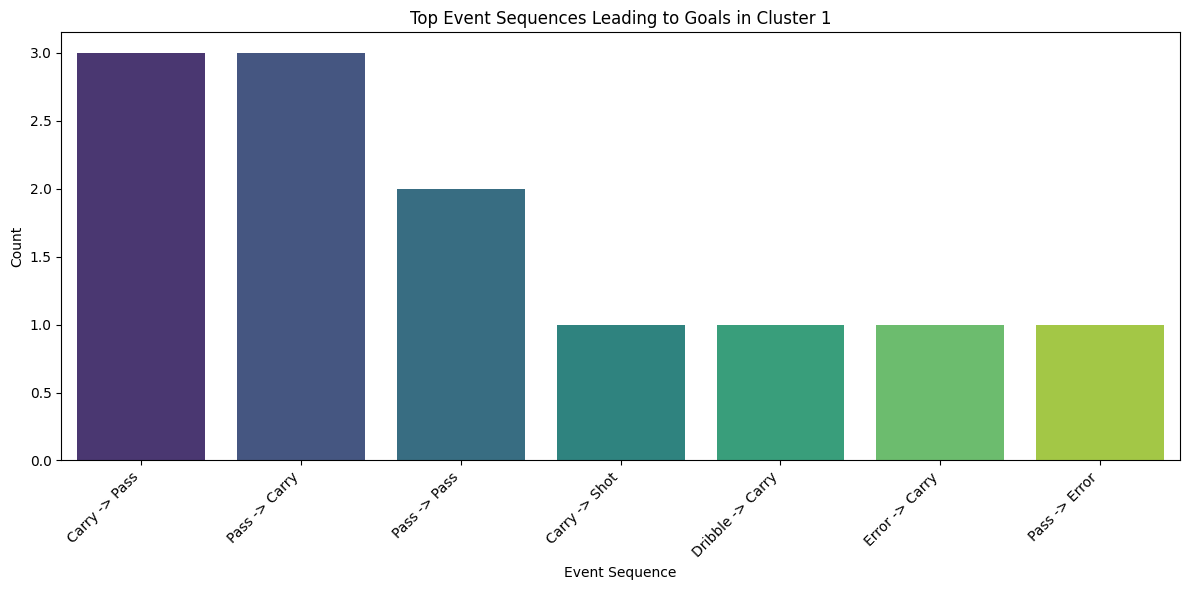

<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




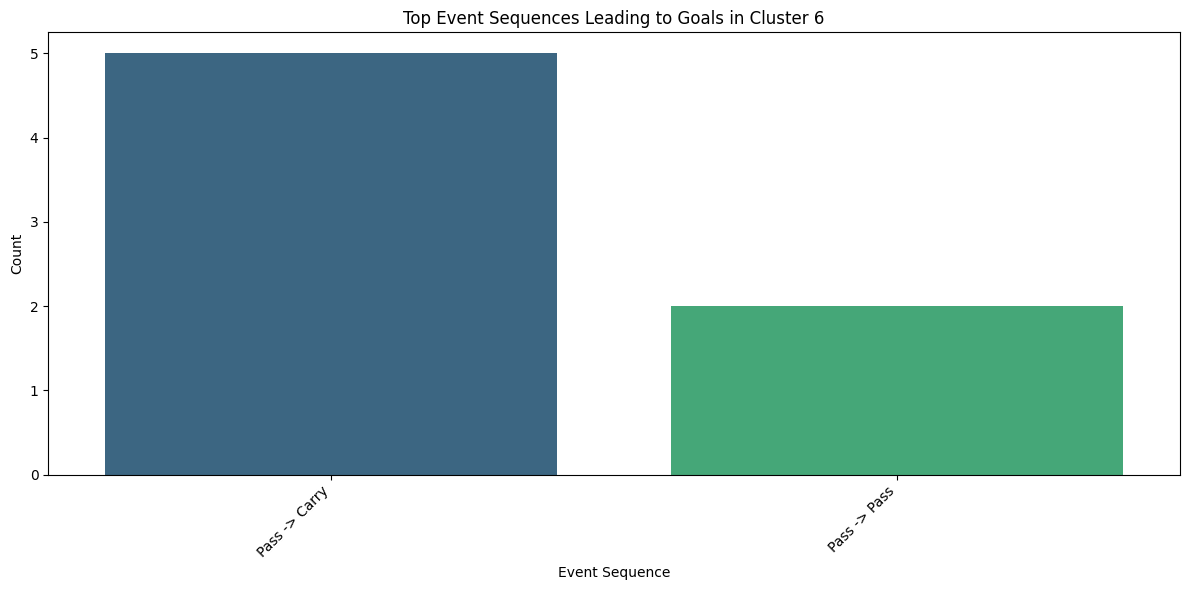

<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




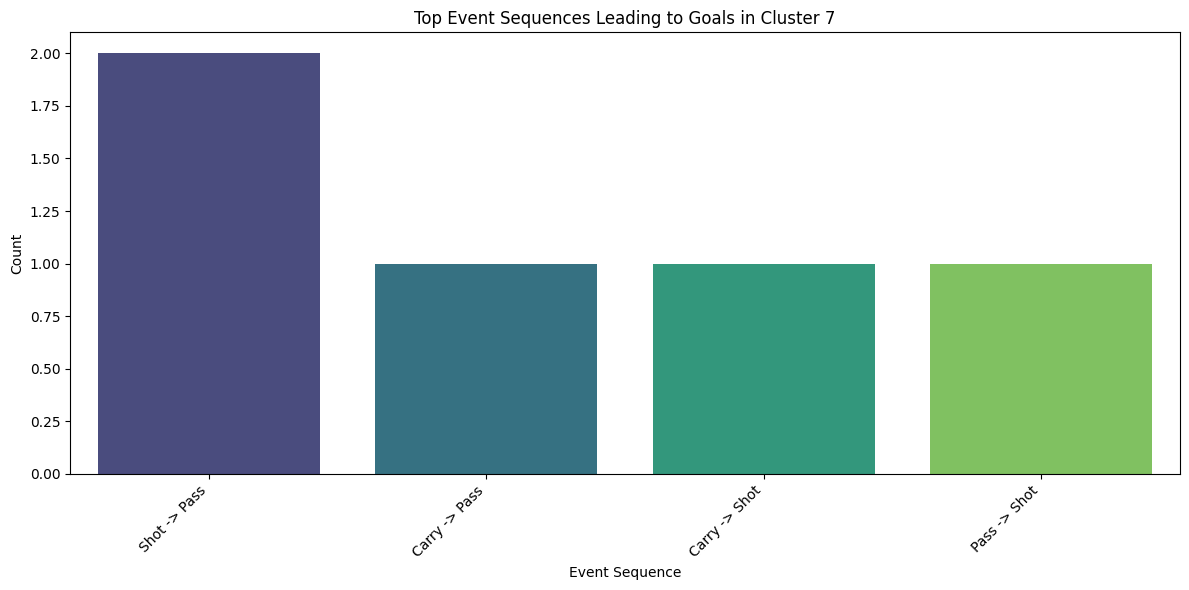

<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




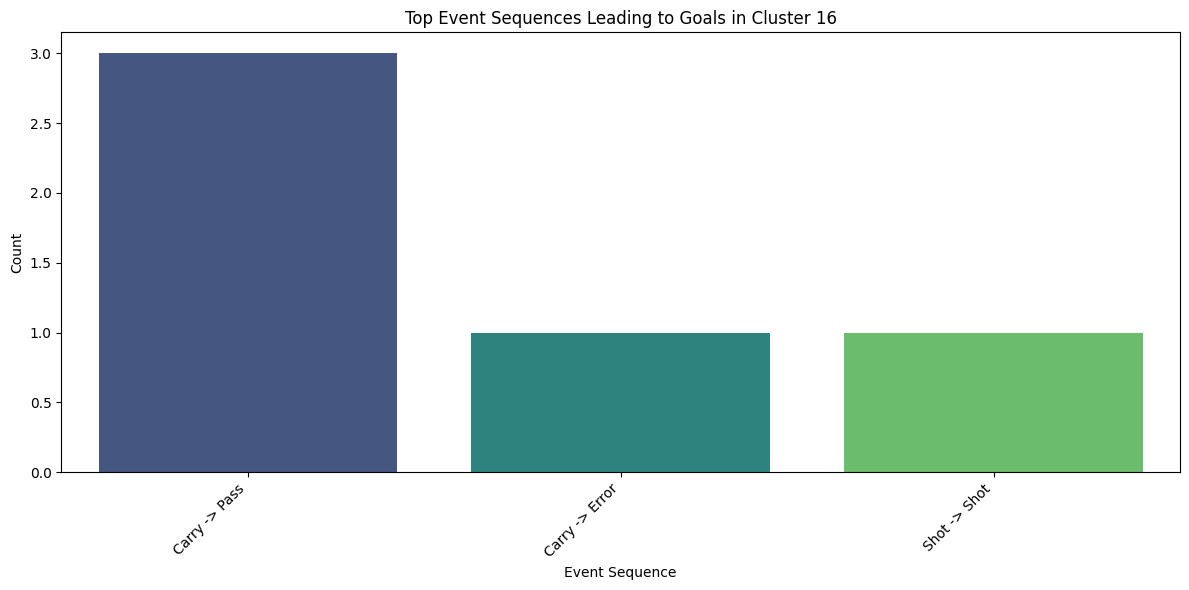

<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




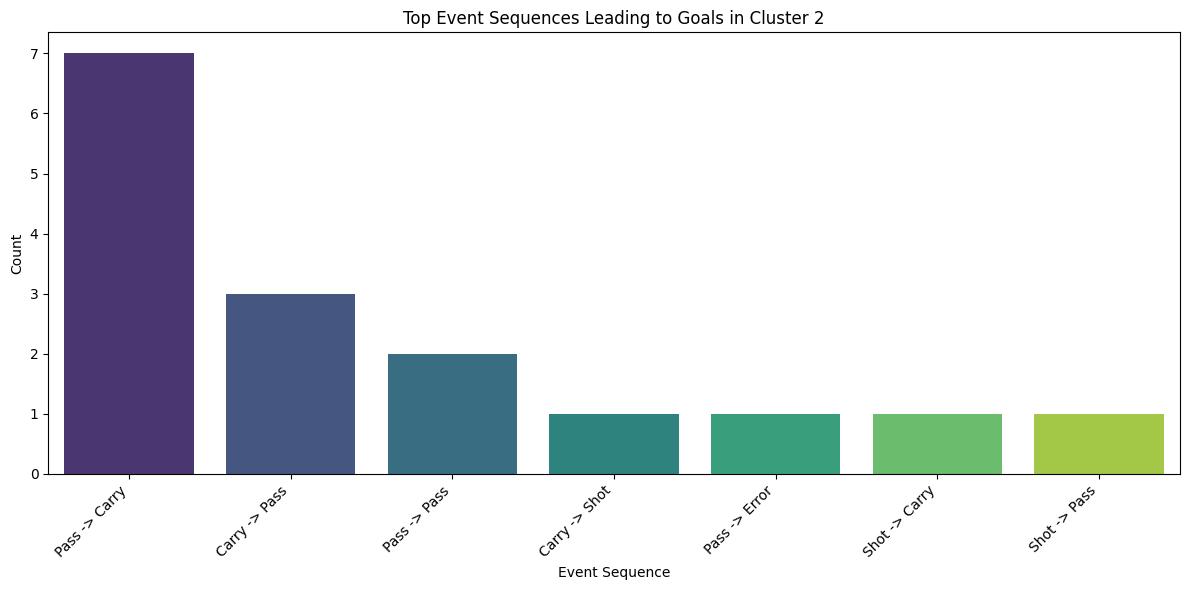

<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




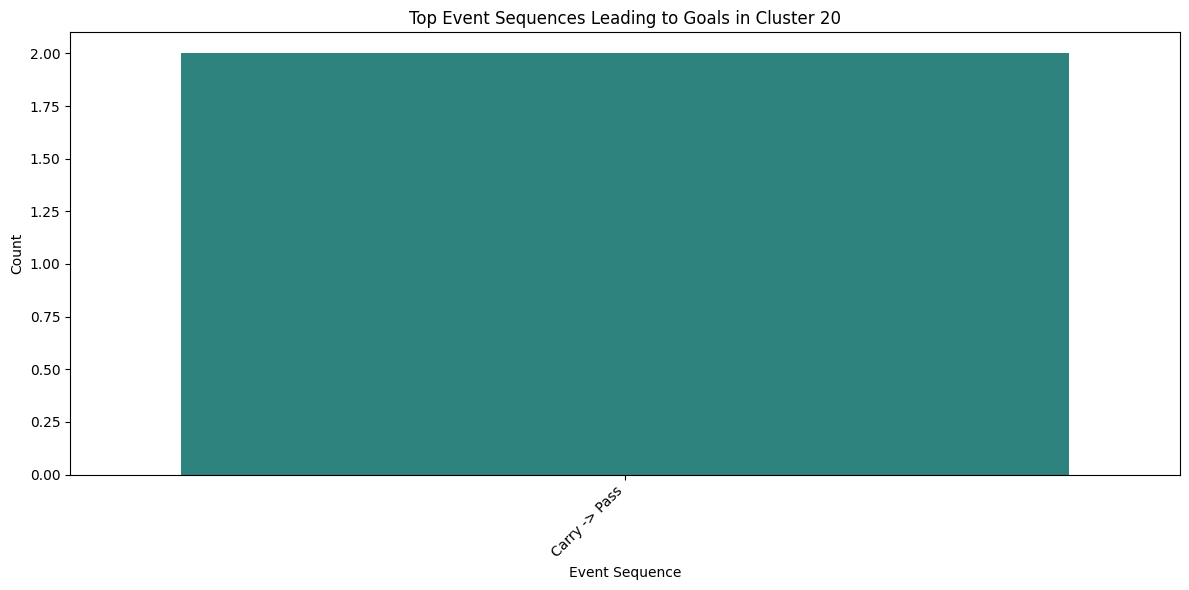

<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




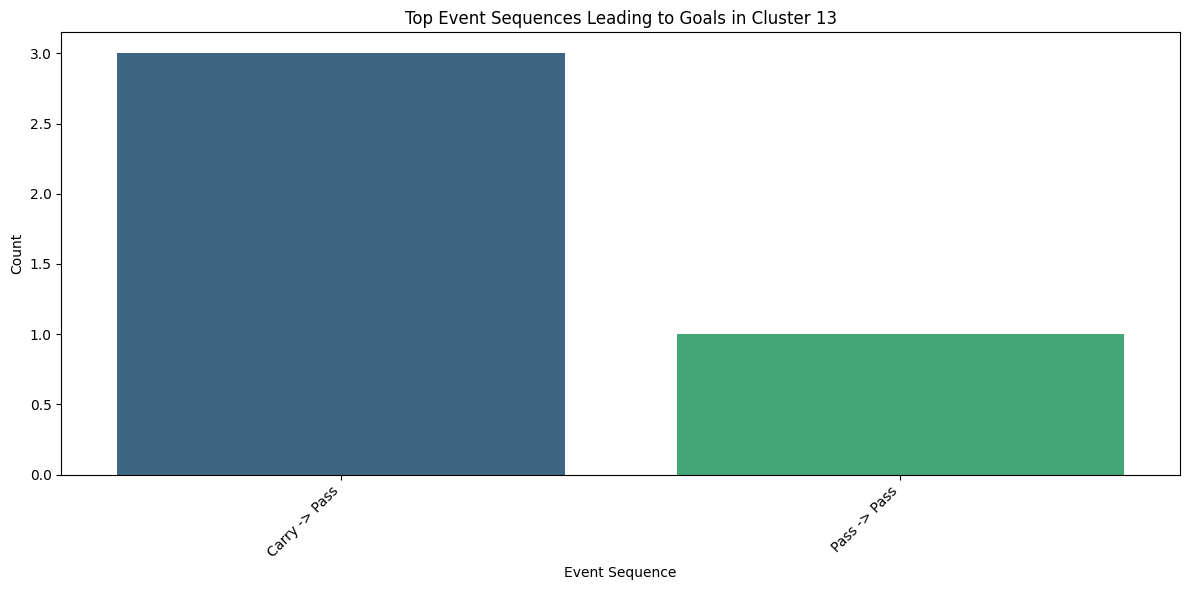

<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




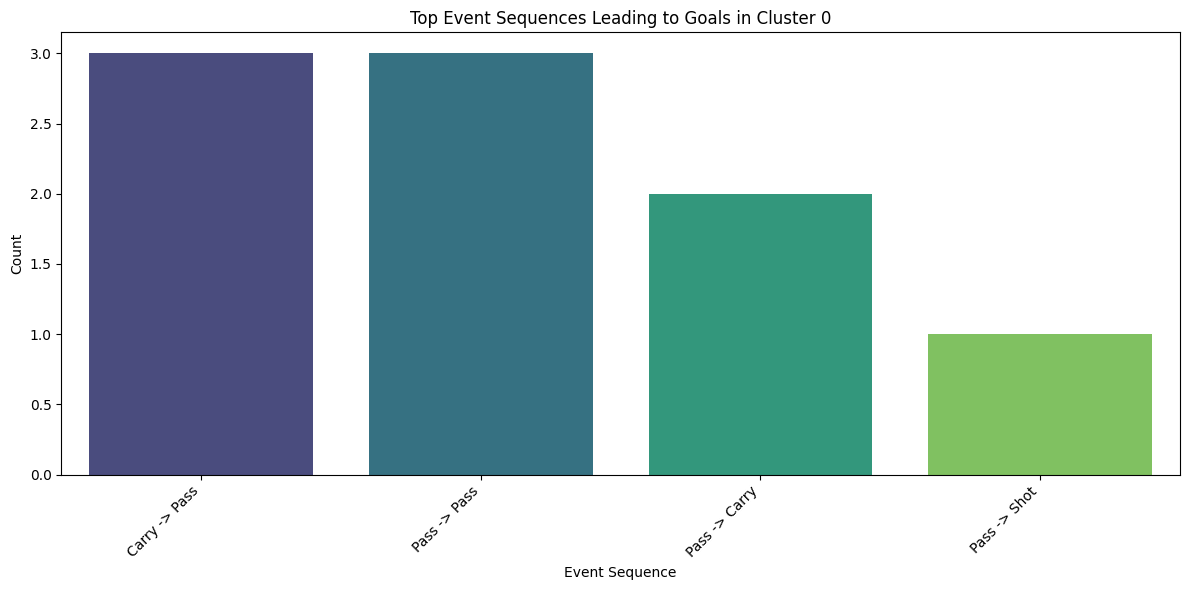

<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




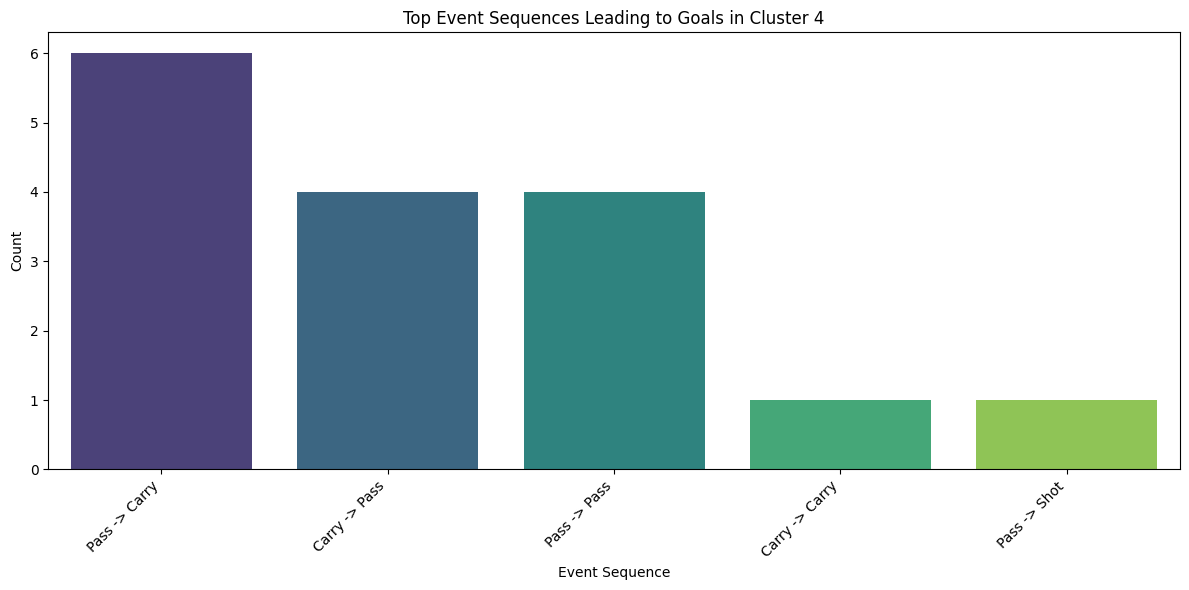

<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




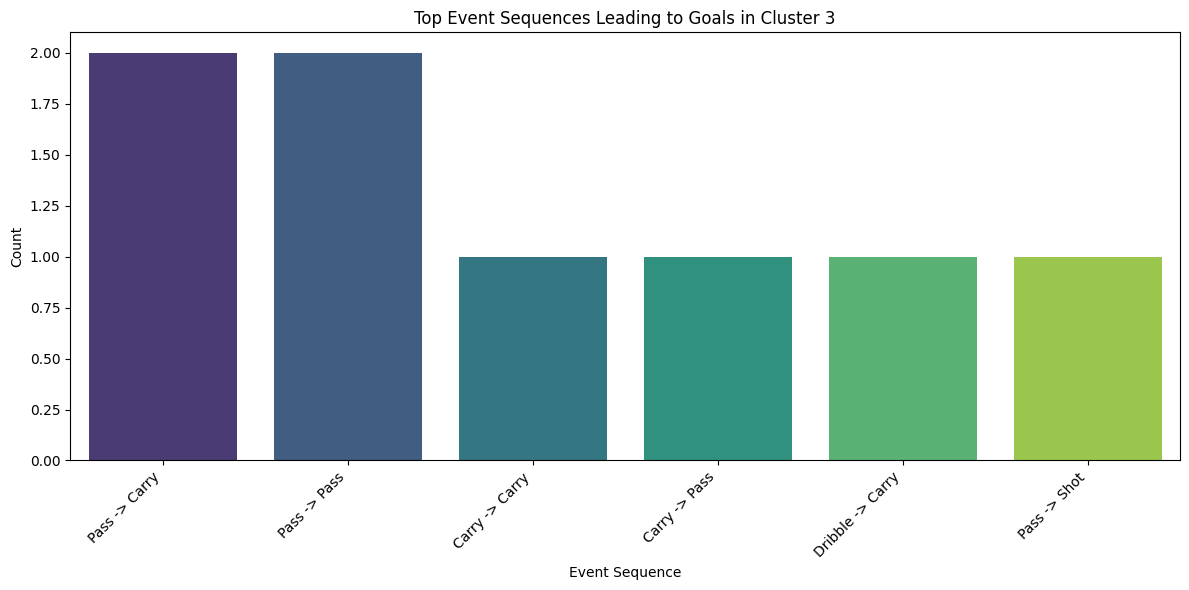

<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




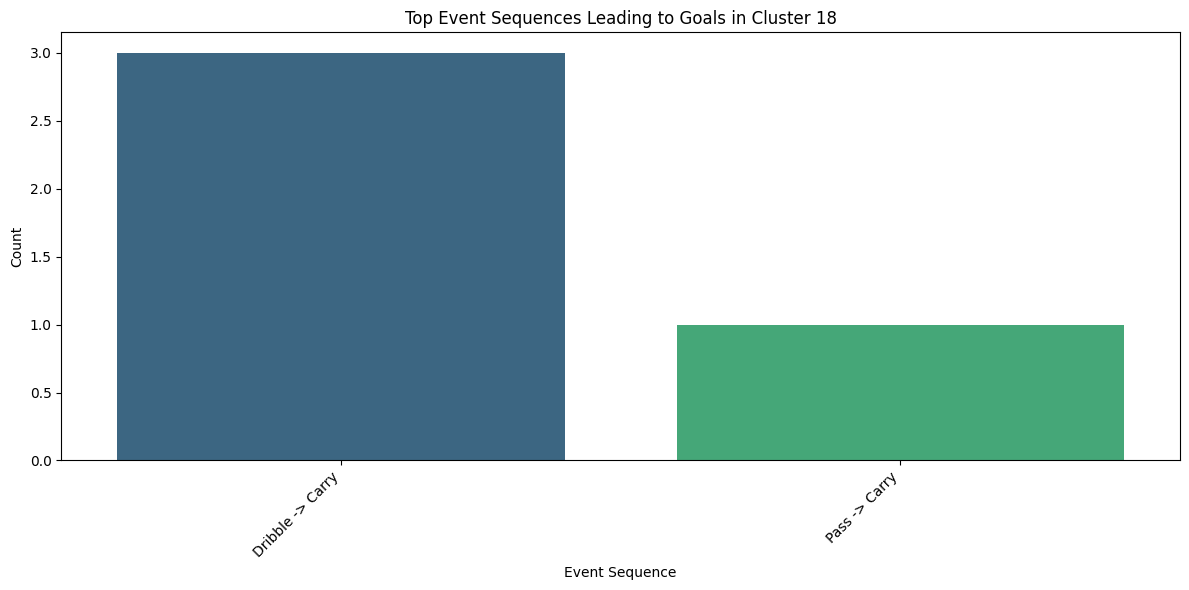

<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




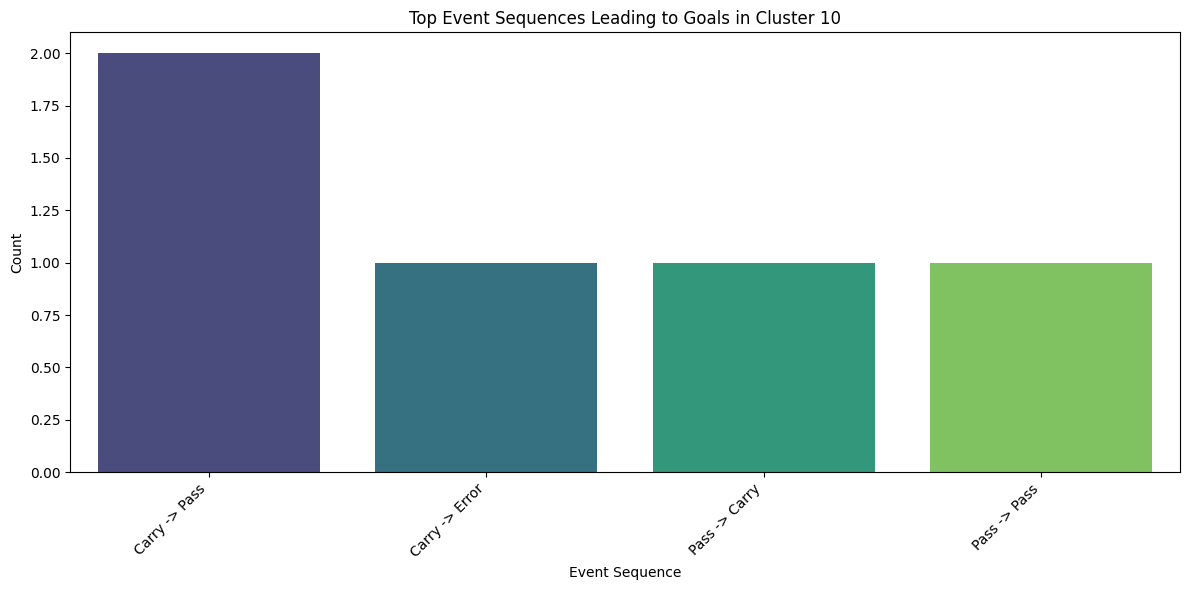

<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




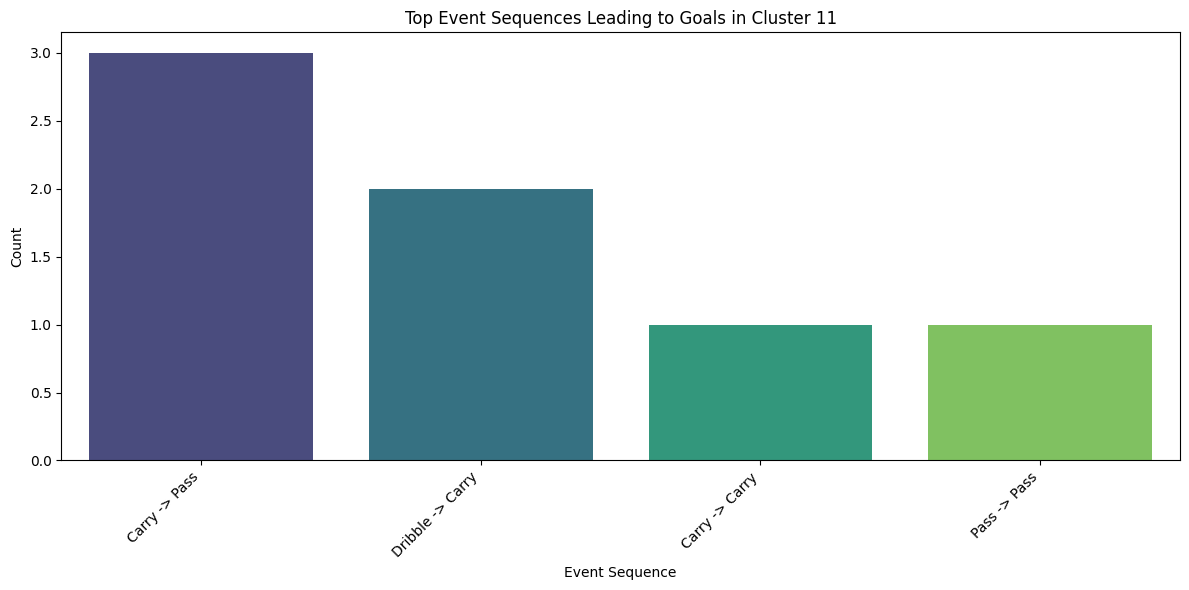

<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




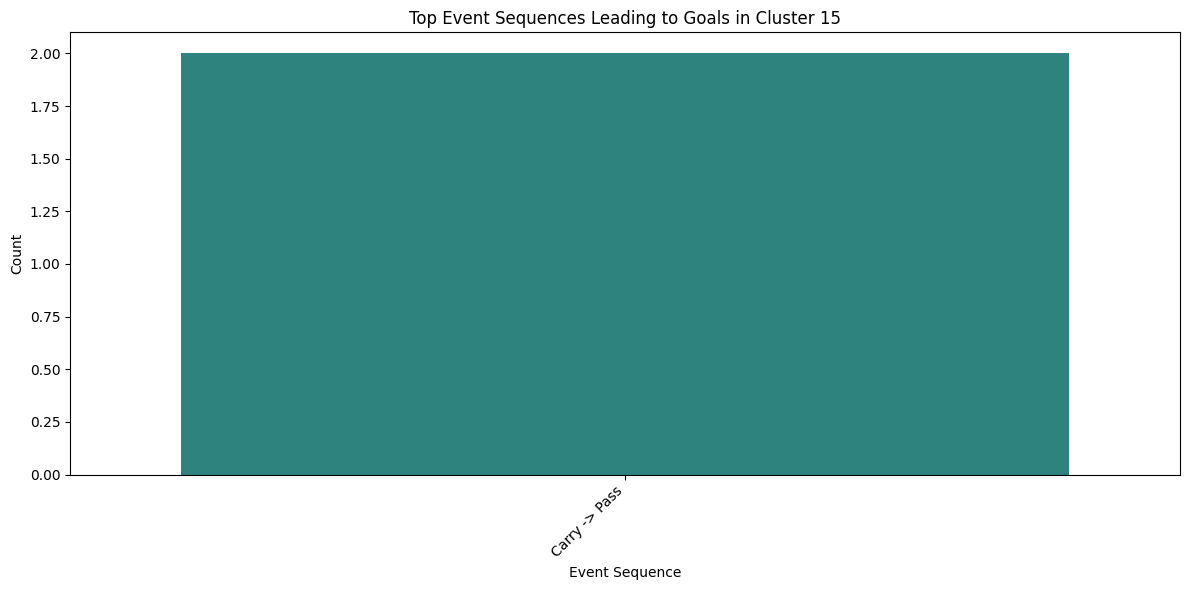

<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




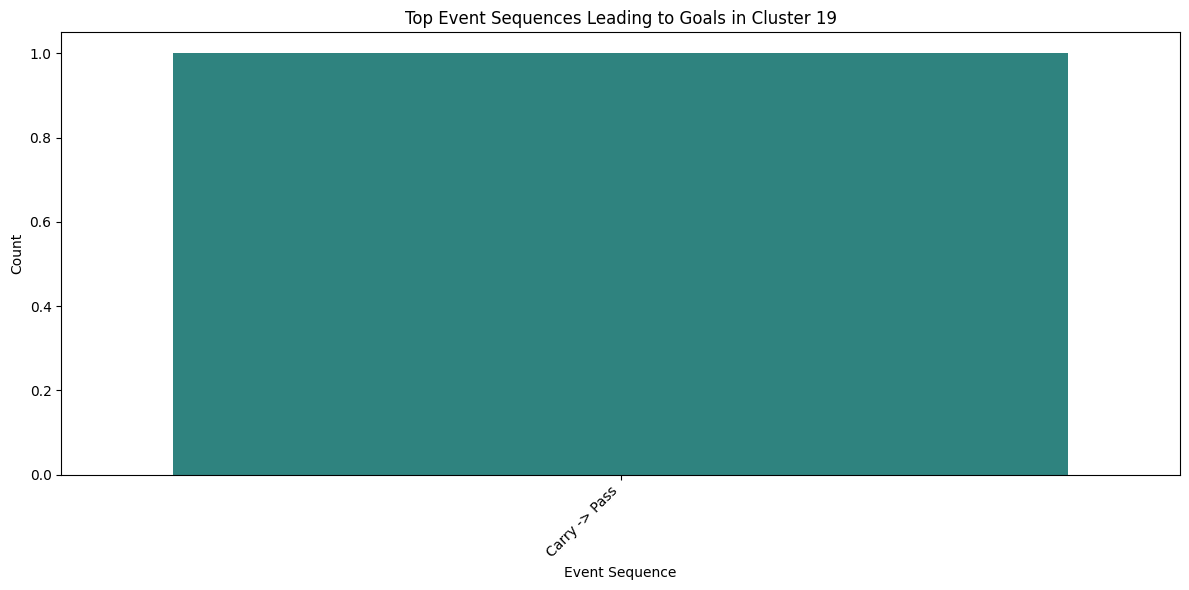

<ipython-input-21-b75e1e63336d>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




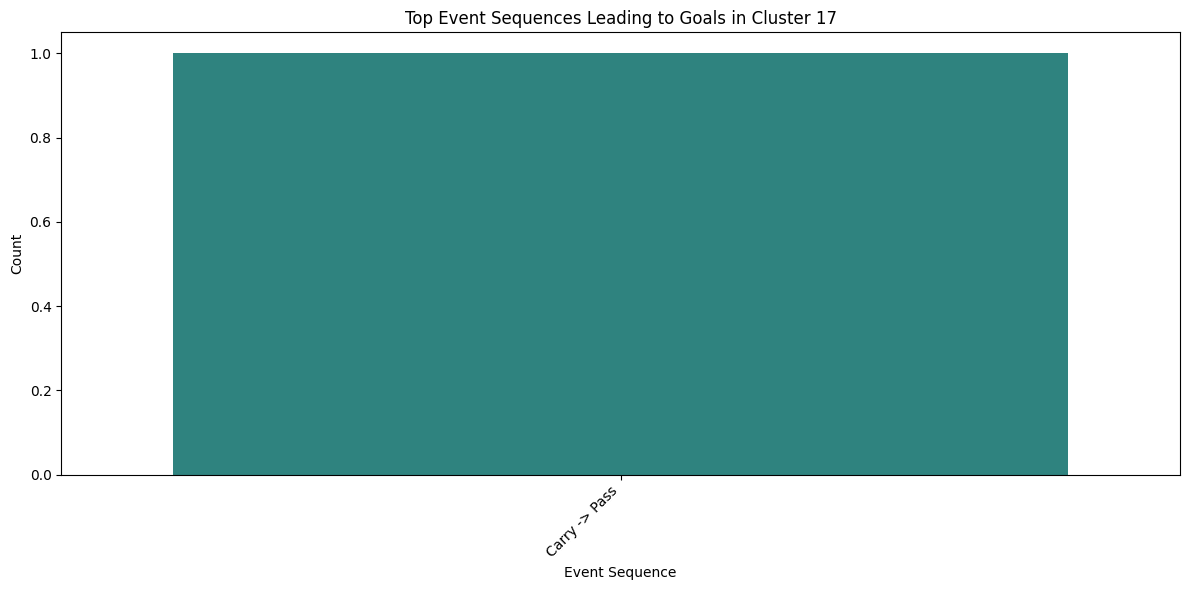

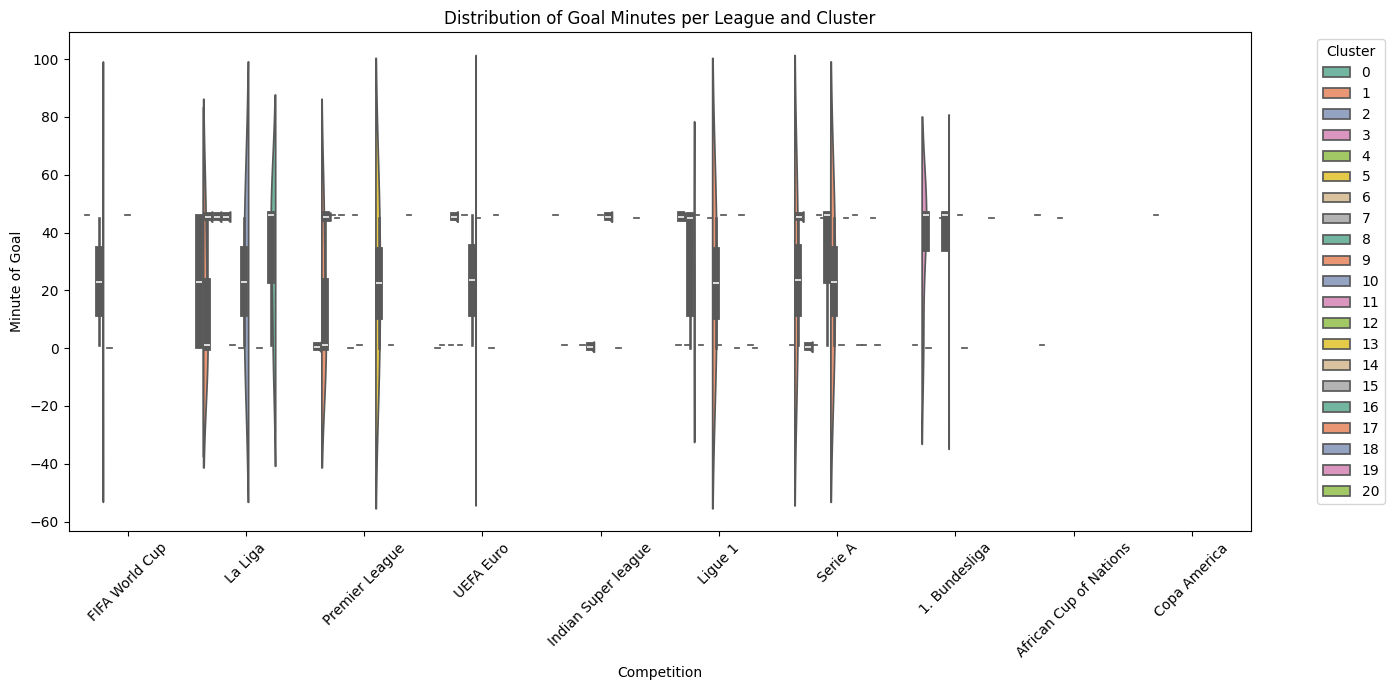

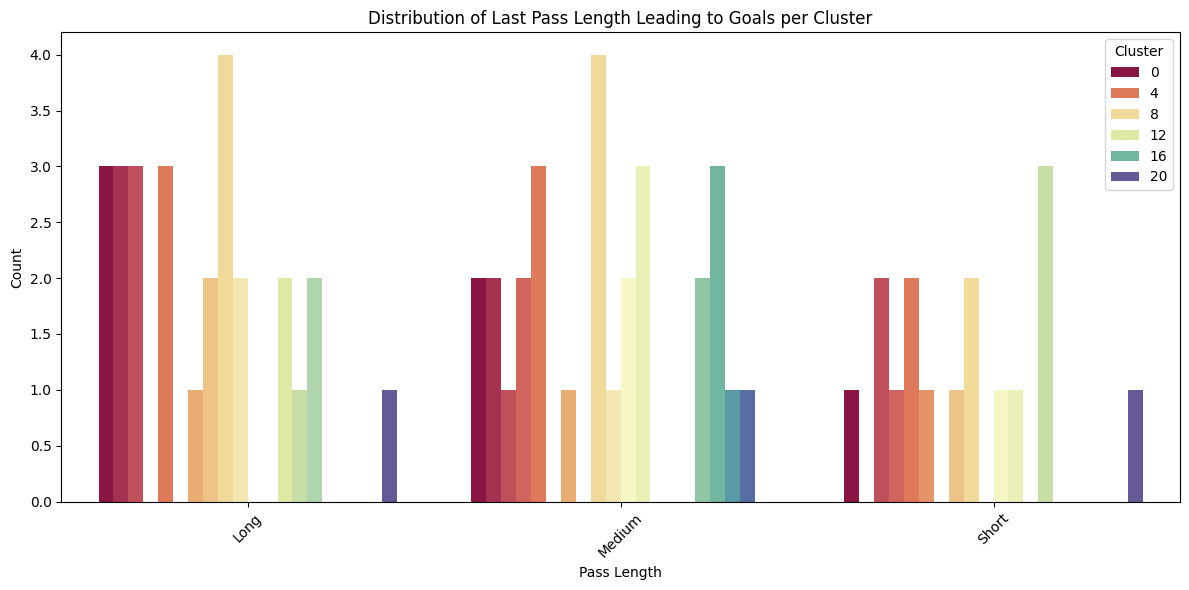

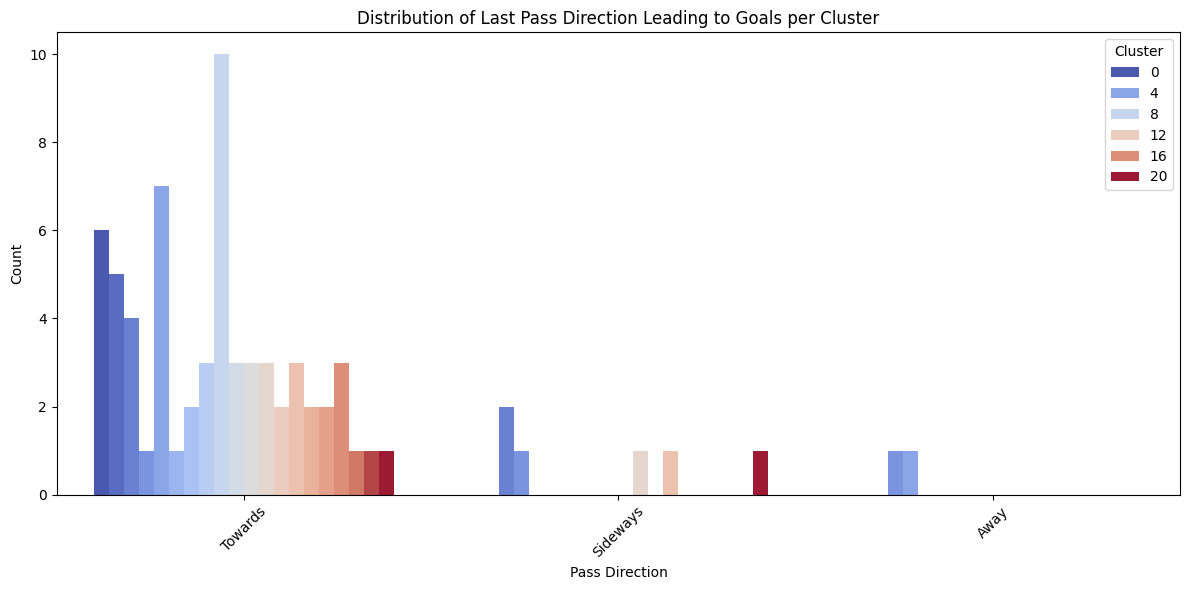

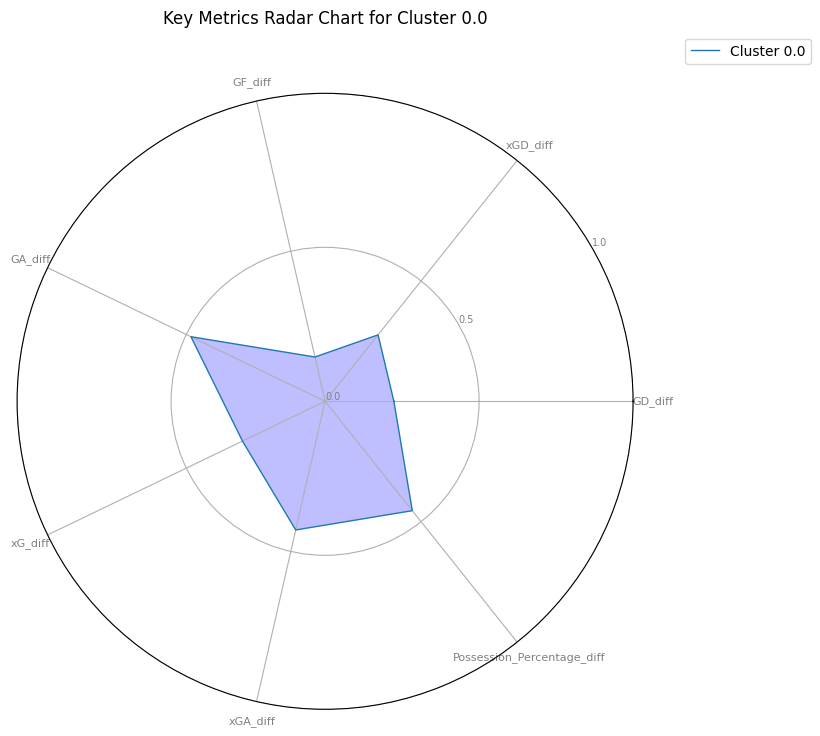

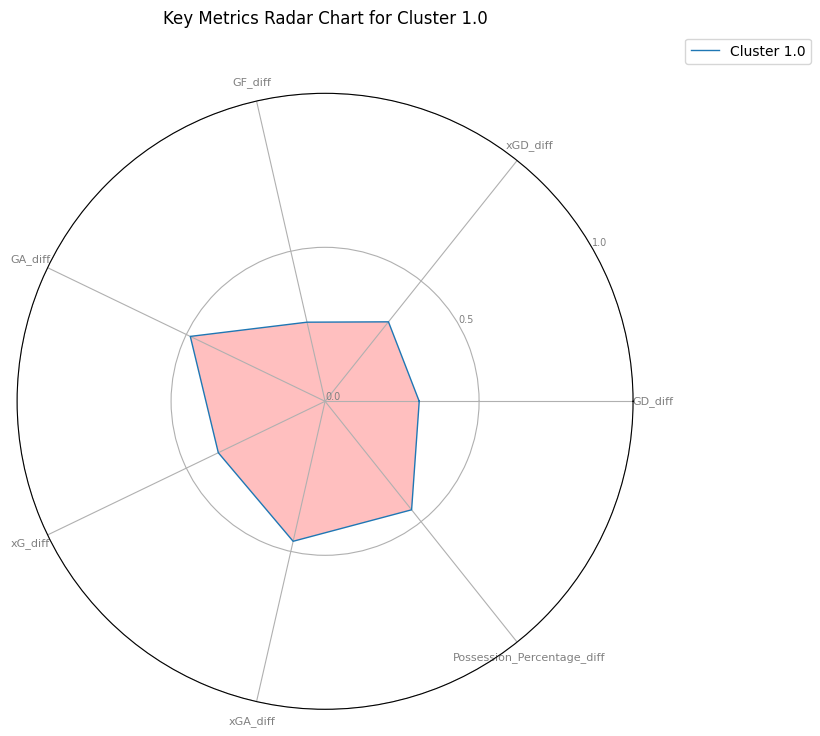

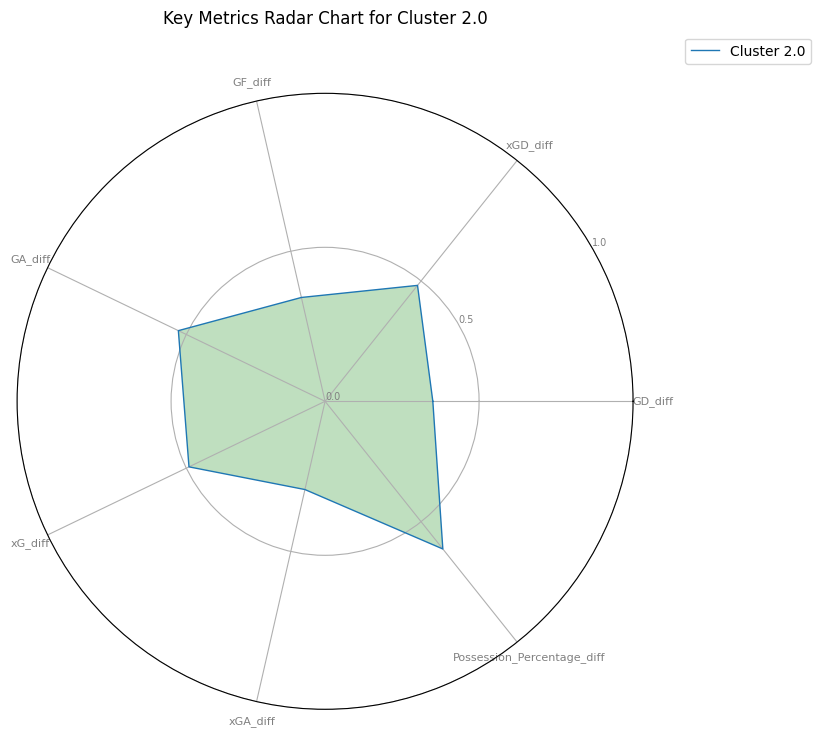

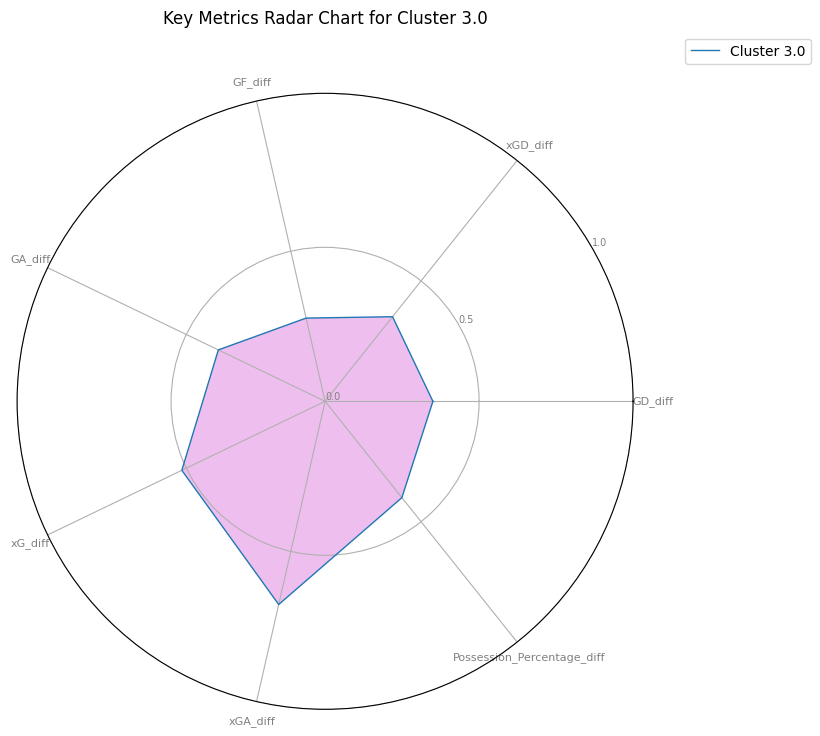

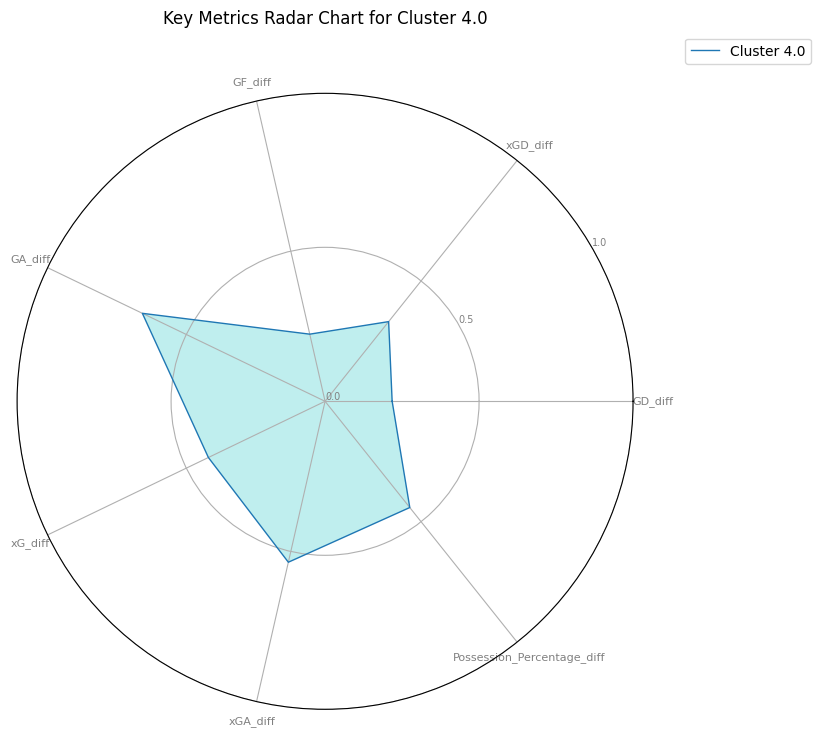

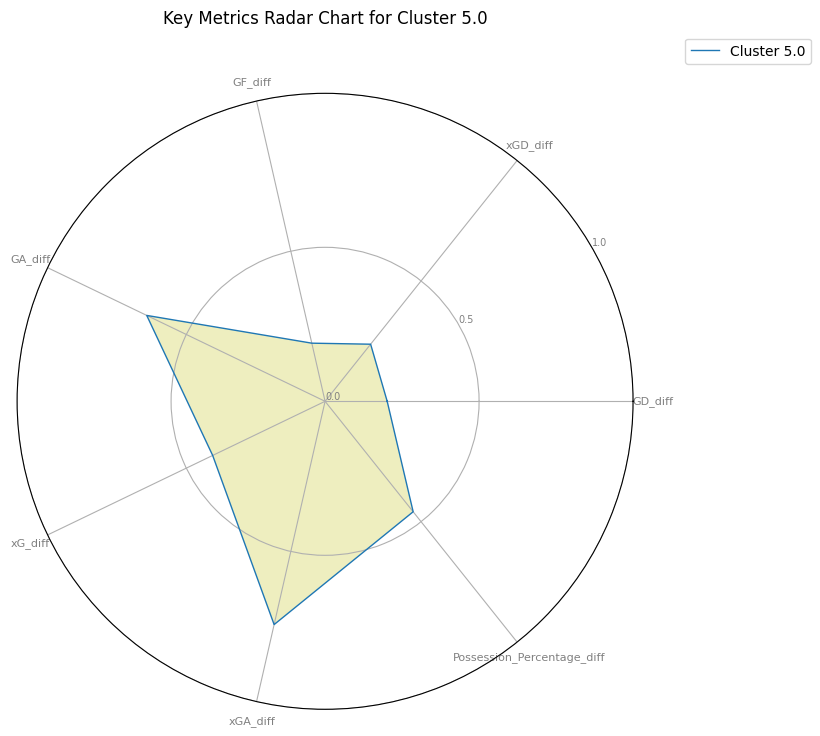

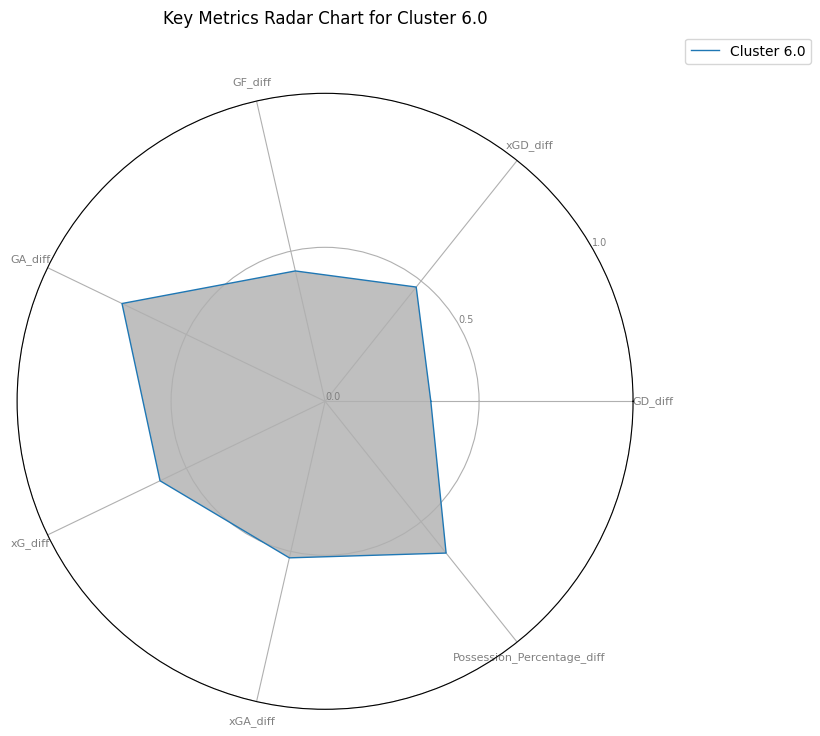

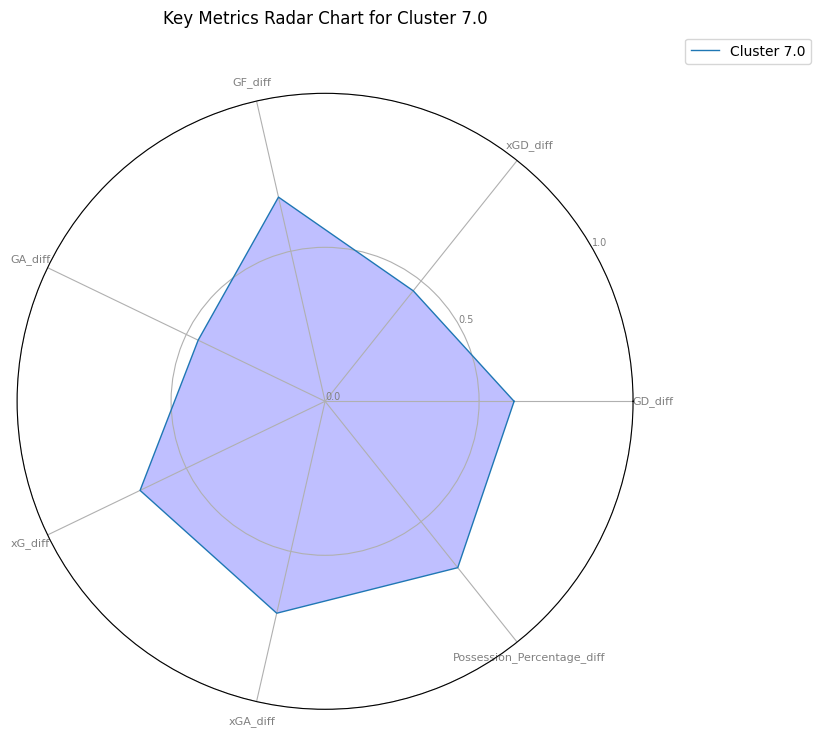

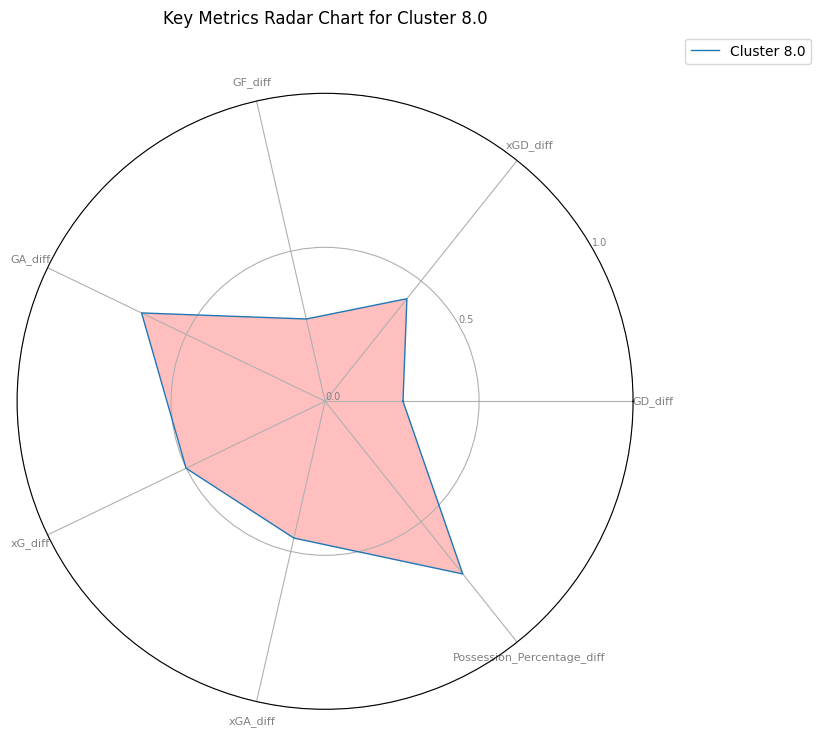

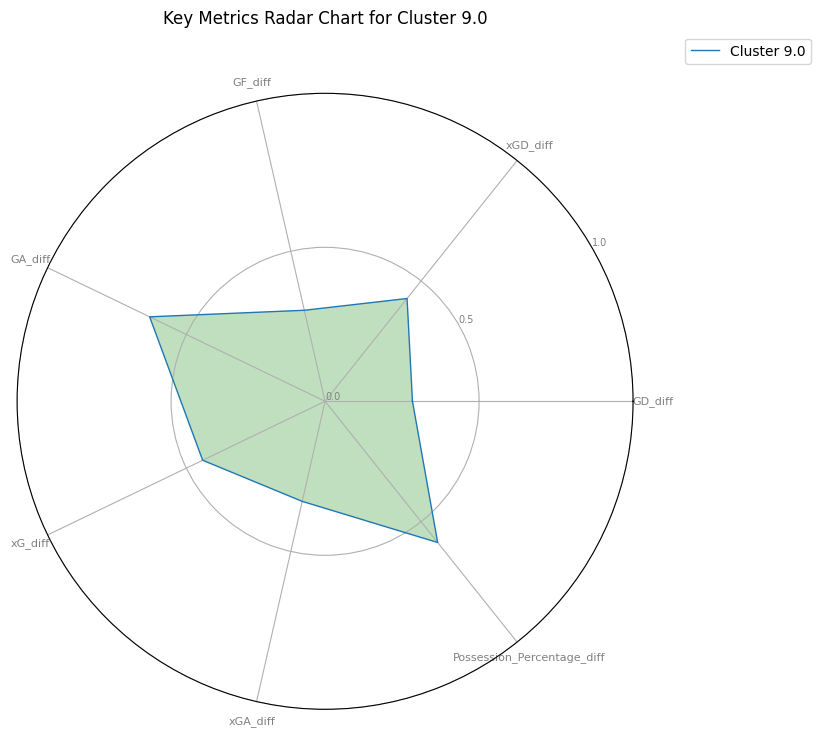

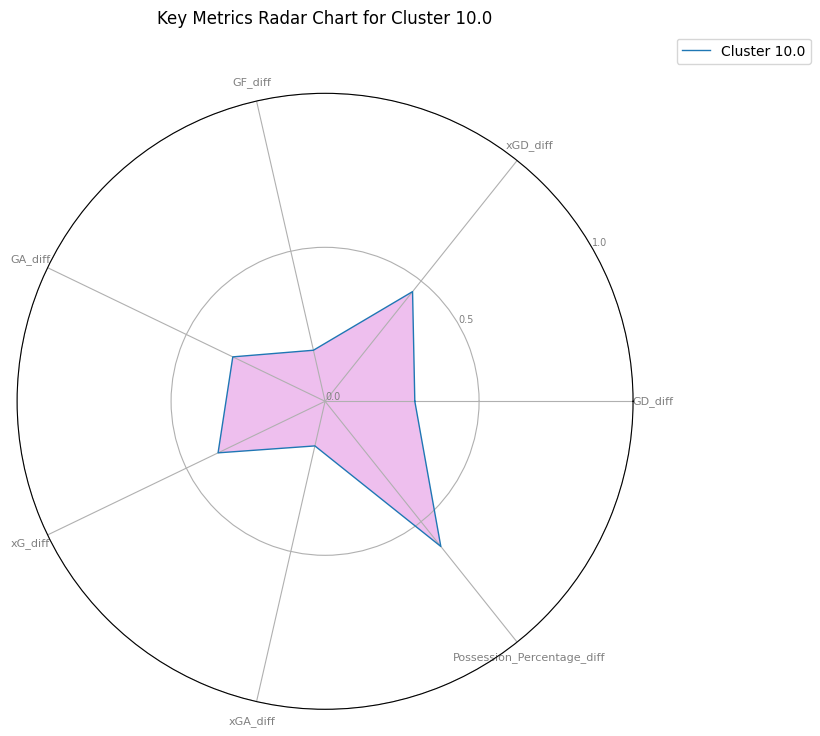

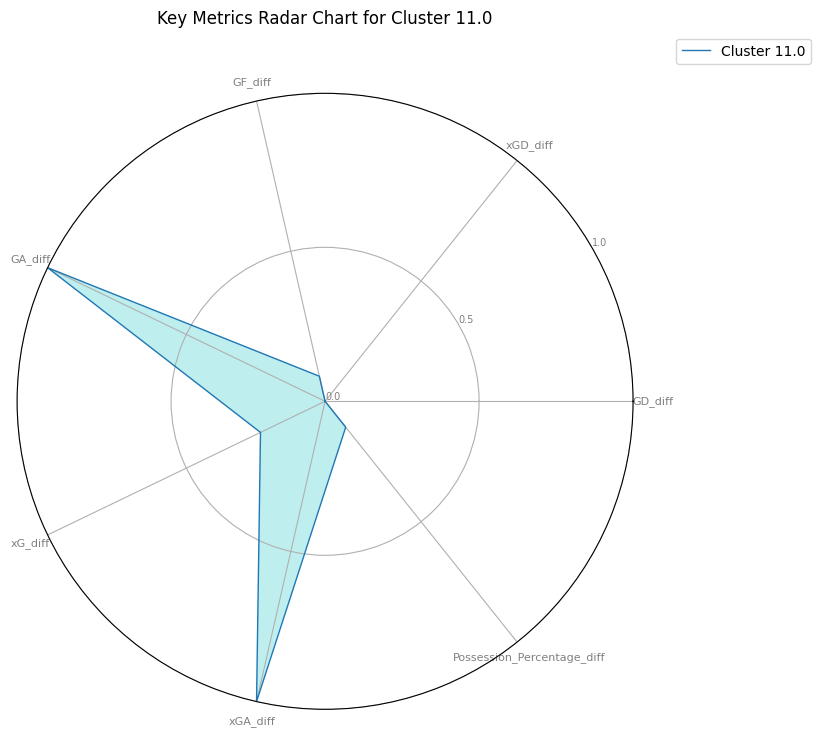

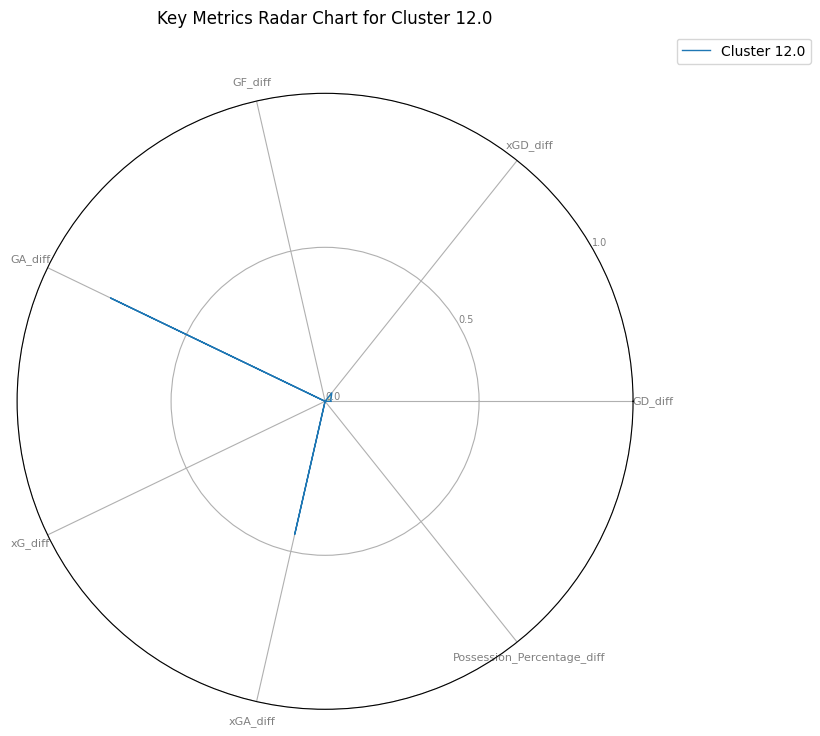

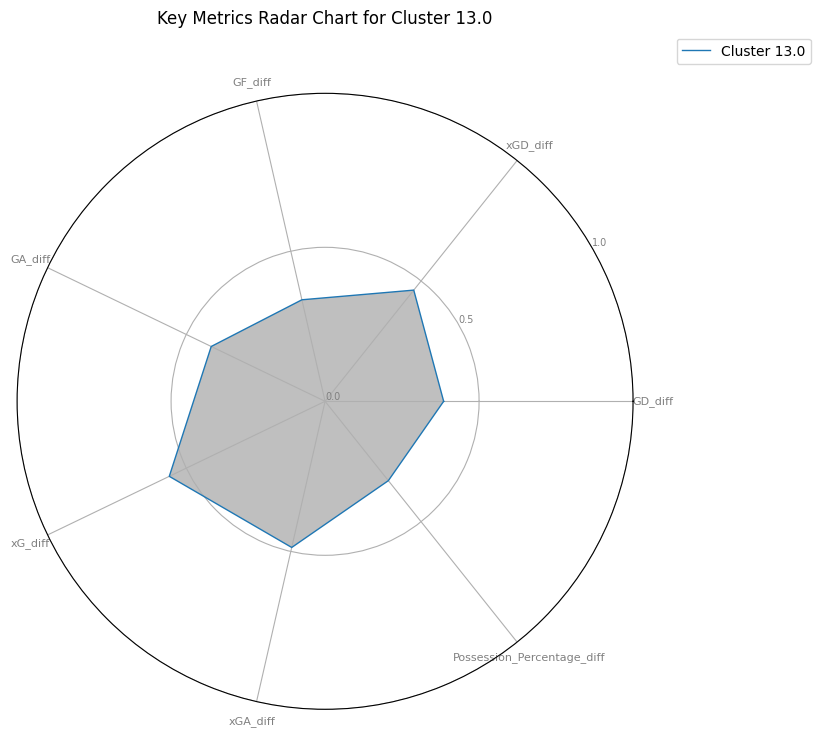

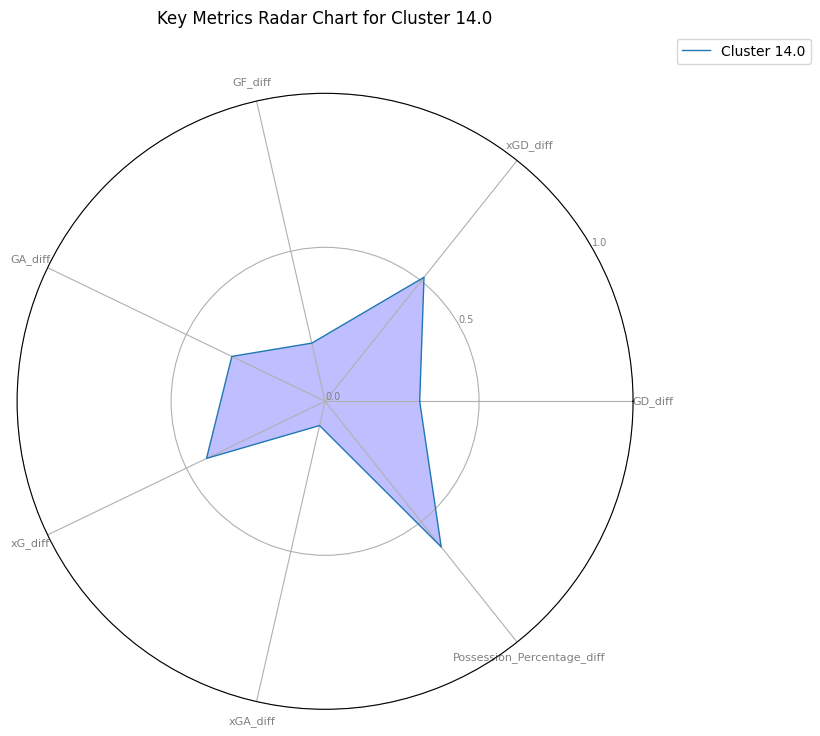

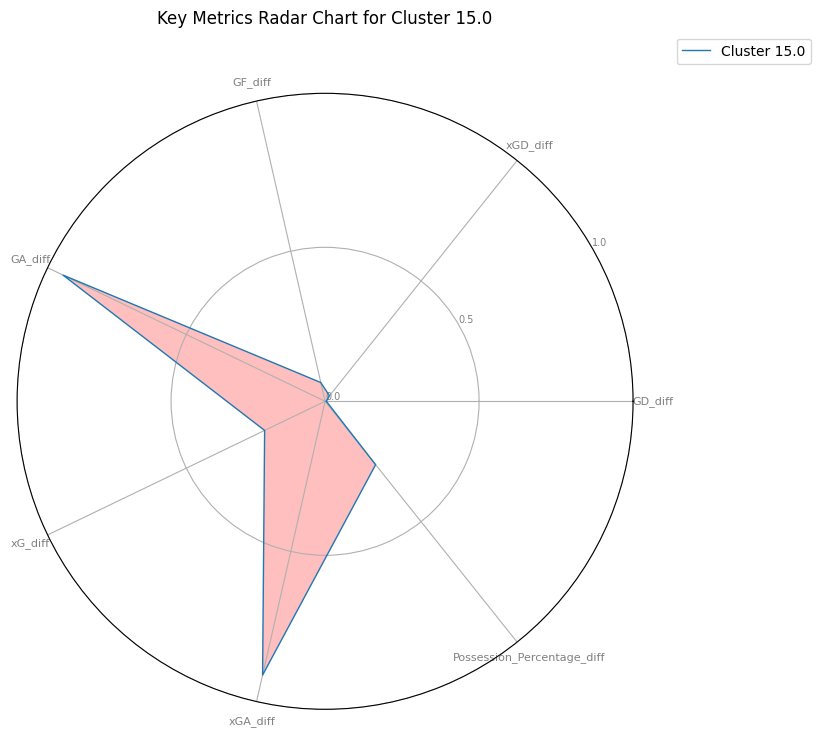

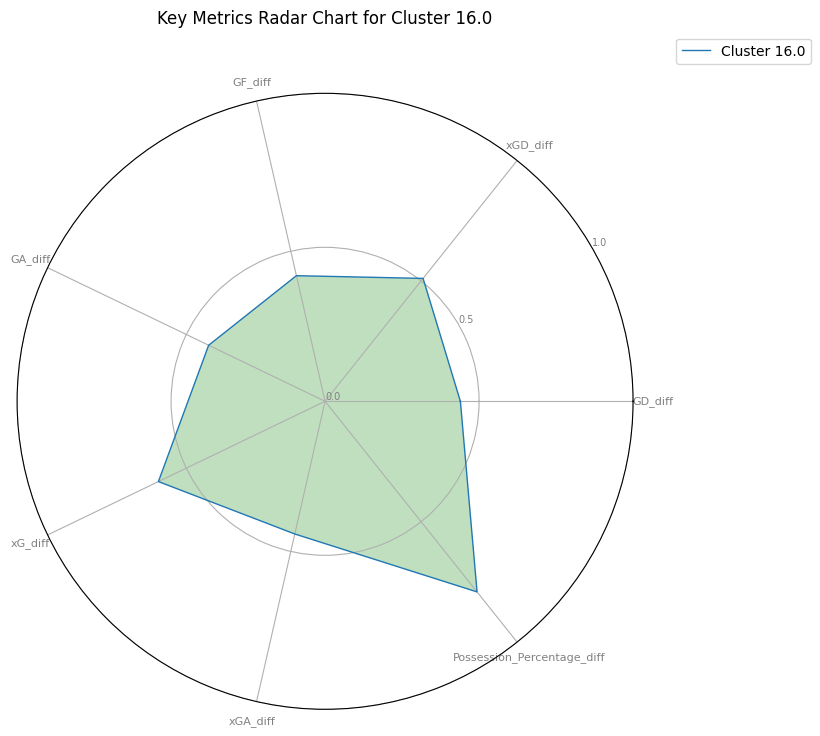

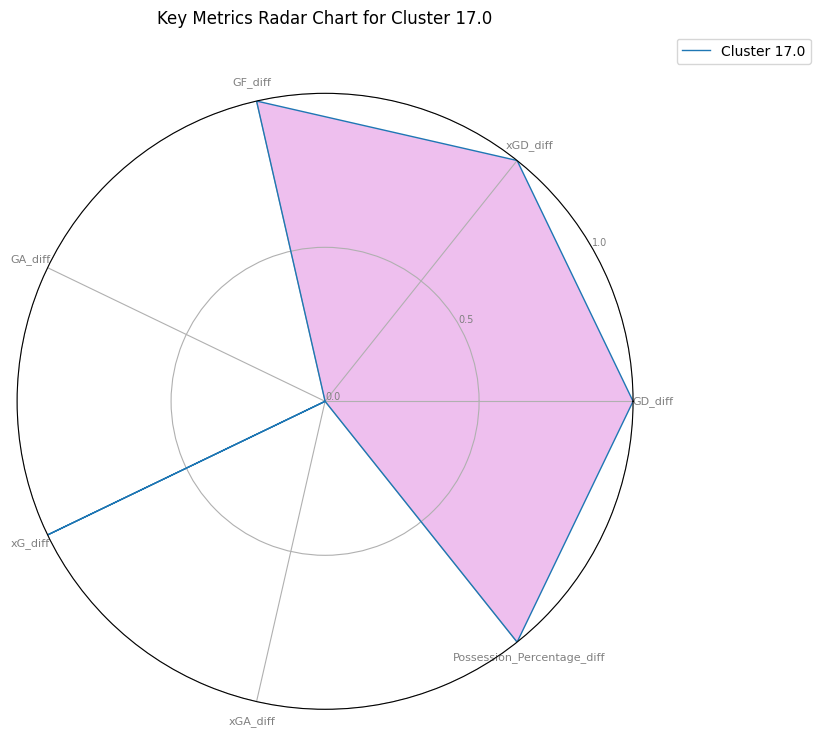

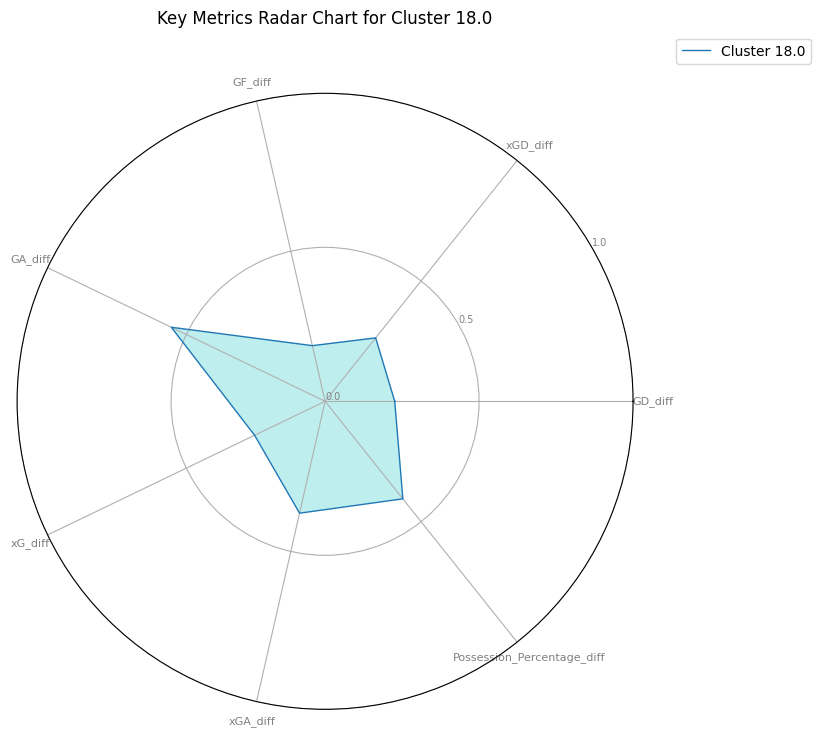

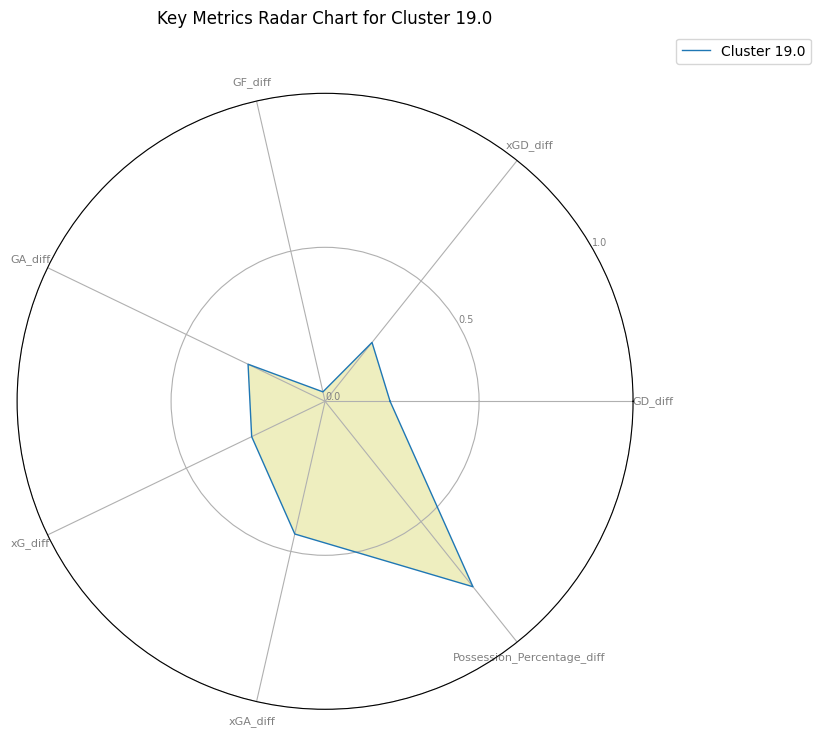

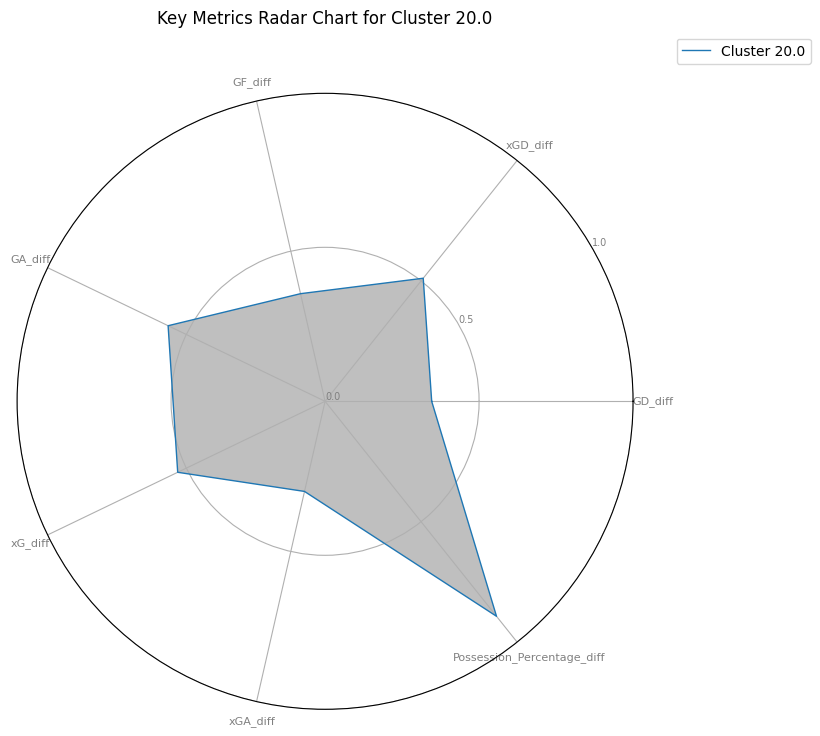

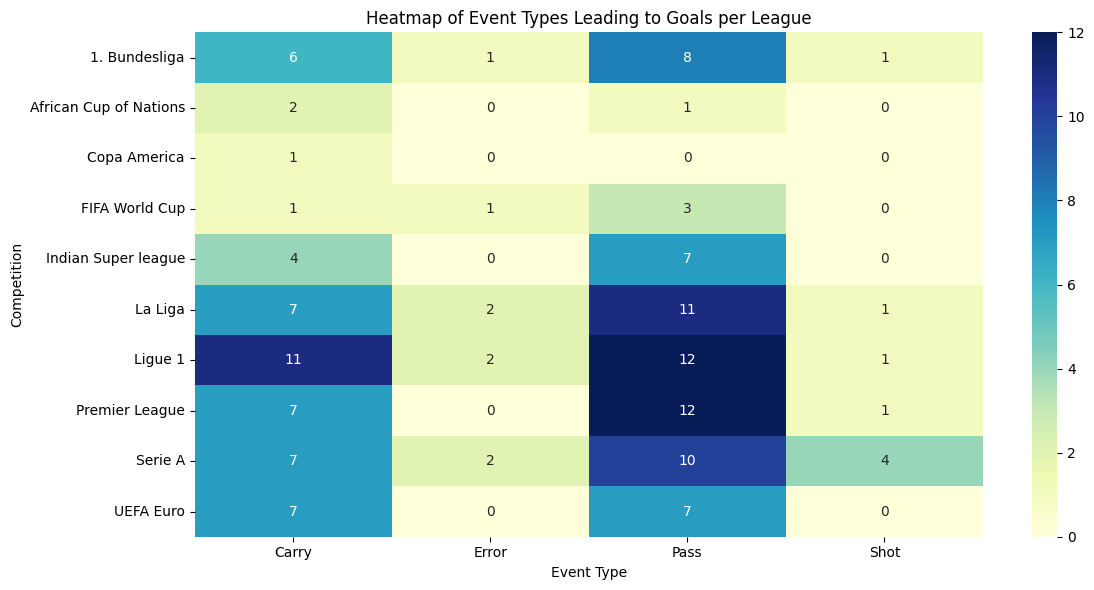

In [21]:
# Analizar la Secuencia de Eventos que Conducen a Goles por Cluster
# Función para extraer tipos de eventos de 'last_event' y 'second_last_event'
def get_event_type(event):
    if isinstance(event, dict):
        return event.get('type')
    return None

# Extraer los tipos de eventos
df['last_event_type'] = df['last_event'].apply(get_event_type)
df['second_last_event_type'] = df['second_last_event'].apply(get_event_type)

# Crear secuencias de eventos
df['event_sequence'] = df['second_last_event_type'].fillna('Start') + ' -> ' + df['last_event_type']

# Contar los eventos de secuencias por cluster
sequence_counts = df.groupby('cluster')['event_sequence'].value_counts().rename('count').reset_index()

# Graficar las secuencias por cluster
for cluster in df['cluster'].unique():
    cluster_sequences = sequence_counts[sequence_counts['cluster'] == cluster].head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=cluster_sequences, x='event_sequence', y='count', palette='viridis')
    plt.title(f'Top Event Sequences Leading to Goals in Cluster {cluster}')
    plt.xlabel('Event Sequence')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Distribución de Minutos de Gol por Liga y Cluster

plt.figure(figsize=(14, 7))
sns.violinplot(data=df, x='comp', y='minute', hue='cluster', split=True, palette='Set2')
plt.title('Distribution of Goal Minutes per League and Cluster')
plt.xlabel('Competition')
plt.ylabel('Minute of Goal')
plt.xticks(rotation=45)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Analizar la Dirección y Longitud de los Pases que Conducen a Goles por Cluster
# Funciones para extraer atributos de los pases
def get_pass_attribute(event, attribute):
    if isinstance(event, dict) and event.get('type') == 'Pass':
        return event.get(attribute)
    return None

# Extraer atributos de pases
df['last_pass_length'] = df['last_event'].apply(lambda x: get_pass_attribute(x, 'length'))
df['last_pass_direction'] = df['last_event'].apply(lambda x: get_pass_attribute(x, 'direction'))

# Distribución de longitud de pase por cluster
pass_length_counts = df.groupby('cluster')['last_pass_length'].value_counts().rename('count').reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=pass_length_counts, x='last_pass_length', y='count', hue='cluster', palette='Spectral')
plt.title('Distribution of Last Pass Length Leading to Goals per Cluster')
plt.xlabel('Pass Length')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Distribución de dirección de pase por cluster
pass_direction_counts = df.groupby('cluster')['last_pass_direction'].value_counts().rename('count').reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=pass_direction_counts, x='last_pass_direction', y='count', hue='cluster', palette='coolwarm')
plt.title('Distribution of Last Pass Direction Leading to Goals per Cluster')
plt.xlabel('Pass Direction')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Gráfico de Radar de Métricas Clave por Cluster
from math import pi
from sklearn.preprocessing import MinMaxScaler

# Métricas clave a incluir
radar_metrics = ['GD_diff', 'xGD_diff', 'GF_diff', 'GA_diff', 'xG_diff', 'xGA_diff', 'Possession_Percentage_diff']

# Asegurar tipos numéricos y manejar valores faltantes
for metric in radar_metrics:
    df[metric] = pd.to_numeric(df[metric], errors='coerce')
df.fillna(0, inplace=True)

# Calcular las métricas promedio por cluster
cluster_metrics = df.groupby('cluster')[radar_metrics].mean().reset_index()

# Normalizar los datos
scaler = MinMaxScaler()
cluster_metrics[radar_metrics] = scaler.fit_transform(cluster_metrics[radar_metrics])

# Función para crear gráfico de radar
def make_radar_chart(row, title, color):
    categories = radar_metrics
    N = len(categories)
    values = row[categories].values.flatten().tolist()
    values += values[:1]  # Repetir el primer valor para cerrar el círculo
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.set_rlabel_position(30)
    plt.yticks([0.0, 0.5, 1.0], ["0.0", "0.5", "1.0"], color="grey", size=7)
    plt.ylim(0, 1)
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {row["cluster"]}')
    ax.fill(angles, values, color, alpha=0.25)
    plt.title(title, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# Crear gráfico de radar para cada cluster
colors = ['b', 'r', 'g', 'm', 'c', 'y', 'k']
for idx, row in cluster_metrics.iterrows():
    make_radar_chart(row, f'Key Metrics Radar Chart for Cluster {row["cluster"]}', colors[idx % len(colors)])

# Mapa de Calor de Tipos de Eventos que Conducen a Goles por Liga
# Conteo de tipos de eventos que conducen a goles por liga
event_type_counts_league = df.groupby('comp')['last_event_type'].value_counts().rename('count').reset_index()

# Crear tabla dinámica
event_type_pivot = event_type_counts_league.pivot(index='comp', columns='last_event_type', values='count').fillna(0)

# Graficar el mapa de calor
plt.figure(figsize=(12, 6))
sns.heatmap(event_type_pivot, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Heatmap of Event Types Leading to Goals per League')
plt.xlabel('Event Type')
plt.ylabel('Competition')
plt.tight_layout()
plt.show()



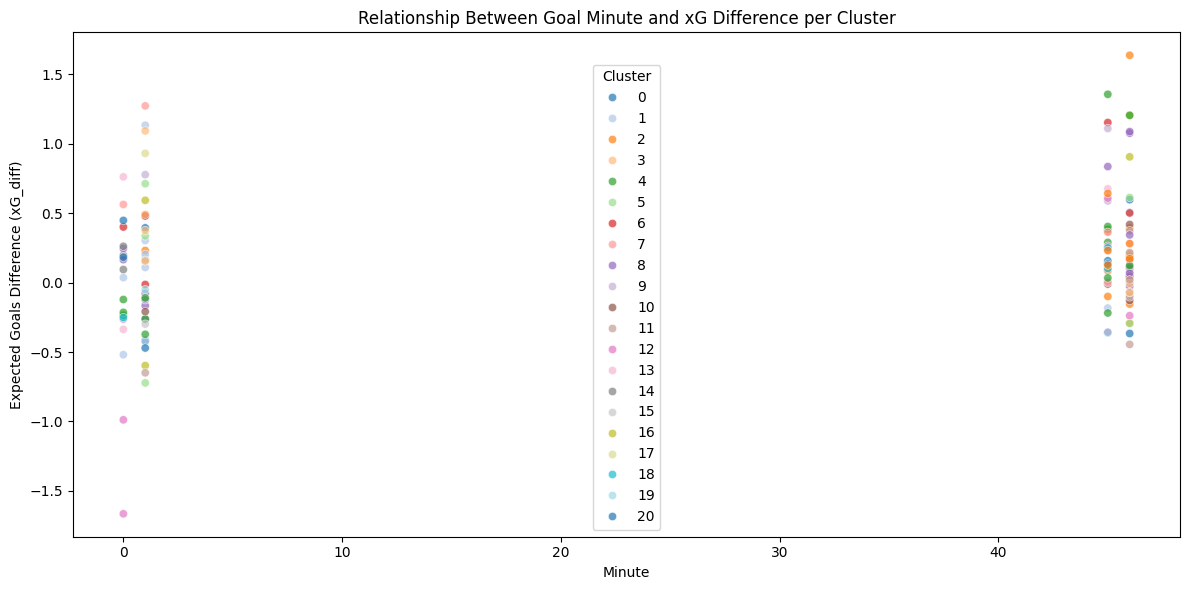

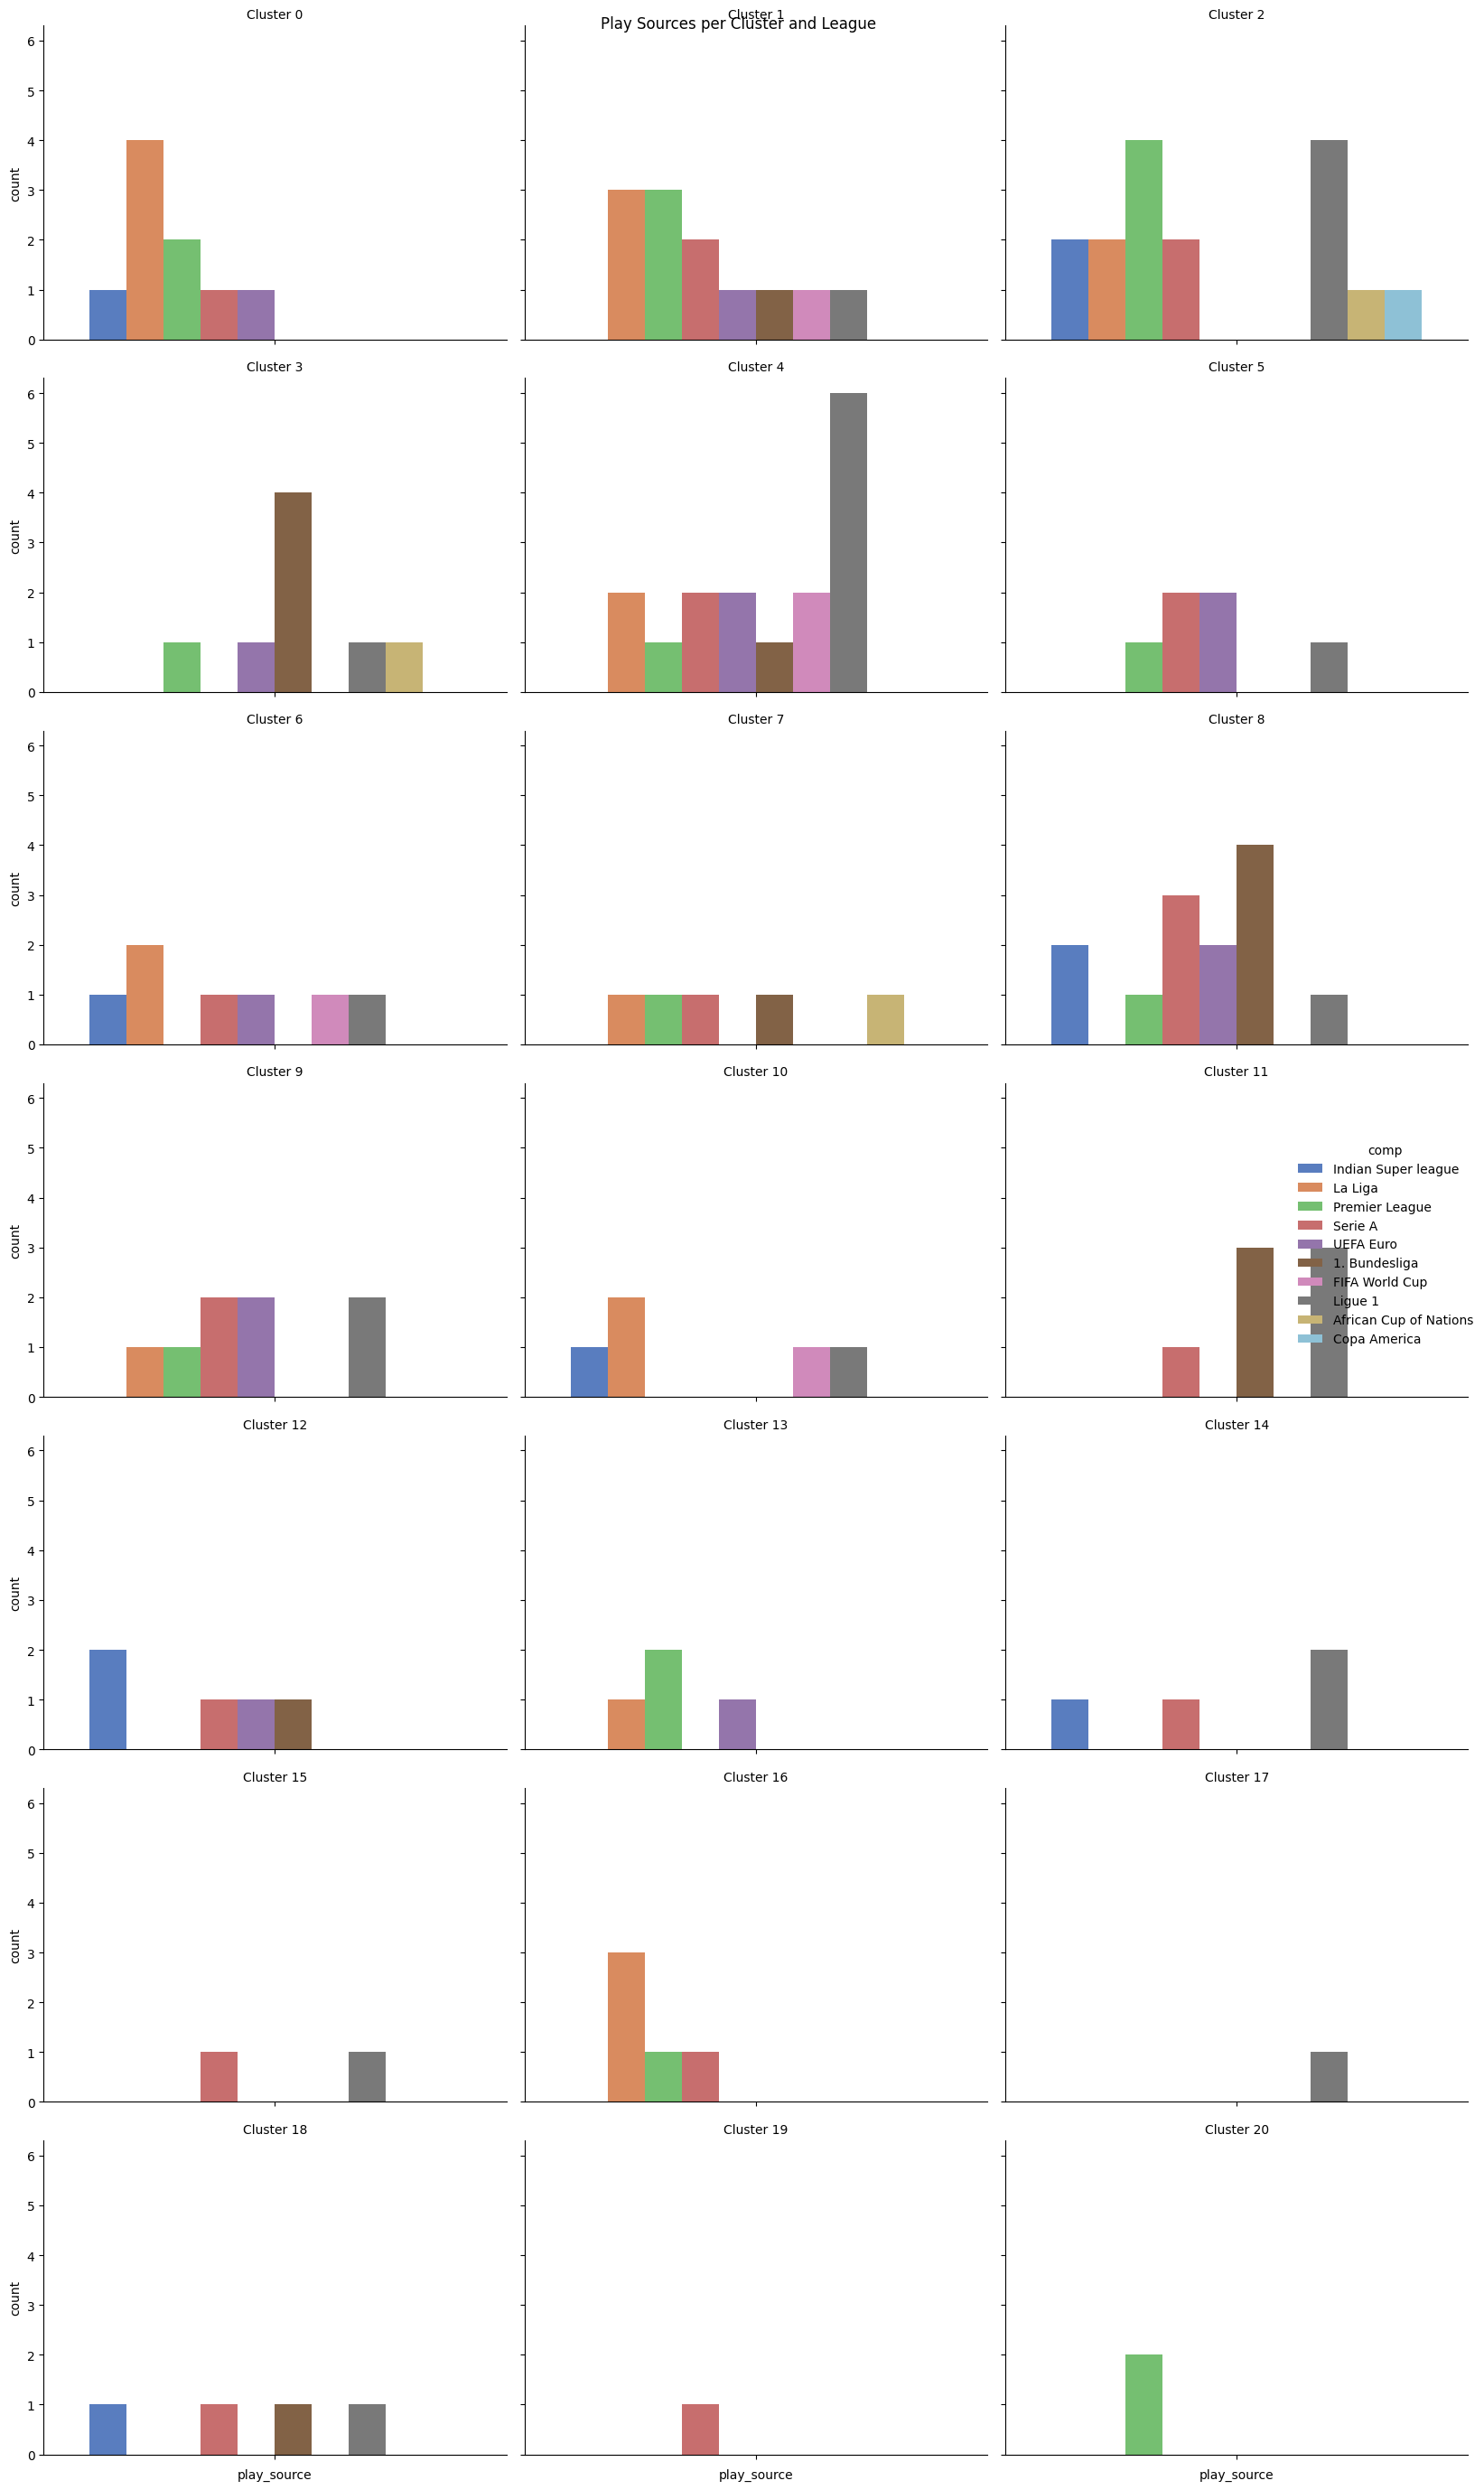

<ipython-input-22-15369d4a6d95>:48: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




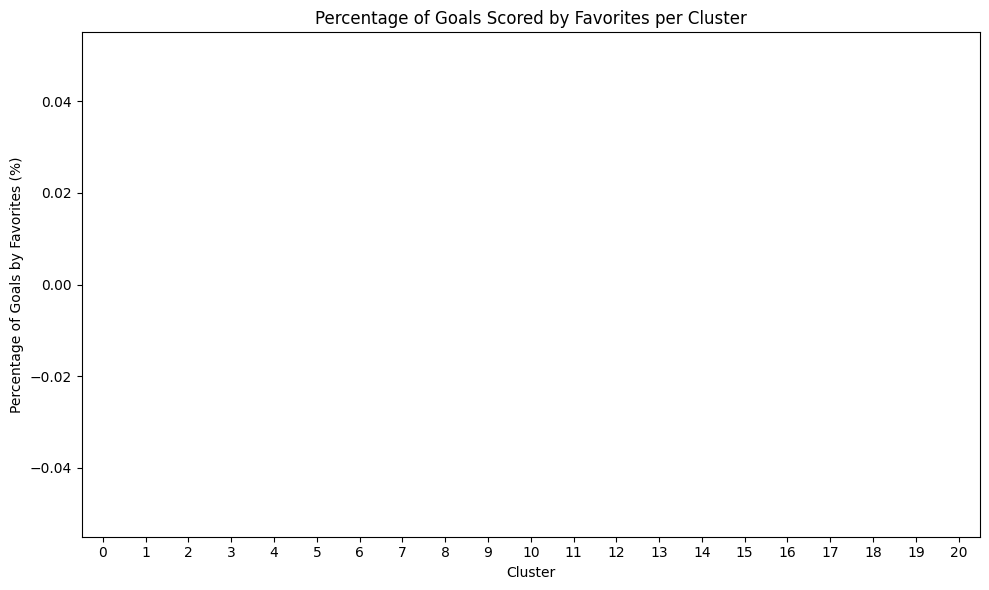

In [22]:
# Relación entre la Diferencia de xG y el Minuto de Gol por Cluster
# Graficando diagramas de dispersión por cluster
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='minute', y='xG_diff', hue='cluster', palette='tab20', alpha=0.7)
plt.title('Relationship Between Goal Minute and xG Difference per Cluster')
plt.xlabel('Minute')
plt.ylabel('Expected Goals Difference (xG_diff)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Distribución de Fuentes de Juego en Clusters y Ligas
# Contar las fuentes de juego por cluster y liga
play_source_counts = df.groupby(['cluster', 'comp'])['play_source'].value_counts().rename('count').reset_index()

# Graficar las fuentes de juego y liga
g = sns.catplot(
    data=play_source_counts,
    x='play_source',
    y='count',
    hue='comp',
    col='cluster',
    kind='bar',
    palette='muted',
    col_wrap=3,
    height=4,
    aspect=1.2
)
g.set_titles("Cluster {col_name}")
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Play Sources per Cluster and League')
plt.tight_layout()
plt.show()

# Analizar el Impacto del Favoritismo del Equipo en los Eventos de Gol por Cluster
# Asegurarse de que la columna 'fav' exista y esté correctamente formateada
# Suponiendo que 'fav' indica si el equipo que anotó era el favorito (1) o no (0)
# Convertir 'fav' a numérico
df['fav'] = pd.to_numeric(df['fav'], errors='coerce')

# Calcular la proporción de goles anotados por los favoritos por cluster
fav_proportions = df.groupby('cluster')['fav'].mean().reset_index()
fav_proportions['fav_percentage'] = fav_proportions['fav'] * 100

# Graficar datos
plt.figure(figsize=(10, 6))
sns.barplot(data=fav_proportions, x='cluster', y='fav_percentage', palette='coolwarm')
plt.title('Percentage of Goals Scored by Favorites per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage of Goals by Favorites (%)')
plt.tight_layout()
plt.show()

# Diagrama de Sankey del Flujo de Eventos que Conducen a Goles
# Instalar plotly si no está instalado
# !pip install plotly



# Preparar los datos para el diagrama Sankey
event_flow = df.groupby(['second_last_event_type', 'last_event_type']).size().reset_index(name='count')
event_flow = event_flow[event_flow['second_last_event_type'].notna() & event_flow['last_event_type'].notna()]

# Crear mapeo de etiquetas a índices
all_labels = list(set(event_flow['second_last_event_type'].tolist() + event_flow['last_event_type'].tolist()))
label_to_index = {label: idx for idx, label in enumerate(all_labels)}

# Definir nodos y enlaces
node = dict(label=all_labels)
link = dict(
    source=event_flow['second_last_event_type'].map(label_to_index),
    target=event_flow['last_event_type'].map(label_to_index),
    value=event_flow['count']
)

# Crear diagrama Sankey
fig = go.Figure(data=[go.Sankey(node=node, link=link)])
fig.update_layout(title_text='Event Flow Leading to Goals', font_size=10)
fig.show()

## Euro

In [23]:
euro_2024_df = df[(df['comp'] == 'UEFA Euro') & (df['season'] == "2024")]
euro_2024_df

match_id       comp season    home_team away_team scoring_team  \
132   3930161  UEFA Euro   2024        Italy   Albania      Albania   
133   3930175  UEFA Euro   2024      Belgium   Romania      Belgium   
134   3930180  UEFA Euro   2024  Netherlands   Austria  Netherlands   
135   3938644  UEFA Euro   2024      Georgia  Portugal      Georgia   
137   3940878  UEFA Euro   2024  Switzerland     Italy  Switzerland   
138   3941022  UEFA Euro   2024      Austria    Turkey       Turkey   
139   3943043  UEFA Euro   2024        Spain   England        Spain   

    team_scored_on  minute  cluster  KO_short_possessions  ...  fav  \
132          Italy       0       12                     2  ...  NaN   
133        Romania       1        3                     6  ...  NaN   
134        Austria      46        6                     8  ...  NaN   
135       Portugal       1        5                     6  ...  NaN   
137          Italy      45        9                     0  ...  NaN   
138        Austria       0        0                     3  ...  NaN   
139        England      46        8                     4  ...  NaN   

     play_source  last_pass_type  shot_detail  last_event_type  \
132      Unknown               0       Inside            Carry   
133      Unknown            None      Outside             Pass   
134      Unknown               0       Inside            Carry   
135      Unknown               0       Inside            Carry   
137      Unknown               0       Inside            Carry   
138      Unknown          Switch       Inside             Pass   
139      Unknown            None       Inside             Pass   

    second_last_event_type scoring_team_home_away  event_sequence  \
132                  Error                   Away  Error -> Carry   
133                  Carry                   Home   Carry -> Pass   
134                   Pass                   Home   Pass -> Carry   
135                   Pass                   Home   Pass -> Carry   
137                   Pass                   Home   Pass -> Carry   
138                   Pass                   Away    Pass -> Pass   
139                  Carry                   Home   Carry -> Pass   

     last_pass_length  last_pass_direction  
132                 0                    0  
133             Short                 Away  
134                 0                    0  
135                 0                    0  
137                 0                    0  
138              Long              Towards  
139            Medium              Towards  

[7 rows x 37 columns]

#Análisis con gráficas de goles

In [27]:
fullinfo = pd.read_csv('/content/drive/My Drive/Hackathon FUT/Data/EG_full_info.csv')

# Cargar el archivo CSV desde Google Drive
file_path = '/content/drive/My Drive/Hackathon FUT/Data/EG_full_info.csv'
df = pd.read_csv(file_path)

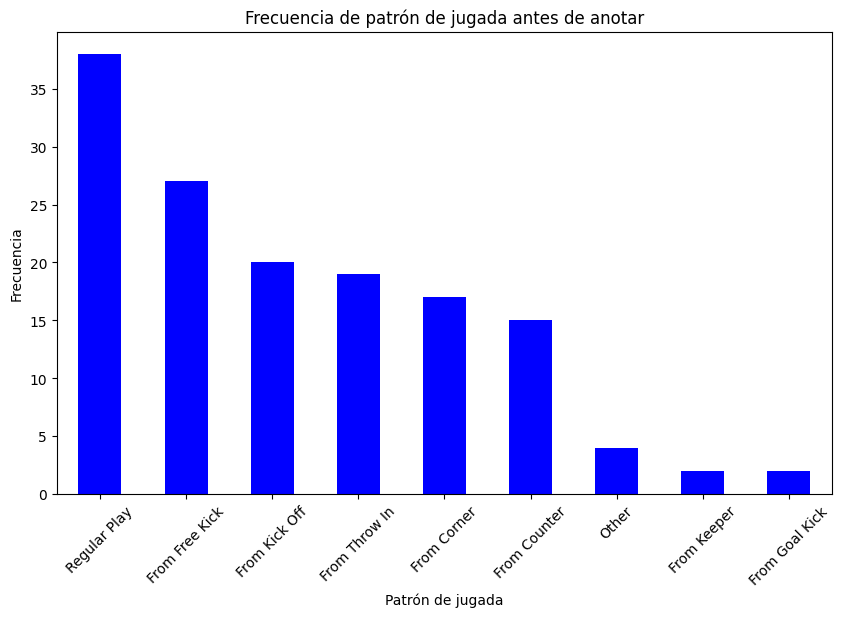

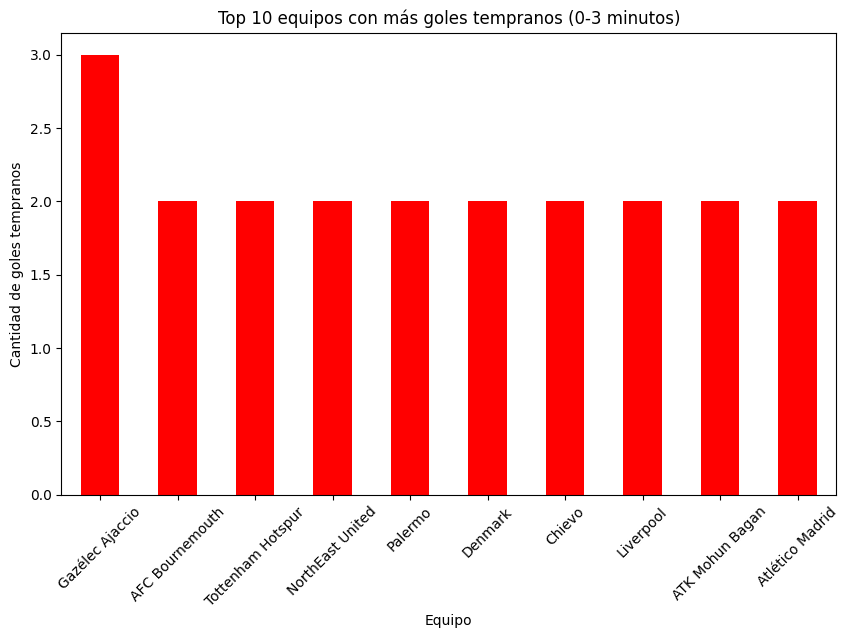

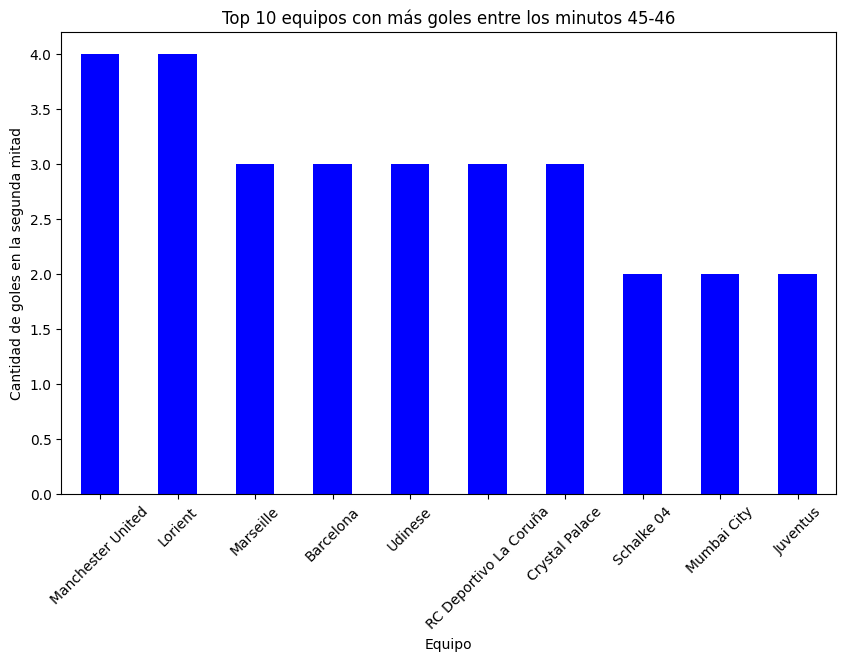

In [26]:
# Jugadas antes del gol
# Contar la frecuencia de cada patrón de jugada antes de los goles
last_play_pattern_count = df['last_play_pattern'].value_counts()

# Crear gráfico de barras
last_play_pattern_count.plot(kind='bar', color='blue', figsize=(10,6))
plt.title('Frecuencia de patrón de jugada antes de anotar')
plt.xlabel('Patrón de jugada')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()


#Top 10 equipos con goles tempranos, primer tiempo
# Definir los goles tempranos como aquellos dentro de los primeros 3 minutos (de 0 a 3)
early_goals = df[df['event_minute'] <= 3]

# Agrupar por equipo y contar la cantidad de goles tempranos
top_teams_early_goals = early_goals.groupby('team').size().sort_values(ascending=False).head(10)

# Graficar los top 5 equipos con más goles tempranos
plt.figure(figsize=(10,6))
top_teams_early_goals.plot(kind='bar', color='red')
plt.title('Top 10 equipos con más goles tempranos (0-3 minutos)')
plt.xlabel('Equipo')
plt.ylabel('Cantidad de goles tempranos')
plt.xticks(rotation=45)
plt.show()


#Top 10 equipos con goles tempranos, segundo tiempo
# Filtrar los goles entre los minutos 45 y 47
second_half_goals = df[(df['event_minute'] >= 45) & (df['event_minute'] <= 46)]

# Agrupar por equipo y contar la cantidad de goles en ese intervalo de tiempo
top_teams_second_half_goals = second_half_goals.groupby('team').size().sort_values(ascending=False).head(10)

# Graficar los top 5 equipos con más goles en la segunda mitad (minutos 45 a 47)
plt.figure(figsize=(10,6))
top_teams_second_half_goals.plot(kind='bar', color='blue')
plt.title('Top 10 equipos con más goles entre los minutos 45-46')
plt.xlabel('Equipo')
plt.ylabel('Cantidad de goles en la segunda mitad')
plt.xticks(rotation=45)
plt.show()

# Goles por ligas

In [28]:
# Cargar el archivo CSV con los datos de goles
df_new_goals = pd.read_csv('/content/drive/My Drive/Hackathon FUT/Data/EG_goals.csv')

league_names = df_new_goals['competition_name'].unique()
league_names

array(['1. Bundesliga', 'African Cup of Nations', 'Copa America',
       "FA Women's Super League", 'FIFA World Cup', 'Indian Super league',
       'La Liga', 'Ligue 1', 'Premier League', 'Serie A', 'UEFA Euro',
       "UEFA Women's Euro", "Women's World Cup"], dtype=object)

In [29]:
# Lista de ligas deseadas
desired_leagues = ['1. Bundesliga', 'African Cup of Nations', 'Copa America',
                   'FIFA World Cup', 'La Liga', 'Ligue 1', 'Premier League',
                   'Serie A', 'UEFA Euro']

# Filtrar el DataFrame para incluir solo las ligas deseadas
filtered_df = df_new_goals[df_new_goals['competition_name'].isin(desired_leagues)]

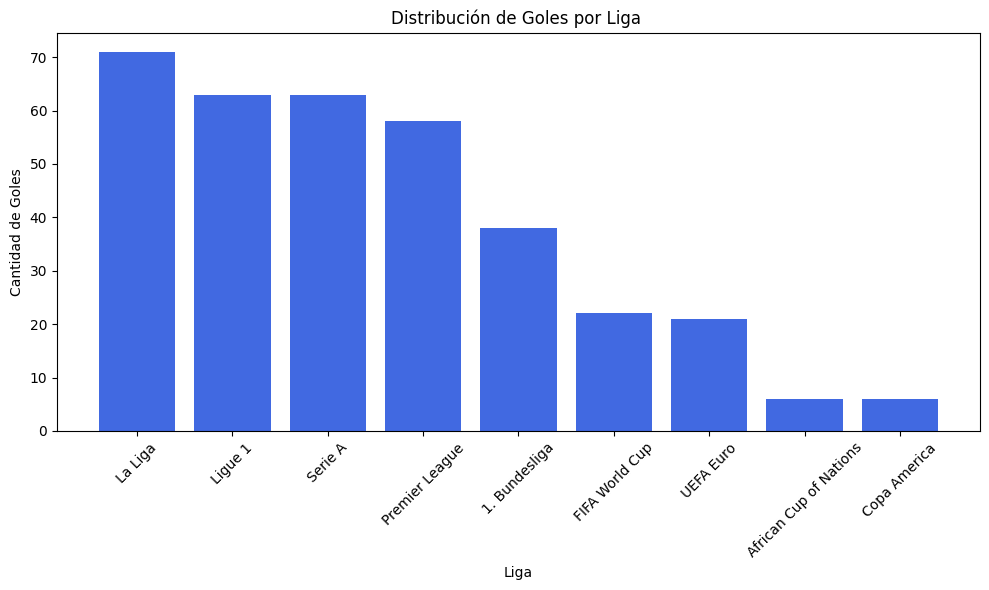

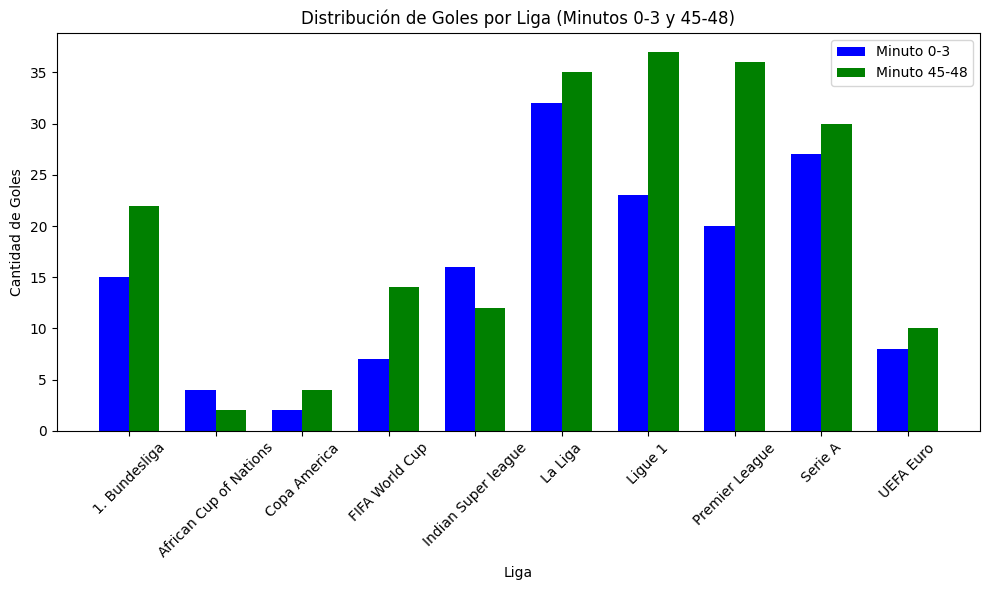

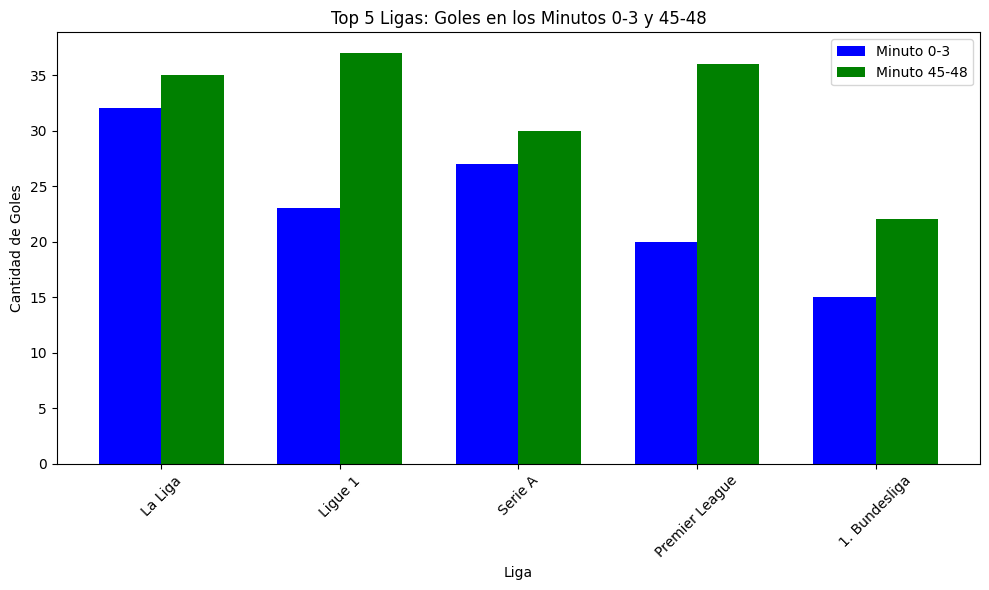

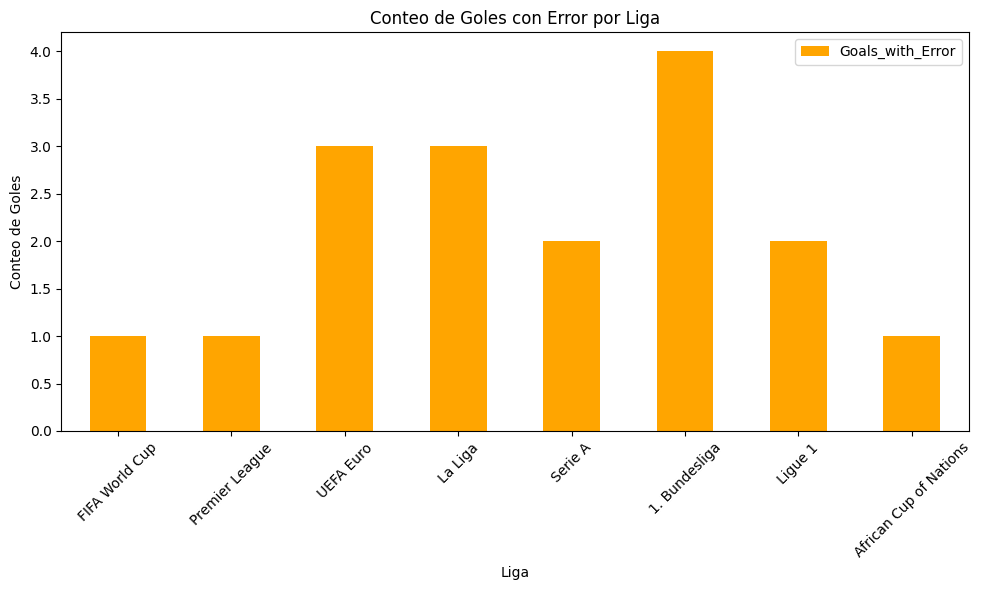

In [30]:
#Distribución de goles por liga
# Contar las veces que aparece cada competición en la columna 'competition_name'
goals_per_league_from_competition_name = filtered_df['competition_name'].value_counts().reset_index()

# Renombrar las columnas para mayor claridad
goals_per_league_from_competition_name.columns = ['League', 'Goal Count']

# Crear un gráfico de barras con los datos
plt.figure(figsize=(10, 6))
plt.bar(goals_per_league_from_competition_name['League'], goals_per_league_from_competition_name['Goal Count'], color='royalblue')

# Añadir títulos y etiquetas
plt.title('Distribución de Goles por Liga ')
plt.xlabel('Liga')
plt.ylabel('Cantidad de Goles')

# Rotar las etiquetas del eje X para mejor visibilidad
plt.xticks(rotation=45)

# Ajustar el layout para evitar solapamiento
plt.tight_layout()

# Mostrar el gráfico
plt.show()


# Goles por liga y por mitad
# Cargar el archivo CSV con los datos de goles
df_new_goals = pd.read_csv('/content/drive/My Drive/Hackathon FUT/Data/EG_goals.csv')

# Excluir las ligas femeninas (ejemplo: excluyendo ligas que contengan "Women" en su nombre)
df_filtered = df_new_goals[~df_new_goals['competition_name'].str.contains("Women", case=False)]

# Filtrar los goles por rangos de tiempo
goals_0_to_3 = df_filtered[(df_filtered['goal_minute'] >= 0) & (df_filtered['goal_minute'] <= 3)]
goals_45_to_48 = df_filtered[(df_filtered['goal_minute'] >= 45) & (df_filtered['goal_minute'] <= 48)]

# Contar los goles por liga para ambos rangos de tiempo
goals_per_league_0_to_3 = goals_0_to_3['competition_name'].value_counts().reset_index()
goals_per_league_45_to_48 = goals_45_to_48['competition_name'].value_counts().reset_index()

# Renombrar las columnas para mayor claridad
goals_per_league_0_to_3.columns = ['League', 'Goals 0-3']
goals_per_league_45_to_48.columns = ['League', 'Goals 45-48']

# Combinar los datos de ambos rangos en un solo DataFrame
goals_combined = pd.merge(goals_per_league_0_to_3, goals_per_league_45_to_48, on='League', how='outer').fillna(0)

# Crear posiciones para las barras
bar_width = 0.35
indices = np.arange(len(goals_combined))

# Crear el gráfico con barras partidas verticalmente
plt.figure(figsize=(10, 6))

# Barras para los goles del minuto 0-3
plt.bar(indices - bar_width/2, goals_combined['Goals 0-3'], width=bar_width, label='Minuto 0-3', color='blue')

# Barras para los goles del minuto 45-48 al lado
plt.bar(indices + bar_width/2, goals_combined['Goals 45-48'], width=bar_width, label='Minuto 45-48', color='green')

# Añadir títulos y etiquetas
plt.title('Distribución de Goles por Liga (Minutos 0-3 y 45-48)')
plt.xlabel('Liga')
plt.ylabel('Cantidad de Goles')
plt.xticks(indices, goals_combined['League'], rotation=45)

# Añadir leyenda para distinguir ambos segmentos de tiempo
plt.legend()

# Ajustar el layout para evitar solapamiento
plt.tight_layout()

# Mostrar el gráfico
plt.show()



# Top 5 de lo anterior
# Cargar el archivo CSV con los datos de goles
df_new_goals = pd.read_csv('/content/drive/My Drive/Hackathon FUT/Data/EG_goals.csv')


# Excluir las ligas femeninas (ejemplo: excluyendo ligas que contengan "Women" en su nombre)
df_filtered = df_new_goals[~df_new_goals['competition_name'].str.contains("Women", case=False)]

# Filtrar los goles por rangos de tiempo
goals_0_to_3 = df_filtered[(df_filtered['goal_minute'] >= 0) & (df_filtered['goal_minute'] <= 3)]
goals_45_to_48 = df_filtered[(df_filtered['goal_minute'] >= 45) & (df_filtered['goal_minute'] <= 48)]

# Contar los goles por liga para ambos rangos de tiempo
goals_per_league_0_to_3 = goals_0_to_3['competition_name'].value_counts().reset_index()
goals_per_league_45_to_48 = goals_45_to_48['competition_name'].value_counts().reset_index()

# Renombrar las columnas para mayor claridad
goals_per_league_0_to_3.columns = ['League', 'Goals 0-3']
goals_per_league_45_to_48.columns = ['League', 'Goals 45-48']

# Combinar los datos de ambos rangos en un solo DataFrame
goals_combined = pd.merge(goals_per_league_0_to_3, goals_per_league_45_to_48, on='League', how='outer').fillna(0)

# Añadir una columna con la suma total de goles para ordenar las ligas
goals_combined['Total Goals'] = goals_combined['Goals 0-3'] + goals_combined['Goals 45-48']

# Ordenar por la suma total de goles y seleccionar el top 5
top_5_goals_combined = goals_combined.sort_values(by='Total Goals', ascending=False).head(5)

# Crear posiciones para las barras
bar_width = 0.35
indices = np.arange(len(top_5_goals_combined))

# Crear el gráfico con barras partidas verticalmente
plt.figure(figsize=(10, 6))

# Barras para los goles del minuto 0-3
plt.bar(indices - bar_width/2, top_5_goals_combined['Goals 0-3'], width=bar_width, label='Minuto 0-3', color='blue')

# Barras para los goles del minuto 45-48 al lado
plt.bar(indices + bar_width/2, top_5_goals_combined['Goals 45-48'], width=bar_width, label='Minuto 45-48', color='green')

# Añadir títulos y etiquetas
plt.title('Top 5 Ligas: Goles en los Minutos 0-3 y 45-48')
plt.xlabel('Liga')
plt.ylabel('Cantidad de Goles')
plt.xticks(indices, top_5_goals_combined['League'], rotation=45)

# Añadir leyenda para distinguir ambos segmentos de tiempo
plt.legend()

# Ajustar el layout para evitar solapamiento
plt.tight_layout()

# Mostrar el gráfico
plt.show()



# Conteo de goles por error
data = pd.read_csv('/content/drive/My Drive/Hackathon FUT/Data/EG_full_w_seq.csv')

# Filtrar las columnas necesarias para el análisis
df_filtered = data[['comp', 'dict_sequences']]

# Inicializar diccionario para contar los goles por liga que incluyan "Error" en secuencias
goal_counts_with_error = {}

# Procesar cada fila
for _, row in df_filtered.iterrows():
    league = row['comp']
    sequences = row['dict_sequences']

    # Revisar si la secuencia tiene un "Error"
    if 'Error' in sequences:
        # Contar goles con "Error" por liga
        goal_counts_with_error[league] = goal_counts_with_error.get(league, 0) + 1

# Crear DataFrame de los resultados
result_df = pd.DataFrame({
    'Goals_with_Error': pd.Series(goal_counts_with_error)
}).fillna(0).astype(int)

# Crear el gráfico de barras en color naranja sin leyenda
result_df.plot(kind='bar', color='orange', figsize=(10, 6))
plt.title('Conteo de Goles con Error por Liga')
plt.xlabel('Liga')
plt.ylabel('Conteo de Goles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Análisis de clusters

In [31]:
data = pd.read_csv('/content/drive/My Drive/Hackathon FUT/Data/EG_full.csv')
# Filtrar por los clusters específicos
clusters_filtrados = [0, 1, 4, 6, 7, 9, 13, 14, 18]
data_filtrada = data[data['cluster'].isin(clusters_filtrados)]

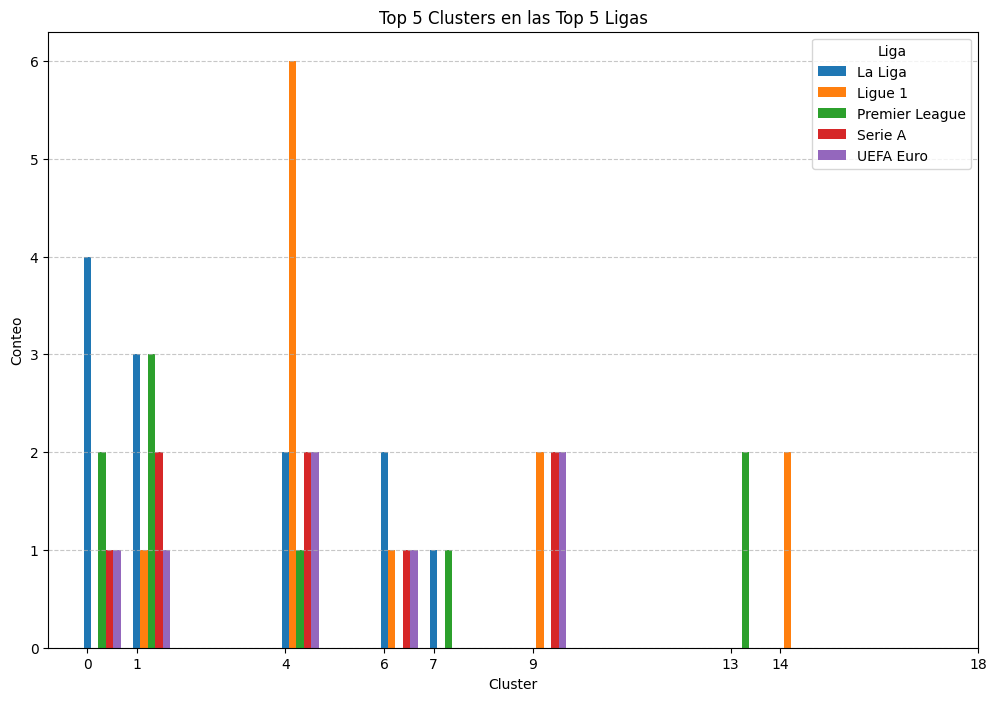

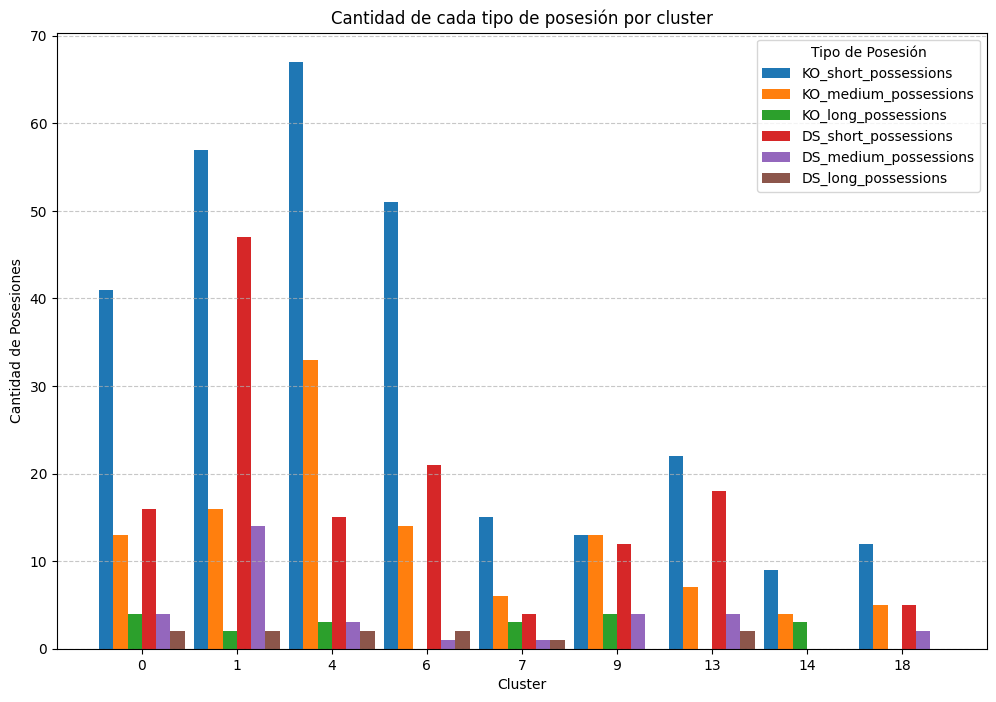

In [34]:
# Top 5 ligas con mayores goles por minuto
# Agrupar y contar los goles por liga (comp) y minuto
resumen_goles_minuto = (
    data_filtrada.groupby(['comp', 'minute'])['scoring_team']
    .count()
    .reset_index(name='goal_count')
)

# Seleccionar las 5 ligas con más goles
top_5_ligas = (
    resumen_goles_minuto.groupby('comp')['goal_count']
    .sum()
    .nlargest(5)
    .index
)

# Filtrar los datos solo para las ligas principales
goles_top_ligas = resumen_goles_minuto[resumen_goles_minuto['comp'].isin(top_5_ligas)]

# Graficar las 5 ligas con la separación de goles por minuto
plt.figure(figsize=(10, 6))
for liga in goles_top_ligas['comp'].unique():
    datos_liga = goles_top_ligas[goles_top_ligas['comp'] == liga]
    plt.plot(datos_liga['minute'], datos_liga['goal_count'], marker='o', label=liga)

# Configuraciones de la gráfica
plt.title("Top 5 ligas con mayores goles por minuto")
plt.xlabel("Minuto")
plt.ylabel("Conteo de Goles")
plt.legend(title="Liga")
plt.grid(True)
plt.show()


# Top 5 Clusters en las Top 5 Ligas
# Obtener las 5 ligas con más ocurrencias en el conjunto de datos
top_5_ligas = data_filtrada['comp'].value_counts().nlargest(5).index

# Filtrar los datos para las ligas principales
datos_top_ligas = data_filtrada[data_filtrada['comp'].isin(top_5_ligas)]

# Contar los clusters más comunes dentro de estas ligas
top_clusters_ligas = (
    datos_top_ligas.groupby(['comp', 'cluster']).size()
    .reset_index(name='count')
    .sort_values(['comp', 'count'], ascending=[True, False])
)

# Obtener los 5 clusters principales por liga
top_clusters_por_liga = top_clusters_ligas.groupby('comp').head(5)

# Crear el gráfico de barras agrupadas
plt.figure(figsize=(12, 8))
for i, liga in enumerate(top_clusters_por_liga['comp'].unique()):
    datos_liga = top_clusters_por_liga[top_clusters_por_liga['comp'] == liga]
    plt.bar(datos_liga['cluster'] + i * 0.15, datos_liga['count'], width=0.15, label=liga)

# Configuración de la gráfica
plt.title("Top 5 Clusters en las Top 5 Ligas")
plt.xlabel("Cluster")
plt.ylabel("Conteo")
plt.xticks(clusters_filtrados)  # Ajusta según el rango de clusters
plt.legend(title="Liga")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Porcentaje de empezar en cada cluster
# Calcular el número de eventos que ocurren en el minuto 0 para cada cluster
eventos_inicio_por_cluster = data_filtrada[data_filtrada['minute'] == 0].groupby('cluster').size()

# Calcular el total de eventos por cada cluster
total_eventos_por_cluster = data_filtrada.groupby('cluster').size()

# Calcular el porcentaje de eventos de inicio (minuto 0) en cada cluster
porcentaje_inicio = (eventos_inicio_por_cluster / total_eventos_por_cluster * 100).fillna(0)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(porcentaje_inicio.index, porcentaje_inicio.values, color='green')

# Configuración de la gráfica
plt.title("Porcentaje de eventos que empiezan en el minuto 0 por cluster")
plt.xlabel("Cluster")
plt.ylabel("Porcentajes")
plt.xticks(clusters_filtrados)  # Mostrar solo los clusters filtrados en el eje X
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Cuántas posesiones por cluster hay
# Sumar las posesiones por cada tipo en cada cluster
posesiones_por_tipo = data_filtrada.groupby('cluster')[[
    'KO_short_possessions', 'KO_medium_possessions', 'KO_long_possessions',
    'DS_short_possessions', 'DS_medium_possessions', 'DS_long_possessions'
]].sum()

# Crear gráfico de barras agrupadas
possession_types = posesiones_por_tipo.columns
x = np.arange(len(posesiones_por_tipo))  # Posiciones en el eje X para cada cluster
width = 0.15  # Ancho de cada barra

plt.figure(figsize=(12, 8))

# Graficar cada tipo de posesión como un conjunto de barras separadas
for i, possession in enumerate(possession_types):
    plt.bar(x + i * width, posesiones_por_tipo[possession], width, label=possession)

# Configuración de la gráfica
plt.title("Cantidad de cada tipo de posesión por cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de Posesiones")
plt.xticks(x + width * 2.5, posesiones_por_tipo.index)  # Colocar los clusters en el eje X
plt.legend(title="Tipo de Posesión")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [35]:
# Frecuencia de último eventos para cada cluster
# Función para extraer el tipo de evento del diccionario en last_event
def extract_event_type(event):
    try:
        event_dict = ast.literal_eval(event)  # Convierte el texto en un diccionario
        return event_dict.get('type', 'Unknown')  # Obtiene el tipo de evento si existe
    except (ValueError, SyntaxError):
        return 'Unknown'  # Retorna 'Unknown' si no se puede convertir

# Aplicar la función para extraer el tipo de evento en la columna last_event
data_filtrada['event_type'] = data_filtrada['last_event'].apply(extract_event_type)

# Filtrar solo los eventos "Pass", "Carry", "Shot" y "Error"
data_filtrada = data_filtrada[data_filtrada['event_type'].isin(['Pass', 'Carry', 'Error'])]

# Agrupar por cluster y tipo de evento, luego contar la frecuencia de cada evento en cada cluster
event_counts = (
    data_filtrada.groupby(['cluster', 'event_type']).size()
    .unstack(fill_value=0)
    .reindex(clusters_filtrados)
)

# Crear la gráfica incluyendo los cuatro eventos
event_counts.plot(kind='bar', stacked=False, figsize=(14, 7), color=['skyblue', 'orange', 'green', 'red'])
plt.xlabel('Cluster')
plt.ylabel('Frecuencia del Evento')
plt.title('Frecuencia de últimos eventos para cada cluster')
plt.xticks(rotation=0)
plt.legend(title='Tipo de Evento')
plt.tight_layout()
plt.show()

<ipython-input-35-bd50d5433e29>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Final

In [38]:
EG_full_w_seq = pd.read_csv('/content/drive/MyDrive/Hackathon FUT/Data/EG_full_w_seq.csv')
EG_full_w_seq.head()

match_id            comp     season               home_team      away_team  \
0      7536  FIFA World Cup       2018                 Belgium         Panama   
1      7581  FIFA World Cup       2018                 Croatia        Denmark   
2    265894         La Liga  2015/2016                  Málaga      Barcelona   
3    266149         La Liga  2015/2016               Barcelona  Athletic Club   
4    266310         La Liga  2015/2016  RC Deportivo La Coruña      Barcelona   

  scoring_team          team_scored_on  minute  cluster  KO_short_possessions  \
0      Belgium                  Panama      46        1                     5   
1      Croatia                 Denmark       0        6                     9   
2    Barcelona                  Málaga       1        7                     2   
3    Barcelona           Athletic Club      46       16                     9   
4    Barcelona  RC Deportivo La Coruña      46       16                     9   

   ...   GF_diff   GA_diff   xG_diff  xGA_diff  Possession_Percentage_diff  \
0  ...  0.200313 -2.726135  0.507230 -0.769070                    2.840712   
1  ...  0.352652  0.723864  0.400621  0.355196                    3.588275   
2  ...  2.007752 -0.082863  1.273171 -0.163107                   15.661709   
3  ...  1.119869 -0.312261  0.906075 -0.067016                   15.924716   
4  ...  1.661538 -0.938462  1.206633 -0.315366                   17.238028   

      x_fav       fav                                          df_events  \
0   med fav  high fav      match_id competition_name season_name home...   
1   neutral   neutral       match_id competition_name season_name hom...   
2   med fav  high fav        match_id competition_name season_name ho...   
3   low fav   med fav        match_id competition_name season_name  h...   
4  high fav  high fav        match_id competition_name season_name   ...   

                                      dict_sequences  \
0  [{'team': 'YES', 'third': 'T2', 'events': [{'t...   
1  [{'team': 'YES', 'third': 'T2', 'events': [{'t...   
2  [{'team': 'YES', 'third': 'T2', 'events': [{'t...   
3  [{'team': 'YES', 'third': 'T2', 'events': [{'t...   
4  [{'team': 'YES', 'third': 'T2', 'events': [{'t...   

                                      df_events_dict  
0  [{'match_id': 7536, 'competition_name': 'FIFA ...  
1  [{'match_id': 7581, 'competition_name': 'FIFA ...  
2  [{'match_id': 265894, 'competition_name': 'La ...  
3  [{'match_id': 266149, 'competition_name': 'La ...  
4  [{'match_id': 266310, 'competition_name': 'La ...  

[5 rows x 31 columns]

In [39]:
def string_to_list(s):
  try:
    return ast.literal_eval(s)
  except (ValueError, SyntaxError):
    return []  # Devolver una lista vacía para cadenas no válidas


cluster	silhouette_score


14 | 0.716682

9	 | 0.669541

0	 | 0.644231

4	 | 0.611741

18 | 0.551170

7	 | 0.524601

6	 | 0.518336

1  | 0.514110

13 | 0.510331




Plotting cluster 9





3754212


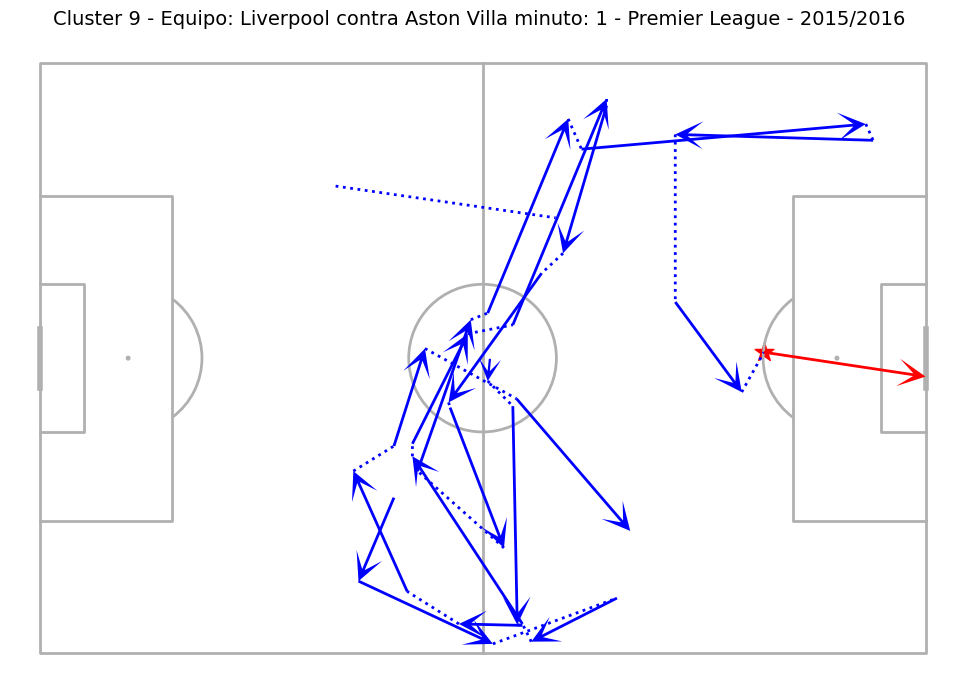

3795187


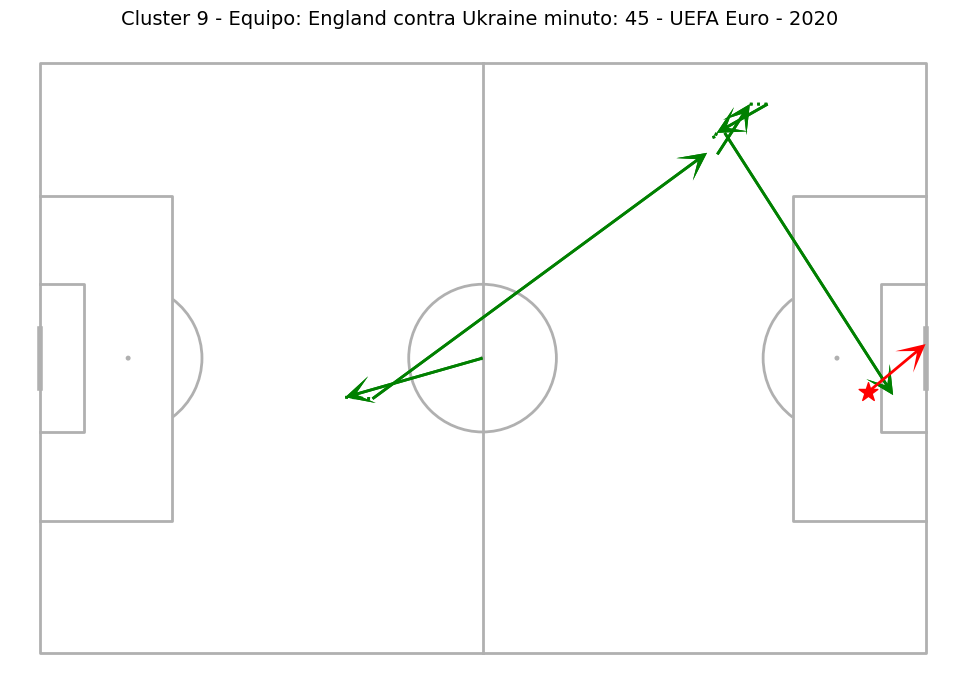

3825741


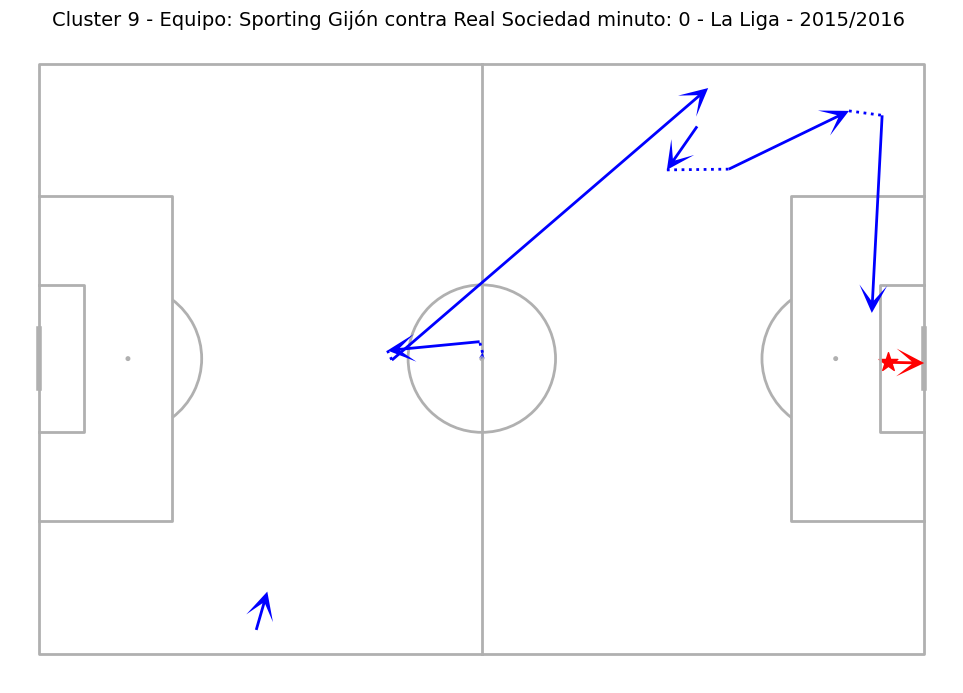

Plotting cluster 18





3817848


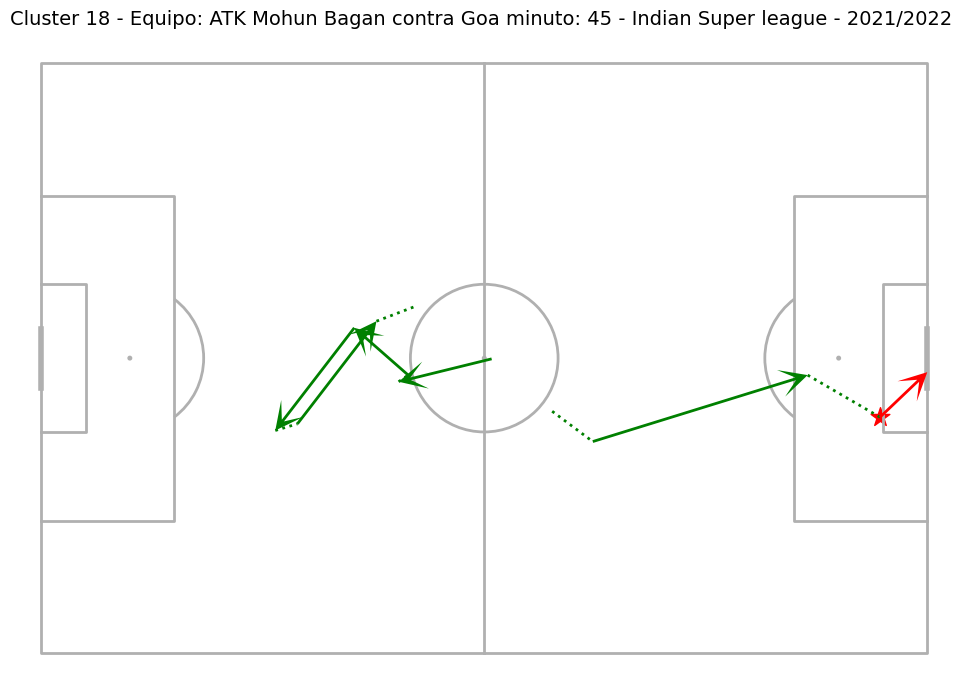

3879815


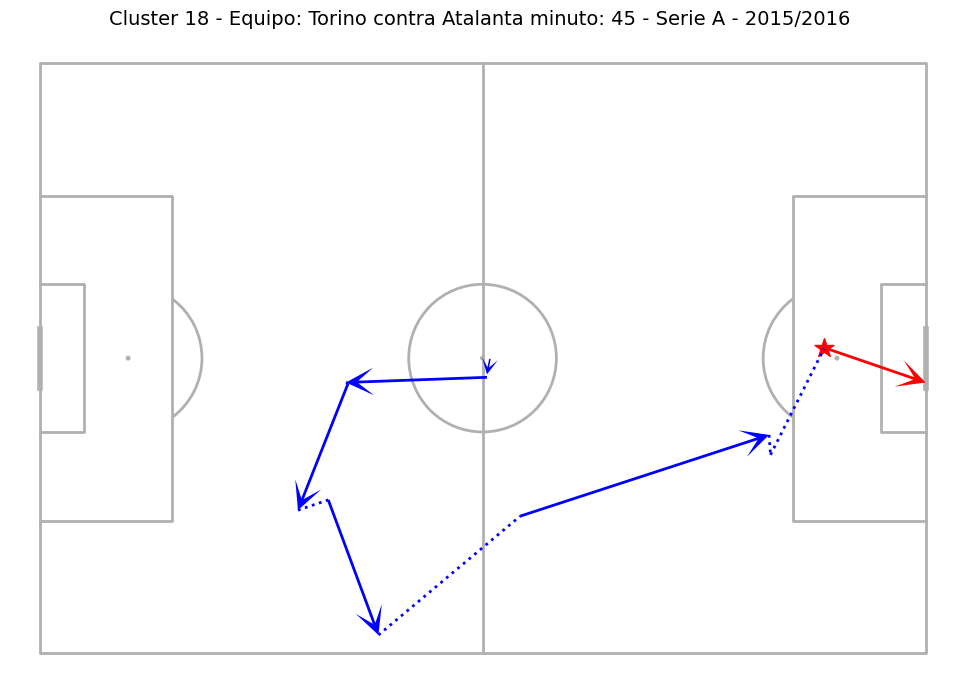

3890329


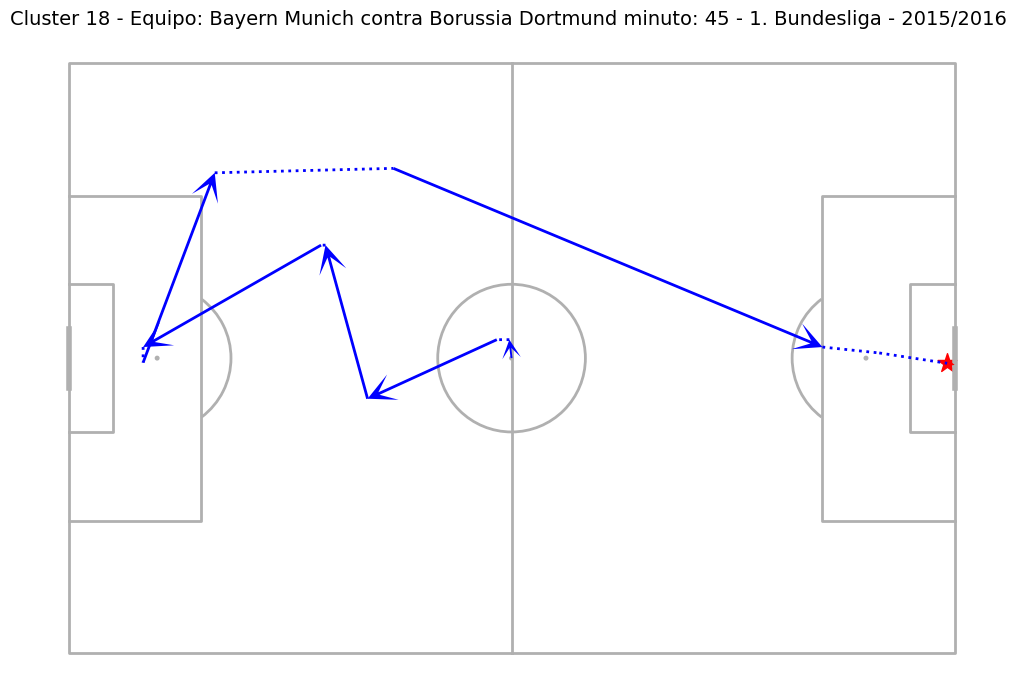

In [42]:
df = EG_full_w_seq

# Función para convertir la representación de una cadena de coordenadas en una lista
def string_to_list(coord_string):
    return ast.literal_eval(coord_string) if isinstance(coord_string, str) else coord_string

# Función para extraer coordenadas de pases
def extract_pass_coords(passes_df):
    passes_df['location'] = passes_df['location'].apply(string_to_list)
    passes_df['pass_end_location'] = passes_df['pass_end_location'].apply(string_to_list)

    passes_df['start_x'] = passes_df['location'].apply(lambda x: x[0] if x else None)
    passes_df['start_y'] = passes_df['location'].apply(lambda x: x[1] if x else None)
    passes_df['end_x'] = passes_df['pass_end_location'].apply(lambda x: x[0] if x else None)
    passes_df['end_y'] = passes_df['pass_end_location'].apply(lambda x: x[1] if x else None)

    return passes_df.dropna(subset=['start_x', 'start_y', 'end_x', 'end_y'])

# Función para extraer coordenadas de carries
def extract_carry_coords(carries_df):
    carries_df['location'] = carries_df['location'].apply(string_to_list)
    carries_df['carry_end_location'] = carries_df['carry_end_location'].apply(string_to_list)

    carries_df['start_x'] = carries_df['location'].apply(lambda x: x[0] if x else None)
    carries_df['start_y'] = carries_df['location'].apply(lambda x: x[1] if x else None)
    carries_df['end_x'] = carries_df['carry_end_location'].apply(lambda x: x[0] if x else None)
    carries_df['end_y'] = carries_df['carry_end_location'].apply(lambda x: x[1] if x else None)

    return carries_df.dropna(subset=['start_x', 'start_y', 'end_x', 'end_y'])

# Define color para los equipos locales y visitantes
team_colors = {
    'home_team': 'blue',
    'away_team': 'green'
}

clusters_to_plot = [9, 18]

for cluster in clusters_to_plot:
    print(f"Plotting cluster {cluster}\n\n\n\n\n")

    df_cluster = df[df['cluster'] == cluster]

    for idx, row in df_cluster.head(3).iterrows():

        events_df = row['df_events_dict']

        home_team = row['home_team']
        away_team = row['away_team']
        match_id = row['match_id']
        comp = row['comp']
        season = row['season']
        minute = row['minute']
        scoring_team = row['scoring_team']
        scored_on = row['team_scored_on']

        print(match_id)



        # Convierte a DataFrame
        events_df = ast.literal_eval(events_df.replace("nan", "None"))
        events_df = pd.DataFrame(events_df)

        if isinstance(events_df, pd.DataFrame) and not events_df.empty:

            passes = events_df[events_df['event_type'] == 'Pass'].copy()
            carries = events_df[events_df['event_type'] == 'Carry'].copy()

            if not passes.empty:
                passes = extract_pass_coords(passes)

            if not carries.empty:
                carries = extract_carry_coords(carries)


            pitch = Pitch(pitch_type='statsbomb', line_zorder=2)
            fig, ax = pitch.draw(figsize=(10, 7))

            # Da los colores de los equipos
            pass_color = team_colors['home_team'] if row['scoring_team'] == home_team else team_colors['away_team']
            carry_color = team_colors['home_team'] if row['scoring_team'] == home_team else team_colors['away_team']

            # Graficar pases
            pitch.arrows(
                passes['start_x'],
                passes['start_y'],
                passes['end_x'],
                passes['end_y'],
                ax=ax,
                width=2,
                headwidth=10,
                headlength=10,
                color=pass_color,
                zorder=3,
                label='Passes'
            )

            # Graficar carry con líneas punteadas
            pitch.lines(
                carries['start_x'],
                carries['start_y'],
                carries['end_x'],
                carries['end_y'],
                ax=ax,
                linestyle='dotted',
                linewidth=2,
                color=carry_color,
                zorder=3,
                label='Carries'
            )

            # Resaltar evento del gol
            goal_event = events_df[(events_df['event_type'] == 'Shot') & (events_df['shot_outcome'] == 'Goal')]
            if not goal_event.empty:
                goal_event = goal_event.iloc[0]
                goal_event['location'] = string_to_list(goal_event['location'])
                goal_event['shot_end_location'] = string_to_list(goal_event['shot_end_location'])

                shot_x = goal_event['location'][0] if goal_event['location'] else None
                shot_y = goal_event['location'][1] if goal_event['location'] else None
                end_x = goal_event['shot_end_location'][0] if goal_event['shot_end_location'] else None
                end_y = goal_event['shot_end_location'][1] if goal_event['shot_end_location'] else None

                if shot_x and shot_y:
                    pitch.scatter(shot_x, shot_y, ax=ax, c='red', s=200, marker='*', label='Goal')
                    pitch.arrows(shot_x, shot_y, end_x, end_y, ax=ax, width=2, headwidth=10, headlength=10, color='red', zorder=3)

            ax.set_title(f'Cluster {cluster} - Equipo: {scoring_team} contra {scored_on} minuto: {minute} - {comp} - {season} ', fontsize=14)
            plt.show()


In [43]:
clusters_to_filter = [18, 9]
filtered_df = df[df['cluster'].isin(clusters_to_filter)]
filtered_df.sort_values(by='cluster')

match_id                 comp     season        home_team  \
15    3754212       Premier League  2015/2016        Liverpool   
31    3795187            UEFA Euro       2020          Ukraine   
51    3825741              La Liga  2015/2016   Sporting Gijón   
68    3829517              Ligue 1  2015/2016  Gazélec Ajaccio   
79    3879650              Serie A  2015/2016           Empoli   
94    3879874              Serie A  2015/2016            Lazio   
124   3901183              Ligue 1  2015/2016           Troyes   
137   3940878            UEFA Euro       2024      Switzerland   
38    3817848  Indian Super league  2021/2022              Goa   
87    3879815              Serie A  2015/2016           Torino   
99    3890329        1. Bundesliga  2015/2016    Bayern Munich   
116   3900594              Ligue 1  2015/2016           Nantes   

               away_team         scoring_team     team_scored_on  minute  \
15           Aston Villa            Liverpool        Aston Villa       1   
31               England              England            Ukraine      45   
51         Real Sociedad       Sporting Gijón      Real Sociedad       0   
68              OGC Nice      Gazélec Ajaccio           OGC Nice       0   
79                 Carpi               Empoli              Carpi      45   
94            Fiorentina                Lazio         Fiorentina       1   
124  Paris Saint-Germain  Paris Saint-Germain             Troyes      45   
137                Italy          Switzerland              Italy      45   
38       ATK Mohun Bagan      ATK Mohun Bagan                Goa      45   
87              Atalanta               Torino           Atalanta      45   
99     Borussia Dortmund        Bayern Munich  Borussia Dortmund      45   
116             Bordeaux               Nantes           Bordeaux       0   

     cluster  KO_short_possessions  ...   GF_diff   GA_diff   xG_diff  \
15         9                     1  ...  0.858046 -0.891722  0.777641   
31         9                     4  ...  0.663265 -0.316327  0.588842   
51         9                     1  ... -0.172872  0.341018 -0.262070   
68         9                     3  ... -0.925519  0.527760 -0.262588   
79         9                     0  ...  0.231952  0.217781  0.007161   
94         9                     3  ... -0.180251  0.371473 -0.123057   
124        9                     1  ...  1.963333 -1.541667  1.109845   
137        9                     0  ... -0.284615  1.112308 -0.356585   
38        18                     3  ...  0.521348  0.040356  0.102038   
87        18                     5  ...  0.366359  0.314872  0.250217   
99        18                     4  ... -0.157952 -0.625817 -0.360649   
116       18                     0  ... -0.559542 -0.106989 -0.251579   

     xGA_diff  Possession_Percentage_diff      x_fav        fav  \
15  -0.774052                   12.169373   high fav   high fav   
31   0.247177                    3.885478    neutral    low fav   
51   0.322698                   -9.610206  low unfav  low unfav   
68  -0.188982                   -4.941529    neutral  med unfav   
79  -0.173218                   14.605108    neutral    neutral   
94   0.330748                   -8.149776    neutral  low unfav   
124 -1.179927                   15.120150   high fav   high fav   
137  0.292651                   -6.052467  low unfav  med unfav   
38   0.219280                  -13.363003    neutral    neutral   
87  -0.099252                    2.541711    neutral    neutral   
99  -0.381135                    9.932631    neutral    neutral   
116 -0.196094                   -0.728119    neutral    neutral   

                                             df_events  \
15         match_id competition_name season_name  h...   
31         match_id competition_name season_name ho...   
51          match_id competition_name season_name  ...   
68          match_id competition_name season_name  ...   
79          match_id competition_name season_

In [44]:
match_ids_to_find = [3879815, 3890329, 3795187, 3825741]

match_ids_to_find = [str(x) for x in match_ids_to_find]

filtered_df = df[df['match_id'].astype(str).isin(match_ids_to_find)]
filtered_df

match_id           comp     season       home_team          away_team  \
31   3795187      UEFA Euro       2020         Ukraine            England   
51   3825741        La Liga  2015/2016  Sporting Gijón      Real Sociedad   
87   3879815        Serie A  2015/2016          Torino           Atalanta   
99   3890329  1. Bundesliga  2015/2016   Bayern Munich  Borussia Dortmund   

      scoring_team     team_scored_on  minute  cluster  KO_short_possessions  \
31         England            Ukraine      45        9                     4   
51  Sporting Gijón      Real Sociedad       0        9                     1   
87          Torino           Atalanta      45       18                     5   
99   Bayern Munich  Borussia Dortmund      45       18                     4   

    ...   GF_diff   GA_diff   xG_diff  xGA_diff  Possession_Percentage_diff  \
31  ...  0.663265 -0.316327  0.588842  0.247177                    3.885478   
51  ... -0.172872  0.341018 -0.262070  0.322698                   -9.610206   
87  ...  0.366359  0.314872  0.250217 -0.099252                    2.541711   
99  ... -0.157952 -0.625817 -0.360649 -0.381135                    9.932631   

        x_fav        fav                                          df_events  \
31    neutral    low fav        match_id competition_name season_name ho...   
51  low unfav  low unfav         match_id competition_name season_name  ...   
87    neutral    neutral         match_id competition_name season_name h...   
99    neutral    neutral         match_id competition_name season_name  ...   

                                       dict_sequences  \
31  [{'team': 'YES', 'third': 'T2', 'events': [{'t...   
51  [{'team': 'YES', 'third': 'T2', 'events': [{'t...   
87  [{'team': 'YES', 'third': 'T2', 'events': [{'t...   
99  [{'team': 'YES', 'third': 'T2', 'events': [{'t...   

                                       df_events_dict  
31  [{'match_id': 3795187, 'competition_name': 'UE...  
51  [{'match_id': 3825741, 'competition_name': 'La...  
87  [{'match_id': 3879815, 'competition_name': 'Se...  
99  [{'match_id': 3890329, 'competition_name': '1....  

[4 rows x 31 columns]

In [45]:
features_to_list = [
    'match_id',
    'cluster',
    'KO_short_possessions',
    'KO_medium_possessions',
    'KO_long_possessions',
    'DS_short_possessions',
    'DS_medium_possessions',
    'DS_long_possessions',
    'last_event',
    'second_last_event',
    'shot_data'
]

filtered_df[features_to_list]

match_id  cluster  KO_short_possessions  KO_medium_possessions  \
31   3795187        9                     4                      0   
51   3825741        9                     1                      3   
87   3879815       18                     5                      1   
99   3890329       18                     4                      2   

    KO_long_possessions  DS_short_possessions  DS_medium_possessions  \
31                    1                     0                      0   
51                    0                     1                      0   
87                    0                     0                      0   
99                    0                     0                      0   

    DS_long_possessions                                         last_event  \
31                    0  {'type': 'Pass', 'play_source': 'From Free Kic...   
51                    0  {'type': 'Error', 'event': {'type': 'Error', '...   
87                    0  {'type': 'Carry', 'play_source': 'From Kick Of...   
99                    0  {'type': 'Carry', 'play_source': 'From Kick Of...   

                                    second_last_event  \
31  {'type': 'Carry', 'play_source': 'From Kick Of...   
51  {'type': 'Pass', 'play_source': 'From Kick Off...   
87  {'type': 'Dribble', 'event': {'type': 'Dribble...   
99  {'type': 'Dribble', 'event': {'type': 'Dribble...   

                                            shot_data  
31  {'type': 'Shot', 'event': {'type': 'Shot', 'pl...  
51  {'type': 'Shot', 'event': {'type': 'Shot', 'pl...  
87  {'type': 'Shot', 'event': {'type': 'Shot', 'pl...  
99  {'type': 'Shot', 'event': {'type': 'Shot', 'pl...

In [46]:
# Imprimir toda la información del diccionario de 'last_event' y 'second_last_event' para cada fila de 'filtered_df'

import ast

for index, row in filtered_df[features_to_list].iterrows():
    try:
        last_event = ast.literal_eval(row['last_event'])
        second_last_event = ast.literal_eval(row['second_last_event'])

        print(f"Row Index: {index}")
        print(f"Match ID: {row['match_id']}")
        print("Last Event:")
        print(last_event)
        print("\nSecond Last Event:")
        print(second_last_event)
        print("-" * 40)

    except (ValueError, SyntaxError):
        print(f"Error processing row {index}: Invalid string representation of dictionary")
        print("Last Event:", row['last_event'])
        print("Second Last Event:", row['second_last_event'])
        print("-" * 40)

Row Index: 31
Match ID: 3795187
Last Event:
{'type': 'Pass', 'play_source': 'From Free Kick', 'pass_type': 'Cross', 'pass_detail': 'High Pass', 'length': 'Long', 'direction': 'Towards', 'third': 'T1', 'team': 'YES'}

Second Last Event:
{'type': 'Carry', 'play_source': 'From Kick Off', 'length': 'Short', 'direction': 'Sideways', 'third': 'T1', 'team': 'YES'}
----------------------------------------
Row Index: 51
Match ID: 3825741
Last Event:
{'type': 'Error', 'event': {'type': 'Error', 'play_source': 'From Kick Off', 'team': 'NO'}}

Second Last Event:
{'type': 'Pass', 'play_source': 'From Kick Off', 'pass_type': 'Cross', 'pass_detail': 'Ground Pass', 'length': 'Medium', 'direction': 'Towards', 'third': 'T1', 'team': 'YES'}
----------------------------------------
Row Index: 87
Match ID: 3879815
Last Event:
{'type': 'Carry', 'play_source': 'From Kick Off', 'length': 'Medium', 'direction': 'Towards', 'third': 'T1', 'team': 'YES'}

Second Last Event:
{'type': 'Dribble', 'event': {'type': '

In [47]:
euro_2024_df = df[(df['comp'] == 'UEFA Euro') & (df['season'] == "2024")]
euro_2024_df

match_id       comp season    home_team away_team scoring_team  \
132   3930161  UEFA Euro   2024        Italy   Albania      Albania   
133   3930175  UEFA Euro   2024      Belgium   Romania      Belgium   
134   3930180  UEFA Euro   2024  Netherlands   Austria  Netherlands   
135   3938644  UEFA Euro   2024      Georgia  Portugal      Georgia   
137   3940878  UEFA Euro   2024  Switzerland     Italy  Switzerland   
138   3941022  UEFA Euro   2024      Austria    Turkey       Turkey   
139   3943043  UEFA Euro   2024        Spain   England        Spain   

    team_scored_on  minute  cluster  KO_short_possessions  ...   GF_diff  \
132          Italy       0       12                     2  ... -1.679487   
133        Romania       1        3                     6  ... -0.384921   
134        Austria      46        6                     8  ...  1.194898   
135       Portugal       1        5                     6  ... -1.239203   
137          Italy      45        9                     0  ... -0.284615   
138        Austria       0        0                     3  ... -0.075000   
139        England      46        8                     4  ...  0.390191   

      GA_diff   xG_diff  xGA_diff  Possession_Percentage_diff       x_fav  \
132 -0.410256 -1.665071 -0.915539                  -11.369326   low unfav   
133 -0.291667  0.491426  0.080192                   16.165971     neutral   
134  0.421429  0.501596  0.166169                   -0.118642     neutral   
135  1.219269 -0.722345  1.500354                  -19.277217  high unfav   
137  1.112308 -0.356585  0.292651                   -6.052467   low unfav   
138  0.662500  0.183190  0.284998                    5.985945     neutral   
139  0.566789  1.087784  0.380540                   17.915042     low fav   

            fav                                          df_events  \
132   med unfav         match_id competition_name season_name h...   
133     neutral         match_id competition_name season_name h...   
134     low fav         match_id competition_name season_name  ...   
135  high unfav         match_id competition_name season_name h...   
137   med unfav         match_id competition_name season_name  ...   
138   low unfav         match_id competition_name season_name h...   
139     neutral         match_id competition_name season_name h...   

                                        dict_sequences  \
132  [{'team': 'YES', 'third': 'T2', 'events': [{'t...   
133  [{'team': 'YES', 'third': 'T2', 'events': [{'t...   
134  [{'team': 'YES', 'third': 'T2', 'events': [{'t...   
135  [{'team': 'YES', 'third': 'T2', 'events': [{'t...   
137  [{'team': 'YES', 'third': 'T2', 'events': [{'t...   
138  [{'team': 'YES', 'third': 'T2', 'events': [{'t...   
139  [{'team': 'YES', 'third': 'T2', 'events': [{'t...   

                                        df_events_dict  
132  [{'match_id': 3930161, 'competition_name': 'UE...  
133  [{'match_id': 3930175, 'competition_name': 'UE...  
134  [{'match_id': 3930180, 'competition_name': 'UE...  
135  [{'match_id': 3938644, 'competition_name': 'UE...  
137  [{'match_id': 3940878, 'competition_name': 'UE...  
138  [{'match_id': 3941022, 'competition_name': 'UE...  
139  [{'match_id': 3943043, 'competition_name': 'UE...  

[7 rows x 31 columns]

Drawing game 3941022 between Austria and Turkey


<ipython-input-48-9aca7ecb4a78>:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-48-9aca7ecb4a78>:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-48-9aca7ecb4a78>:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-48-9aca

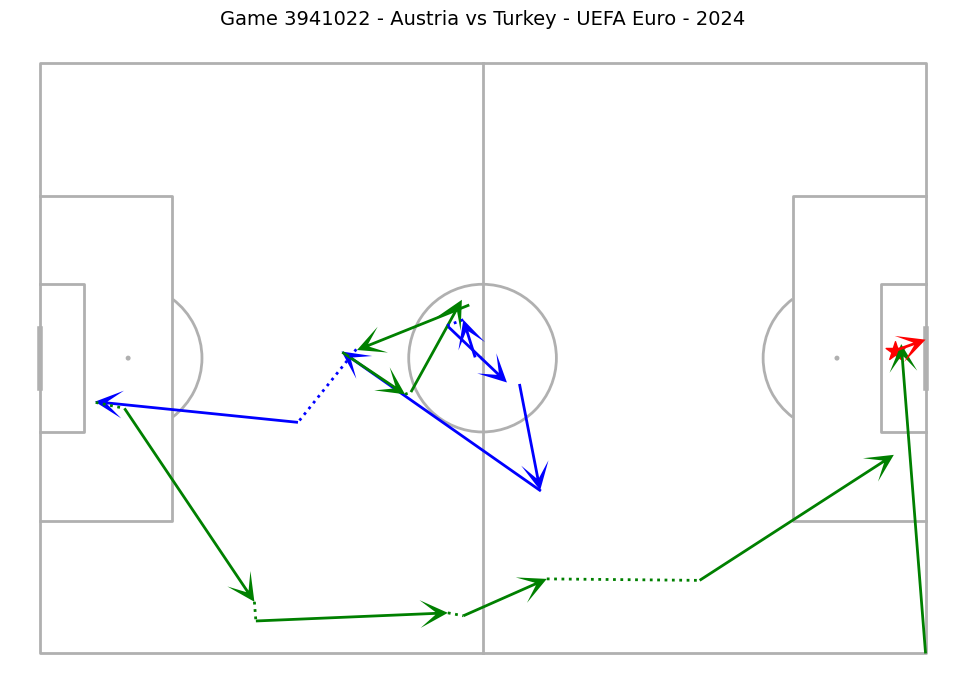

In [48]:
# Suponiendo que el DataFrame contiene los datos del juego
df = EG_full_w_seq

def string_to_list(coord_string):
    return ast.literal_eval(coord_string) if isinstance(coord_string, str) else coord_string

# Función para extraer coordenadas pases
def extract_pass_coords(passes_df):
    passes_df['location'] = passes_df['location'].apply(string_to_list)
    passes_df['pass_end_location'] = passes_df['pass_end_location'].apply(string_to_list)

    passes_df['start_x'] = passes_df['location'].apply(lambda x: x[0] if x else None)
    passes_df['start_y'] = passes_df['location'].apply(lambda x: x[1] if x else None)
    passes_df['end_x'] = passes_df['pass_end_location'].apply(lambda x: x[0] if x else None)
    passes_df['end_y'] = passes_df['pass_end_location'].apply(lambda x: x[1] if x else None)

    return passes_df.dropna(subset=['start_x', 'start_y', 'end_x', 'end_y'])

# Función para extreare coordenadas de carries
def extract_carry_coords(carries_df):
    carries_df['location'] = carries_df['location'].apply(string_to_list)
    carries_df['carry_end_location'] = carries_df['carry_end_location'].apply(string_to_list)

    carries_df['start_x'] = carries_df['location'].apply(lambda x: x[0] if x else None)
    carries_df['start_y'] = carries_df['location'].apply(lambda x: x[1] if x else None)
    carries_df['end_x'] = carries_df['carry_end_location'].apply(lambda x: x[0] if x else None)
    carries_df['end_y'] = carries_df['carry_end_location'].apply(lambda x: x[1] if x else None)

    return carries_df.dropna(subset=['start_x', 'start_y', 'end_x', 'end_y'])

# Función para invertir coordenadas
def flip_coordinates(df, pitch_length=120, pitch_width=80):
    df['start_x'] = pitch_length - df['start_x']
    df['end_x'] = pitch_length - df['end_x']
    df['start_y'] = pitch_width - df['start_y']
    df['end_y'] = pitch_width - df['end_y']
    return df

# Definir colores para equipos locales y visitantes
team_colors = {
    'home_team': 'blue',
    'away_team': 'green'
}

def draw_game(game_id):
    df_game = df[df['match_id'] == game_id]

    if df_game.empty:
        print(f"No data found for game with id {game_id}")
        return

    # Inicializar un DataFrame vacío para todos los eventos
    all_events_df = pd.DataFrame()

    # Para cada secuencia en el juego, extraer eventos y agregar a 'all_events_df'
    for idx, row in df_game.iterrows():
        events_df = row['df_events_dict']

        if isinstance(events_df, str):
            events_df = events_df.replace("nan", "None")
            events_df = ast.literal_eval(events_df)
            events_df = pd.DataFrame(events_df)
        else:
            events_df = pd.DataFrame(events_df)

        # Agregar información del equipo
        events_df['scoring_team'] = row['scoring_team']
        events_df['home_team'] = row['home_team']
        events_df['away_team'] = row['away_team']
        all_events_df = pd.concat([all_events_df, events_df], ignore_index=True)

    home_team = df_game['home_team'].iloc[0]
    away_team = df_game['away_team'].iloc[0]
    comp = df_game['comp'].iloc[0]
    season = df_game['season'].iloc[0]
    scoring_team = df_game['scoring_team'].iloc[0]

    # Determinar el equipo a invertir
    teams = [home_team, away_team]
    team_to_flip = [team for team in teams if team != scoring_team][0]

    print(f"Drawing game {game_id} between {home_team} and {away_team}")

    if not all_events_df.empty:
        # Extraer pases y carries
        passes = all_events_df[all_events_df['event_type'] == 'Pass'].copy()
        carries = all_events_df[all_events_df['event_type'] == 'Carry'].copy()

        if not passes.empty:
            passes = extract_pass_coords(passes)

        if not carries.empty:
            carries = extract_carry_coords(carries)

        # Asignar colores dependiendo del equipo
        passes['color'] = passes['team'].apply(lambda x: team_colors['home_team'] if x == home_team else team_colors['away_team'])
        carries['color'] = carries['team'].apply(lambda x: team_colors['home_team'] if x == home_team else team_colors['away_team'])

        # Invertir coordenadas para equipos que no anotaron
        passes_to_flip = passes[passes['team'] == team_to_flip]
        passes_to_keep = passes[passes['team'] != team_to_flip]
        if not passes_to_flip.empty:
            passes_to_flip = flip_coordinates(passes_to_flip)
        passes = pd.concat([passes_to_flip, passes_to_keep])

        carries_to_flip = carries[carries['team'] == team_to_flip]
        carries_to_keep = carries[carries['team'] != team_to_flip]
        if not carries_to_flip.empty:
            carries_to_flip = flip_coordinates(carries_to_flip)
        carries = pd.concat([carries_to_flip, carries_to_keep])

        # Invertit los eventos de goles para los equipos que no anotaron
        goal_events = all_events_df[(all_events_df['event_type'] == 'Shot') & (all_events_df['shot_outcome'] == 'Goal')].copy()
        if not goal_events.empty:
            goal_events['location'] = goal_events['location'].apply(string_to_list)
            goal_events['shot_end_location'] = goal_events['shot_end_location'].apply(string_to_list)
            goal_events['x'] = goal_events['location'].apply(lambda x: x[0] if x else None)
            goal_events['y'] = goal_events['location'].apply(lambda x: x[1] if x else None)
            goal_events['end_x'] = goal_events['shot_end_location'].apply(lambda x: x[0] if x else None)
            goal_events['end_y'] = goal_events['shot_end_location'].apply(lambda x: x[1] if x else None)

            goals_to_flip = goal_events[goal_events['team'] == team_to_flip]
            goals_to_keep = goal_events[goal_events['team'] != team_to_flip]
            if not goals_to_flip.empty:
                goals_to_flip = flip_coordinates(goals_to_flip)
            goal_events = pd.concat([goals_to_flip, goals_to_keep])


        pitch = Pitch(pitch_type='statsbomb', pitch_length=120, pitch_width=80, line_zorder=2)
        fig, ax = pitch.draw(figsize=(10, 7))

        # Graficar los pases
        for color in passes['color'].unique():
            team_passes = passes[passes['color'] == color]
            pitch.arrows(
                team_passes['start_x'],
                team_passes['start_y'],
                team_passes['end_x'],
                team_passes['end_y'],
                ax=ax,
                width=2,
                headwidth=10,
                headlength=10,
                color=color,
                zorder=3,
                label=f'Passes ({color})'
            )

        # Graficar carries
        for color in carries['color'].unique():
            team_carries = carries[carries['color'] == color]
            pitch.lines(
                team_carries['start_x'],
                team_carries['start_y'],
                team_carries['end_x'],
                team_carries['end_y'],
                ax=ax,
                linestyle='dotted',
                linewidth=2,
                color=color,
                zorder=3,
                label=f'Carries ({color})'
            )

        # Graficar los goles
        if not goal_events.empty:
            for idx, goal_event in goal_events.iterrows():
                shot_x = goal_event['x']
                shot_y = goal_event['y']
                end_x = goal_event['end_x']
                end_y = goal_event['end_y']

                if shot_x and shot_y:
                    pitch.scatter(shot_x, shot_y, ax=ax, c='red', s=200, marker='*', label='Goal')
                    pitch.arrows(shot_x, shot_y, end_x, end_y, ax=ax, width=2, headwidth=10, headlength=10, color='red', zorder=3)

        ax.set_title(f'Game {game_id} - {home_team} vs {away_team} - {comp} - {season}', fontsize=14)
        plt.show()
    else:
        print("No events data available to plot.")

# Ejemplo de uso:
# Reemplaza 'your_game_id' con el ID de juego real que deseas graficar
draw_game(3941022)
